In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 738)
(772408, 8)
validation
(101248, 738)
(101248, 8)
test
(98888, 738)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 738)]             0         


 dense (Dense)               (None, 1024)              756736    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1446792 (5.52 MB)


Trainable params: 1446792 (5.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:48 - loss: 2.1385 - STD: 0.0652 - MAE: 0.2185

 4/78 [>.............................] - ETA: 1s - loss: 1.6341 - STD: 0.1214 - MAE: 0.1795  

 5/78 [>.............................] - ETA: 2s - loss: 1.5879 - STD: 0.1448 - MAE: 0.1693

 6/78 [=>............................] - ETA: 2s - loss: 1.5560 - STD: 0.1625 - MAE: 0.1615

 7/78 [=>............................] - ETA: 2s - loss: 1.5344 - STD: 0.1756 - MAE: 0.1559

 8/78 [==>...........................] - ETA: 2s - loss: 1.5187 - STD: 0.1848 - MAE: 0.1520

 9/78 [==>...........................] - ETA: 2s - loss: 1.5011 - STD: 0.1907 - MAE: 0.1493

10/78 [==>...........................] - ETA: 2s - loss: 1.4853 - STD: 0.1940 - MAE: 0.1477

11/78 [===>..........................] - ETA: 2s - loss: 1.4708 - STD: 0.1952 - MAE: 0.1470

12/78 [===>..........................] - ETA: 2s - loss: 1.4591 - STD: 0.1947 - MAE: 0.1469

13/78 [====>.........................] - ETA: 2s - loss: 1.4489 - STD: 0.1933 - MAE: 0.1472

14/78 [====>.........................] - ETA: 2s - loss: 1.4415 - STD: 0.1915 - MAE: 0.1478

15/78 [====>.........................] - ETA: 2s - loss: 1.4356 - STD: 0.1897 - MAE: 0.1484

16/78 [=====>........................] - ETA: 2s - loss: 1.4304 - STD: 0.1881 - MAE: 0.1490

17/78 [=====>........................] - ETA: 2s - loss: 1.4247 - STD: 0.1869 - MAE: 0.1493

18/78 [=====>........................] - ETA: 2s - loss: 1.4193 - STD: 0.1861 - MAE: 0.1495

19/78 [======>.......................] - ETA: 2s - loss: 1.4141 - STD: 0.1859 - MAE: 0.1494

20/78 [======>.......................] - ETA: 2s - loss: 1.4094 - STD: 0.1862 - MAE: 0.1492

21/78 [=======>......................] - ETA: 2s - loss: 1.4046 - STD: 0.1868 - MAE: 0.1489

22/78 [=======>......................] - ETA: 2s - loss: 1.4014 - STD: 0.1876 - MAE: 0.1485

23/78 [=======>......................] - ETA: 2s - loss: 1.3992 - STD: 0.1886 - MAE: 0.1481

24/78 [========>.....................] - ETA: 2s - loss: 1.3956 - STD: 0.1896 - MAE: 0.1476

25/78 [========>.....................] - ETA: 2s - loss: 1.3931 - STD: 0.1906 - MAE: 0.1472

26/78 [=========>....................] - ETA: 2s - loss: 1.3891 - STD: 0.1915 - MAE: 0.1467

27/78 [=========>....................] - ETA: 2s - loss: 1.3870 - STD: 0.1922 - MAE: 0.1464

28/78 [=========>....................] - ETA: 2s - loss: 1.3853 - STD: 0.1927 - MAE: 0.1462

29/78 [==========>...................] - ETA: 2s - loss: 1.3835 - STD: 0.1930 - MAE: 0.1461

30/78 [==========>...................] - ETA: 2s - loss: 1.3822 - STD: 0.1931 - MAE: 0.1460

31/78 [==========>...................] - ETA: 2s - loss: 1.3801 - STD: 0.1930 - MAE: 0.1460

32/78 [===========>..................] - ETA: 2s - loss: 1.3783 - STD: 0.1927 - MAE: 0.1461

33/78 [===========>..................] - ETA: 2s - loss: 1.3764 - STD: 0.1924 - MAE: 0.1462

34/78 [============>.................] - ETA: 2s - loss: 1.3748 - STD: 0.1919 - MAE: 0.1463

35/78 [============>.................] - ETA: 2s - loss: 1.3734 - STD: 0.1915 - MAE: 0.1465

36/78 [============>.................] - ETA: 2s - loss: 1.3720 - STD: 0.1911 - MAE: 0.1466

37/78 [=============>................] - ETA: 2s - loss: 1.3706 - STD: 0.1908 - MAE: 0.1467

38/78 [=============>................] - ETA: 2s - loss: 1.3690 - STD: 0.1906 - MAE: 0.1468

39/78 [==============>...............] - ETA: 2s - loss: 1.3676 - STD: 0.1905 - MAE: 0.1468

40/78 [==============>...............] - ETA: 1s - loss: 1.3669 - STD: 0.1904 - MAE: 0.1468

41/78 [==============>...............] - ETA: 1s - loss: 1.3654 - STD: 0.1905 - MAE: 0.1468

42/78 [===============>..............] - ETA: 1s - loss: 1.3642 - STD: 0.1906 - MAE: 0.1467

43/78 [===============>..............] - ETA: 1s - loss: 1.3633 - STD: 0.1908 - MAE: 0.1466

44/78 [===============>..............] - ETA: 2s - loss: 1.3630 - STD: 0.1910 - MAE: 0.1465

48/78 [=================>............] - ETA: 1s - loss: 1.3596 - STD: 0.1915 - MAE: 0.1462

49/78 [=================>............] - ETA: 1s - loss: 1.3587 - STD: 0.1916 - MAE: 0.1462

50/78 [==================>...........] - ETA: 1s - loss: 1.3576 - STD: 0.1916 - MAE: 0.1462

51/78 [==================>...........] - ETA: 1s - loss: 1.3569 - STD: 0.1915 - MAE: 0.1462

52/78 [===================>..........] - ETA: 1s - loss: 1.3556 - STD: 0.1915 - MAE: 0.1462

53/78 [===================>..........] - ETA: 1s - loss: 1.3550 - STD: 0.1914 - MAE: 0.1462

54/78 [===================>..........] - ETA: 1s - loss: 1.3541 - STD: 0.1913 - MAE: 0.1462

55/78 [====================>.........] - ETA: 1s - loss: 1.3535 - STD: 0.1912 - MAE: 0.1462

56/78 [====================>.........] - ETA: 1s - loss: 1.3530 - STD: 0.1911 - MAE: 0.1462

57/78 [====================>.........] - ETA: 1s - loss: 1.3524 - STD: 0.1911 - MAE: 0.1462

58/78 [=====================>........] - ETA: 1s - loss: 1.3517 - STD: 0.1911 - MAE: 0.1462

59/78 [=====================>........] - ETA: 1s - loss: 1.3512 - STD: 0.1911 - MAE: 0.1462

60/78 [======================>.......] - ETA: 1s - loss: 1.3506 - STD: 0.1911 - MAE: 0.1462

61/78 [======================>.......] - ETA: 1s - loss: 1.3500 - STD: 0.1911 - MAE: 0.1462

62/78 [======================>.......] - ETA: 0s - loss: 1.3493 - STD: 0.1912 - MAE: 0.1462

63/78 [=======================>......] - ETA: 0s - loss: 1.3489 - STD: 0.1912 - MAE: 0.1461

64/78 [=======================>......] - ETA: 0s - loss: 1.3485 - STD: 0.1912 - MAE: 0.1461

65/78 [========================>.....] - ETA: 0s - loss: 1.3479 - STD: 0.1913 - MAE: 0.1461

66/78 [========================>.....] - ETA: 0s - loss: 1.3478 - STD: 0.1913 - MAE: 0.1461

67/78 [========================>.....] - ETA: 0s - loss: 1.3471 - STD: 0.1913 - MAE: 0.1461

68/78 [=========================>....] - ETA: 0s - loss: 1.3464 - STD: 0.1913 - MAE: 0.1460

69/78 [=========================>....] - ETA: 0s - loss: 1.3460 - STD: 0.1913 - MAE: 0.1460

70/78 [=========================>....] - ETA: 0s - loss: 1.3456 - STD: 0.1913 - MAE: 0.1460

71/78 [==========================>...] - ETA: 0s - loss: 1.3450 - STD: 0.1913 - MAE: 0.1460

72/78 [==========================>...] - ETA: 0s - loss: 1.3445 - STD: 0.1913 - MAE: 0.1460

73/78 [===========================>..] - ETA: 0s - loss: 1.3439 - STD: 0.1913 - MAE: 0.1460

74/78 [===========================>..] - ETA: 0s - loss: 1.3435 - STD: 0.1913 - MAE: 0.1460

75/78 [===========================>..] - ETA: 0s - loss: 1.3430 - STD: 0.1913 - MAE: 0.1460

76/78 [============================>.] - ETA: 0s - loss: 1.3427 - STD: 0.1913 - MAE: 0.1460

77/78 [============================>.] - ETA: 0s - loss: 1.3422 - STD: 0.1913 - MAE: 0.1459

78/78 [==============================] - ETA: 0s - loss: 1.3421 - STD: 0.1914 - MAE: 0.1459

78/78 [==============================] - 7s 67ms/step - loss: 1.3421 - STD: 0.1914 - MAE: 0.1459 - val_loss: 1.2713 - val_STD: 0.1918 - val_MAE: 0.1447


Epoch 2/10000


 1/78 [..............................] - ETA: 7s - loss: 1.3175 - STD: 0.1919 - MAE: 0.1451

 2/78 [..............................] - ETA: 4s - loss: 1.3175 - STD: 0.1917 - MAE: 0.1452

 3/78 [>.............................] - ETA: 4s - loss: 1.3130 - STD: 0.1914 - MAE: 0.1452

 4/78 [>.............................] - ETA: 4s - loss: 1.3113 - STD: 0.1913 - MAE: 0.1451

 5/78 [>.............................] - ETA: 4s - loss: 1.3125 - STD: 0.1912 - MAE: 0.1452

 6/78 [=>............................] - ETA: 4s - loss: 1.3124 - STD: 0.1912 - MAE: 0.1452

 7/78 [=>............................] - ETA: 4s - loss: 1.3082 - STD: 0.1913 - MAE: 0.1449

 8/78 [==>...........................] - ETA: 4s - loss: 1.3084 - STD: 0.1915 - MAE: 0.1448

 9/78 [==>...........................] - ETA: 4s - loss: 1.3072 - STD: 0.1917 - MAE: 0.1447

10/78 [==>...........................] - ETA: 4s - loss: 1.3079 - STD: 0.1920 - MAE: 0.1446

11/78 [===>..........................] - ETA: 3s - loss: 1.3084 - STD: 0.1922 - MAE: 0.1446

12/78 [===>..........................] - ETA: 3s - loss: 1.3091 - STD: 0.1922 - MAE: 0.1446

13/78 [====>.........................] - ETA: 3s - loss: 1.3088 - STD: 0.1922 - MAE: 0.1446

14/78 [====>.........................] - ETA: 3s - loss: 1.3092 - STD: 0.1921 - MAE: 0.1447

15/78 [====>.........................] - ETA: 3s - loss: 1.3090 - STD: 0.1920 - MAE: 0.1448

16/78 [=====>........................] - ETA: 3s - loss: 1.3089 - STD: 0.1918 - MAE: 0.1448

17/78 [=====>........................] - ETA: 3s - loss: 1.3090 - STD: 0.1916 - MAE: 0.1449

18/78 [=====>........................] - ETA: 3s - loss: 1.3087 - STD: 0.1914 - MAE: 0.1450

19/78 [======>.......................] - ETA: 3s - loss: 1.3080 - STD: 0.1913 - MAE: 0.1450

20/78 [======>.......................] - ETA: 3s - loss: 1.3078 - STD: 0.1913 - MAE: 0.1450

21/78 [=======>......................] - ETA: 3s - loss: 1.3073 - STD: 0.1913 - MAE: 0.1450

22/78 [=======>......................] - ETA: 3s - loss: 1.3083 - STD: 0.1913 - MAE: 0.1450

23/78 [=======>......................] - ETA: 3s - loss: 1.3075 - STD: 0.1914 - MAE: 0.1450

24/78 [========>.....................] - ETA: 3s - loss: 1.3065 - STD: 0.1914 - MAE: 0.1449

25/78 [========>.....................] - ETA: 3s - loss: 1.3057 - STD: 0.1915 - MAE: 0.1448

26/78 [=========>....................] - ETA: 3s - loss: 1.3050 - STD: 0.1916 - MAE: 0.1448

27/78 [=========>....................] - ETA: 3s - loss: 1.3047 - STD: 0.1916 - MAE: 0.1447

28/78 [=========>....................] - ETA: 2s - loss: 1.3041 - STD: 0.1917 - MAE: 0.1447

29/78 [==========>...................] - ETA: 2s - loss: 1.3041 - STD: 0.1917 - MAE: 0.1447

31/78 [==========>...................] - ETA: 2s - loss: 1.3035 - STD: 0.1917 - MAE: 0.1446

32/78 [===========>..................] - ETA: 2s - loss: 1.3034 - STD: 0.1917 - MAE: 0.1446

33/78 [===========>..................] - ETA: 2s - loss: 1.3030 - STD: 0.1917 - MAE: 0.1446

34/78 [============>.................] - ETA: 2s - loss: 1.3019 - STD: 0.1917 - MAE: 0.1446

35/78 [============>.................] - ETA: 2s - loss: 1.3016 - STD: 0.1917 - MAE: 0.1446

36/78 [============>.................] - ETA: 2s - loss: 1.3012 - STD: 0.1917 - MAE: 0.1445

37/78 [=============>................] - ETA: 2s - loss: 1.3000 - STD: 0.1917 - MAE: 0.1445

38/78 [=============>................] - ETA: 2s - loss: 1.2998 - STD: 0.1917 - MAE: 0.1445

39/78 [==============>...............] - ETA: 2s - loss: 1.2989 - STD: 0.1918 - MAE: 0.1444

40/78 [==============>...............] - ETA: 2s - loss: 1.2978 - STD: 0.1918 - MAE: 0.1444

41/78 [==============>...............] - ETA: 2s - loss: 1.2968 - STD: 0.1918 - MAE: 0.1443

42/78 [===============>..............] - ETA: 2s - loss: 1.2960 - STD: 0.1919 - MAE: 0.1443

43/78 [===============>..............] - ETA: 2s - loss: 1.2949 - STD: 0.1920 - MAE: 0.1442

44/78 [===============>..............] - ETA: 1s - loss: 1.2943 - STD: 0.1921 - MAE: 0.1441

45/78 [================>.............] - ETA: 1s - loss: 1.2937 - STD: 0.1922 - MAE: 0.1441

46/78 [================>.............] - ETA: 1s - loss: 1.2930 - STD: 0.1922 - MAE: 0.1441

47/78 [=================>............] - ETA: 1s - loss: 1.2921 - STD: 0.1922 - MAE: 0.1440

48/78 [=================>............] - ETA: 1s - loss: 1.2913 - STD: 0.1922 - MAE: 0.1440

49/78 [=================>............] - ETA: 1s - loss: 1.2904 - STD: 0.1923 - MAE: 0.1440

50/78 [==================>...........] - ETA: 1s - loss: 1.2895 - STD: 0.1924 - MAE: 0.1439

51/78 [==================>...........] - ETA: 1s - loss: 1.2882 - STD: 0.1924 - MAE: 0.1438

52/78 [===================>..........] - ETA: 1s - loss: 1.2873 - STD: 0.1925 - MAE: 0.1438

53/78 [===================>..........] - ETA: 1s - loss: 1.2863 - STD: 0.1925 - MAE: 0.1437

54/78 [===================>..........] - ETA: 1s - loss: 1.2855 - STD: 0.1926 - MAE: 0.1437

55/78 [====================>.........] - ETA: 1s - loss: 1.2843 - STD: 0.1927 - MAE: 0.1436

56/78 [====================>.........] - ETA: 1s - loss: 1.2835 - STD: 0.1928 - MAE: 0.1435

57/78 [====================>.........] - ETA: 1s - loss: 1.2825 - STD: 0.1929 - MAE: 0.1435

58/78 [=====================>........] - ETA: 1s - loss: 1.2815 - STD: 0.1929 - MAE: 0.1435

59/78 [=====================>........] - ETA: 1s - loss: 1.2805 - STD: 0.1930 - MAE: 0.1434

60/78 [======================>.......] - ETA: 1s - loss: 1.2792 - STD: 0.1931 - MAE: 0.1433

61/78 [======================>.......] - ETA: 0s - loss: 1.2781 - STD: 0.1932 - MAE: 0.1432

62/78 [======================>.......] - ETA: 0s - loss: 1.2771 - STD: 0.1933 - MAE: 0.1432

63/78 [=======================>......] - ETA: 0s - loss: 1.2759 - STD: 0.1932 - MAE: 0.1432

64/78 [=======================>......] - ETA: 0s - loss: 1.2751 - STD: 0.1933 - MAE: 0.1431

65/78 [========================>.....] - ETA: 0s - loss: 1.2738 - STD: 0.1934 - MAE: 0.1430

66/78 [========================>.....] - ETA: 0s - loss: 1.2726 - STD: 0.1935 - MAE: 0.1430

67/78 [========================>.....] - ETA: 0s - loss: 1.2713 - STD: 0.1935 - MAE: 0.1429

68/78 [=========================>....] - ETA: 0s - loss: 1.2704 - STD: 0.1936 - MAE: 0.1429

69/78 [=========================>....] - ETA: 0s - loss: 1.2689 - STD: 0.1937 - MAE: 0.1427

70/78 [=========================>....] - ETA: 0s - loss: 1.2679 - STD: 0.1939 - MAE: 0.1426

71/78 [==========================>...] - ETA: 0s - loss: 1.2669 - STD: 0.1940 - MAE: 0.1426

72/78 [==========================>...] - ETA: 0s - loss: 1.2657 - STD: 0.1940 - MAE: 0.1425

73/78 [===========================>..] - ETA: 0s - loss: 1.2646 - STD: 0.1941 - MAE: 0.1425

74/78 [===========================>..] - ETA: 0s - loss: 1.2638 - STD: 0.1942 - MAE: 0.1424

75/78 [===========================>..] - ETA: 0s - loss: 1.2628 - STD: 0.1943 - MAE: 0.1424

76/78 [============================>.] - ETA: 0s - loss: 1.2614 - STD: 0.1943 - MAE: 0.1423

77/78 [============================>.] - ETA: 0s - loss: 1.2605 - STD: 0.1943 - MAE: 0.1423

78/78 [==============================] - ETA: 0s - loss: 1.2593 - STD: 0.1943 - MAE: 0.1422

78/78 [==============================] - 5s 62ms/step - loss: 1.2593 - STD: 0.1943 - MAE: 0.1422 - val_loss: 1.1416 - val_STD: 0.2027 - val_MAE: 0.1360


Epoch 3/10000


 1/78 [..............................] - ETA: 7s - loss: 1.1908 - STD: 0.2021 - MAE: 0.1383

 2/78 [..............................] - ETA: 4s - loss: 1.1839 - STD: 0.1997 - MAE: 0.1385

 3/78 [>.............................] - ETA: 4s - loss: 1.1787 - STD: 0.1990 - MAE: 0.1384

 4/78 [>.............................] - ETA: 4s - loss: 1.1714 - STD: 0.2003 - MAE: 0.1374

 5/78 [>.............................] - ETA: 4s - loss: 1.1711 - STD: 0.2006 - MAE: 0.1372

 6/78 [=>............................] - ETA: 4s - loss: 1.1736 - STD: 0.2005 - MAE: 0.1375

 7/78 [=>............................] - ETA: 4s - loss: 1.1729 - STD: 0.2002 - MAE: 0.1376

 8/78 [==>...........................] - ETA: 4s - loss: 1.1713 - STD: 0.2004 - MAE: 0.1374

 9/78 [==>...........................] - ETA: 4s - loss: 1.1712 - STD: 0.2005 - MAE: 0.1375

10/78 [==>...........................] - ETA: 4s - loss: 1.1696 - STD: 0.2002 - MAE: 0.1375

11/78 [===>..........................] - ETA: 4s - loss: 1.1667 - STD: 0.1999 - MAE: 0.1375

12/78 [===>..........................] - ETA: 3s - loss: 1.1651 - STD: 0.2004 - MAE: 0.1373

13/78 [====>.........................] - ETA: 3s - loss: 1.1637 - STD: 0.2003 - MAE: 0.1373

14/78 [====>.........................] - ETA: 3s - loss: 1.1618 - STD: 0.2001 - MAE: 0.1373

15/78 [====>.........................] - ETA: 3s - loss: 1.1608 - STD: 0.2003 - MAE: 0.1372

16/78 [=====>........................] - ETA: 3s - loss: 1.1594 - STD: 0.2005 - MAE: 0.1371

17/78 [=====>........................] - ETA: 3s - loss: 1.1577 - STD: 0.2003 - MAE: 0.1371

19/78 [======>.......................] - ETA: 3s - loss: 1.1576 - STD: 0.2006 - MAE: 0.1371

20/78 [======>.......................] - ETA: 3s - loss: 1.1576 - STD: 0.2006 - MAE: 0.1371

21/78 [=======>......................] - ETA: 3s - loss: 1.1554 - STD: 0.2006 - MAE: 0.1370

22/78 [=======>......................] - ETA: 3s - loss: 1.1536 - STD: 0.2008 - MAE: 0.1369

23/78 [=======>......................] - ETA: 3s - loss: 1.1523 - STD: 0.2007 - MAE: 0.1369

24/78 [========>.....................] - ETA: 3s - loss: 1.1514 - STD: 0.2009 - MAE: 0.1368

25/78 [========>.....................] - ETA: 3s - loss: 1.1499 - STD: 0.2011 - MAE: 0.1366

26/78 [=========>....................] - ETA: 3s - loss: 1.1495 - STD: 0.2010 - MAE: 0.1367

27/78 [=========>....................] - ETA: 3s - loss: 1.1477 - STD: 0.2012 - MAE: 0.1366

28/78 [=========>....................] - ETA: 2s - loss: 1.1461 - STD: 0.2014 - MAE: 0.1364

29/78 [==========>...................] - ETA: 2s - loss: 1.1455 - STD: 0.2013 - MAE: 0.1365

30/78 [==========>...................] - ETA: 2s - loss: 1.1439 - STD: 0.2014 - MAE: 0.1364

31/78 [==========>...................] - ETA: 2s - loss: 1.1428 - STD: 0.2016 - MAE: 0.1362

32/78 [===========>..................] - ETA: 2s - loss: 1.1420 - STD: 0.2017 - MAE: 0.1362

33/78 [===========>..................] - ETA: 2s - loss: 1.1412 - STD: 0.2017 - MAE: 0.1362

34/78 [============>.................] - ETA: 2s - loss: 1.1402 - STD: 0.2017 - MAE: 0.1361

35/78 [============>.................] - ETA: 2s - loss: 1.1394 - STD: 0.2018 - MAE: 0.1361

36/78 [============>.................] - ETA: 2s - loss: 1.1384 - STD: 0.2017 - MAE: 0.1361

37/78 [=============>................] - ETA: 2s - loss: 1.1372 - STD: 0.2018 - MAE: 0.1360

38/78 [=============>................] - ETA: 2s - loss: 1.1363 - STD: 0.2019 - MAE: 0.1359

39/78 [==============>...............] - ETA: 2s - loss: 1.1355 - STD: 0.2019 - MAE: 0.1359

40/78 [==============>...............] - ETA: 2s - loss: 1.1347 - STD: 0.2019 - MAE: 0.1359

41/78 [==============>...............] - ETA: 2s - loss: 1.1334 - STD: 0.2020 - MAE: 0.1358

42/78 [===============>..............] - ETA: 2s - loss: 1.1327 - STD: 0.2020 - MAE: 0.1358

43/78 [===============>..............] - ETA: 2s - loss: 1.1317 - STD: 0.2020 - MAE: 0.1358

44/78 [===============>..............] - ETA: 2s - loss: 1.1305 - STD: 0.2020 - MAE: 0.1357

45/78 [================>.............] - ETA: 1s - loss: 1.1297 - STD: 0.2021 - MAE: 0.1356

46/78 [================>.............] - ETA: 1s - loss: 1.1288 - STD: 0.2022 - MAE: 0.1356

47/78 [=================>............] - ETA: 1s - loss: 1.1279 - STD: 0.2022 - MAE: 0.1355

48/78 [=================>............] - ETA: 1s - loss: 1.1267 - STD: 0.2022 - MAE: 0.1355

49/78 [=================>............] - ETA: 1s - loss: 1.1257 - STD: 0.2022 - MAE: 0.1354

50/78 [==================>...........] - ETA: 1s - loss: 1.1248 - STD: 0.2022 - MAE: 0.1354

51/78 [==================>...........] - ETA: 1s - loss: 1.1240 - STD: 0.2024 - MAE: 0.1353

52/78 [===================>..........] - ETA: 1s - loss: 1.1230 - STD: 0.2024 - MAE: 0.1353

53/78 [===================>..........] - ETA: 1s - loss: 1.1218 - STD: 0.2024 - MAE: 0.1352

54/78 [===================>..........] - ETA: 1s - loss: 1.1206 - STD: 0.2024 - MAE: 0.1352

55/78 [====================>.........] - ETA: 1s - loss: 1.1198 - STD: 0.2025 - MAE: 0.1351

56/78 [====================>.........] - ETA: 1s - loss: 1.1184 - STD: 0.2027 - MAE: 0.1350

57/78 [====================>.........] - ETA: 1s - loss: 1.1171 - STD: 0.2028 - MAE: 0.1348

58/78 [=====================>........] - ETA: 1s - loss: 1.1159 - STD: 0.2029 - MAE: 0.1347

59/78 [=====================>........] - ETA: 1s - loss: 1.1151 - STD: 0.2030 - MAE: 0.1347

60/78 [======================>.......] - ETA: 1s - loss: 1.1140 - STD: 0.2030 - MAE: 0.1346

61/78 [======================>.......] - ETA: 1s - loss: 1.1128 - STD: 0.2031 - MAE: 0.1345

62/78 [======================>.......] - ETA: 0s - loss: 1.1121 - STD: 0.2033 - MAE: 0.1344

63/78 [=======================>......] - ETA: 0s - loss: 1.1109 - STD: 0.2034 - MAE: 0.1344

64/78 [=======================>......] - ETA: 0s - loss: 1.1099 - STD: 0.2035 - MAE: 0.1343

65/78 [========================>.....] - ETA: 0s - loss: 1.1091 - STD: 0.2035 - MAE: 0.1342

66/78 [========================>.....] - ETA: 0s - loss: 1.1082 - STD: 0.2036 - MAE: 0.1342

67/78 [========================>.....] - ETA: 0s - loss: 1.1071 - STD: 0.2037 - MAE: 0.1341

68/78 [=========================>....] - ETA: 0s - loss: 1.1060 - STD: 0.2038 - MAE: 0.1340

69/78 [=========================>....] - ETA: 0s - loss: 1.1052 - STD: 0.2039 - MAE: 0.1339

70/78 [=========================>....] - ETA: 0s - loss: 1.1040 - STD: 0.2040 - MAE: 0.1338

71/78 [==========================>...] - ETA: 0s - loss: 1.1029 - STD: 0.2040 - MAE: 0.1338

72/78 [==========================>...] - ETA: 0s - loss: 1.1019 - STD: 0.2041 - MAE: 0.1337

73/78 [===========================>..] - ETA: 0s - loss: 1.1010 - STD: 0.2043 - MAE: 0.1336

74/78 [===========================>..] - ETA: 0s - loss: 1.1000 - STD: 0.2043 - MAE: 0.1335

75/78 [===========================>..] - ETA: 0s - loss: 1.0989 - STD: 0.2044 - MAE: 0.1334

76/78 [============================>.] - ETA: 0s - loss: 1.0978 - STD: 0.2045 - MAE: 0.1334

77/78 [============================>.] - ETA: 0s - loss: 1.0965 - STD: 0.2046 - MAE: 0.1332

78/78 [==============================] - ETA: 0s - loss: 1.0955 - STD: 0.2047 - MAE: 0.1331

78/78 [==============================] - 5s 63ms/step - loss: 1.0955 - STD: 0.2047 - MAE: 0.1331 - val_loss: 1.0078 - val_STD: 0.2152 - val_MAE: 0.1254


Epoch 4/10000


 1/78 [..............................] - ETA: 8s - loss: 1.0257 - STD: 0.2127 - MAE: 0.1263

 2/78 [..............................] - ETA: 4s - loss: 1.0115 - STD: 0.2120 - MAE: 0.1259

 3/78 [>.............................] - ETA: 4s - loss: 1.0172 - STD: 0.2132 - MAE: 0.1259

 4/78 [>.............................] - ETA: 4s - loss: 1.0176 - STD: 0.2133 - MAE: 0.1259

 5/78 [>.............................] - ETA: 4s - loss: 1.0130 - STD: 0.2125 - MAE: 0.1260

 6/78 [=>............................] - ETA: 4s - loss: 1.0124 - STD: 0.2129 - MAE: 0.1259

 7/78 [=>............................] - ETA: 4s - loss: 1.0141 - STD: 0.2134 - MAE: 0.1257

 8/78 [==>...........................] - ETA: 4s - loss: 1.0132 - STD: 0.2132 - MAE: 0.1257

 9/78 [==>...........................] - ETA: 4s - loss: 1.0133 - STD: 0.2138 - MAE: 0.1255

10/78 [==>...........................] - ETA: 4s - loss: 1.0147 - STD: 0.2133 - MAE: 0.1257

11/78 [===>..........................] - ETA: 3s - loss: 1.0143 - STD: 0.2136 - MAE: 0.1256

12/78 [===>..........................] - ETA: 3s - loss: 1.0144 - STD: 0.2140 - MAE: 0.1254

13/78 [====>.........................] - ETA: 3s - loss: 1.0138 - STD: 0.2134 - MAE: 0.1256

14/78 [====>.........................] - ETA: 3s - loss: 1.0149 - STD: 0.2142 - MAE: 0.1253

15/78 [====>.........................] - ETA: 3s - loss: 1.0128 - STD: 0.2144 - MAE: 0.1251

16/78 [=====>........................] - ETA: 3s - loss: 1.0131 - STD: 0.2139 - MAE: 0.1254

17/78 [=====>........................] - ETA: 3s - loss: 1.0117 - STD: 0.2140 - MAE: 0.1253

18/78 [=====>........................] - ETA: 3s - loss: 1.0112 - STD: 0.2145 - MAE: 0.1250

19/78 [======>.......................] - ETA: 3s - loss: 1.0101 - STD: 0.2147 - MAE: 0.1249

20/78 [======>.......................] - ETA: 3s - loss: 1.0106 - STD: 0.2143 - MAE: 0.1250

21/78 [=======>......................] - ETA: 3s - loss: 1.0099 - STD: 0.2145 - MAE: 0.1249

22/78 [=======>......................] - ETA: 3s - loss: 1.0093 - STD: 0.2148 - MAE: 0.1248

23/78 [=======>......................] - ETA: 3s - loss: 1.0081 - STD: 0.2148 - MAE: 0.1247

24/78 [========>.....................] - ETA: 3s - loss: 1.0069 - STD: 0.2148 - MAE: 0.1247

25/78 [========>.....................] - ETA: 3s - loss: 1.0060 - STD: 0.2150 - MAE: 0.1245

26/78 [=========>....................] - ETA: 3s - loss: 1.0060 - STD: 0.2150 - MAE: 0.1245

28/78 [=========>....................] - ETA: 2s - loss: 1.0054 - STD: 0.2150 - MAE: 0.1245

29/78 [==========>...................] - ETA: 2s - loss: 1.0045 - STD: 0.2150 - MAE: 0.1245

30/78 [==========>...................] - ETA: 2s - loss: 1.0032 - STD: 0.2151 - MAE: 0.1244

31/78 [==========>...................] - ETA: 2s - loss: 1.0026 - STD: 0.2153 - MAE: 0.1243

32/78 [===========>..................] - ETA: 2s - loss: 1.0022 - STD: 0.2152 - MAE: 0.1243

33/78 [===========>..................] - ETA: 2s - loss: 1.0012 - STD: 0.2151 - MAE: 0.1243

34/78 [============>.................] - ETA: 2s - loss: 1.0005 - STD: 0.2153 - MAE: 0.1242

35/78 [============>.................] - ETA: 2s - loss: 0.9993 - STD: 0.2155 - MAE: 0.1241

36/78 [============>.................] - ETA: 2s - loss: 0.9988 - STD: 0.2155 - MAE: 0.1240

37/78 [=============>................] - ETA: 2s - loss: 0.9982 - STD: 0.2155 - MAE: 0.1240

38/78 [=============>................] - ETA: 2s - loss: 0.9973 - STD: 0.2156 - MAE: 0.1239

39/78 [==============>...............] - ETA: 2s - loss: 0.9966 - STD: 0.2157 - MAE: 0.1239

40/78 [==============>...............] - ETA: 2s - loss: 0.9959 - STD: 0.2157 - MAE: 0.1238

41/78 [==============>...............] - ETA: 2s - loss: 0.9952 - STD: 0.2159 - MAE: 0.1237

42/78 [===============>..............] - ETA: 2s - loss: 0.9945 - STD: 0.2158 - MAE: 0.1237

43/78 [===============>..............] - ETA: 2s - loss: 0.9938 - STD: 0.2159 - MAE: 0.1237

44/78 [===============>..............] - ETA: 1s - loss: 0.9932 - STD: 0.2160 - MAE: 0.1236

45/78 [================>.............] - ETA: 1s - loss: 0.9924 - STD: 0.2160 - MAE: 0.1236

46/78 [================>.............] - ETA: 1s - loss: 0.9915 - STD: 0.2160 - MAE: 0.1235

47/78 [=================>............] - ETA: 1s - loss: 0.9906 - STD: 0.2162 - MAE: 0.1234

48/78 [=================>............] - ETA: 1s - loss: 0.9900 - STD: 0.2161 - MAE: 0.1234

49/78 [=================>............] - ETA: 1s - loss: 0.9891 - STD: 0.2162 - MAE: 0.1233

50/78 [==================>...........] - ETA: 1s - loss: 0.9884 - STD: 0.2163 - MAE: 0.1232

51/78 [==================>...........] - ETA: 1s - loss: 0.9877 - STD: 0.2163 - MAE: 0.1232

52/78 [===================>..........] - ETA: 1s - loss: 0.9868 - STD: 0.2165 - MAE: 0.1231

53/78 [===================>..........] - ETA: 1s - loss: 0.9858 - STD: 0.2165 - MAE: 0.1231

54/78 [===================>..........] - ETA: 1s - loss: 0.9850 - STD: 0.2165 - MAE: 0.1230

55/78 [====================>.........] - ETA: 1s - loss: 0.9846 - STD: 0.2168 - MAE: 0.1229

56/78 [====================>.........] - ETA: 1s - loss: 0.9837 - STD: 0.2167 - MAE: 0.1229

57/78 [====================>.........] - ETA: 1s - loss: 0.9828 - STD: 0.2167 - MAE: 0.1228

58/78 [=====================>........] - ETA: 1s - loss: 0.9821 - STD: 0.2170 - MAE: 0.1227

59/78 [=====================>........] - ETA: 1s - loss: 0.9814 - STD: 0.2169 - MAE: 0.1227

60/78 [======================>.......] - ETA: 1s - loss: 0.9808 - STD: 0.2169 - MAE: 0.1227

61/78 [======================>.......] - ETA: 0s - loss: 0.9799 - STD: 0.2171 - MAE: 0.1226

62/78 [======================>.......] - ETA: 0s - loss: 0.9793 - STD: 0.2170 - MAE: 0.1226

63/78 [=======================>......] - ETA: 0s - loss: 0.9783 - STD: 0.2172 - MAE: 0.1225

64/78 [=======================>......] - ETA: 0s - loss: 0.9777 - STD: 0.2173 - MAE: 0.1224

65/78 [========================>.....] - ETA: 0s - loss: 0.9767 - STD: 0.2172 - MAE: 0.1224

66/78 [========================>.....] - ETA: 0s - loss: 0.9761 - STD: 0.2174 - MAE: 0.1223

67/78 [========================>.....] - ETA: 0s - loss: 0.9752 - STD: 0.2175 - MAE: 0.1222

68/78 [=========================>....] - ETA: 0s - loss: 0.9742 - STD: 0.2175 - MAE: 0.1221

69/78 [=========================>....] - ETA: 0s - loss: 0.9732 - STD: 0.2176 - MAE: 0.1220

70/78 [=========================>....] - ETA: 0s - loss: 0.9724 - STD: 0.2178 - MAE: 0.1219

71/78 [==========================>...] - ETA: 0s - loss: 0.9716 - STD: 0.2177 - MAE: 0.1219

72/78 [==========================>...] - ETA: 0s - loss: 0.9708 - STD: 0.2178 - MAE: 0.1218

73/78 [===========================>..] - ETA: 0s - loss: 0.9700 - STD: 0.2180 - MAE: 0.1217

74/78 [===========================>..] - ETA: 0s - loss: 0.9694 - STD: 0.2180 - MAE: 0.1217

75/78 [===========================>..] - ETA: 0s - loss: 0.9688 - STD: 0.2180 - MAE: 0.1217

76/78 [============================>.] - ETA: 0s - loss: 0.9680 - STD: 0.2182 - MAE: 0.1216

77/78 [============================>.] - ETA: 0s - loss: 0.9673 - STD: 0.2182 - MAE: 0.1215

78/78 [==============================] - ETA: 0s - loss: 0.9667 - STD: 0.2183 - MAE: 0.1215

78/78 [==============================] - 5s 62ms/step - loss: 0.9667 - STD: 0.2183 - MAE: 0.1215 - val_loss: 0.9022 - val_STD: 0.2207 - val_MAE: 0.1177


Epoch 5/10000


 1/78 [..............................] - ETA: 7s - loss: 0.9052 - STD: 0.2233 - MAE: 0.1164

 2/78 [..............................] - ETA: 4s - loss: 0.9043 - STD: 0.2236 - MAE: 0.1163

 3/78 [>.............................] - ETA: 4s - loss: 0.9068 - STD: 0.2245 - MAE: 0.1161

 4/78 [>.............................] - ETA: 4s - loss: 0.9091 - STD: 0.2244 - MAE: 0.1163

 5/78 [>.............................] - ETA: 4s - loss: 0.9107 - STD: 0.2235 - MAE: 0.1167

 6/78 [=>............................] - ETA: 4s - loss: 0.9103 - STD: 0.2227 - MAE: 0.1171

 7/78 [=>............................] - ETA: 4s - loss: 0.9120 - STD: 0.2236 - MAE: 0.1167

 8/78 [==>...........................] - ETA: 4s - loss: 0.9122 - STD: 0.2242 - MAE: 0.1165

 9/78 [==>...........................] - ETA: 4s - loss: 0.9125 - STD: 0.2234 - MAE: 0.1169

10/78 [==>...........................] - ETA: 4s - loss: 0.9114 - STD: 0.2233 - MAE: 0.1169

11/78 [===>..........................] - ETA: 4s - loss: 0.9106 - STD: 0.2244 - MAE: 0.1164

12/78 [===>..........................] - ETA: 4s - loss: 0.9105 - STD: 0.2240 - MAE: 0.1166

13/78 [====>.........................] - ETA: 3s - loss: 0.9103 - STD: 0.2237 - MAE: 0.1167

14/78 [====>.........................] - ETA: 3s - loss: 0.9109 - STD: 0.2236 - MAE: 0.1168

15/78 [====>.........................] - ETA: 3s - loss: 0.9120 - STD: 0.2239 - MAE: 0.1167

16/78 [=====>........................] - ETA: 3s - loss: 0.9113 - STD: 0.2237 - MAE: 0.1168

17/78 [=====>........................] - ETA: 3s - loss: 0.9110 - STD: 0.2236 - MAE: 0.1169

18/78 [=====>........................] - ETA: 3s - loss: 0.9102 - STD: 0.2240 - MAE: 0.1166

19/78 [======>.......................] - ETA: 3s - loss: 0.9100 - STD: 0.2239 - MAE: 0.1167

20/78 [======>.......................] - ETA: 3s - loss: 0.9092 - STD: 0.2240 - MAE: 0.1166

21/78 [=======>......................] - ETA: 3s - loss: 0.9090 - STD: 0.2242 - MAE: 0.1165

22/78 [=======>......................] - ETA: 3s - loss: 0.9081 - STD: 0.2241 - MAE: 0.1165

23/78 [=======>......................] - ETA: 3s - loss: 0.9083 - STD: 0.2241 - MAE: 0.1165

24/78 [========>.....................] - ETA: 3s - loss: 0.9080 - STD: 0.2242 - MAE: 0.1164

25/78 [========>.....................] - ETA: 3s - loss: 0.9078 - STD: 0.2243 - MAE: 0.1164

27/78 [=========>....................] - ETA: 3s - loss: 0.9075 - STD: 0.2244 - MAE: 0.1163

28/78 [=========>....................] - ETA: 2s - loss: 0.9074 - STD: 0.2244 - MAE: 0.1163

29/78 [==========>...................] - ETA: 2s - loss: 0.9067 - STD: 0.2245 - MAE: 0.1163

30/78 [==========>...................] - ETA: 2s - loss: 0.9062 - STD: 0.2245 - MAE: 0.1162

31/78 [==========>...................] - ETA: 2s - loss: 0.9061 - STD: 0.2246 - MAE: 0.1162

32/78 [===========>..................] - ETA: 2s - loss: 0.9052 - STD: 0.2246 - MAE: 0.1161

33/78 [===========>..................] - ETA: 2s - loss: 0.9048 - STD: 0.2248 - MAE: 0.1160

34/78 [============>.................] - ETA: 2s - loss: 0.9044 - STD: 0.2248 - MAE: 0.1160

35/78 [============>.................] - ETA: 2s - loss: 0.9041 - STD: 0.2247 - MAE: 0.1160

36/78 [============>.................] - ETA: 2s - loss: 0.9043 - STD: 0.2250 - MAE: 0.1159

37/78 [=============>................] - ETA: 2s - loss: 0.9043 - STD: 0.2248 - MAE: 0.1160

38/78 [=============>................] - ETA: 2s - loss: 0.9040 - STD: 0.2249 - MAE: 0.1160

39/78 [==============>...............] - ETA: 2s - loss: 0.9038 - STD: 0.2250 - MAE: 0.1159

40/78 [==============>...............] - ETA: 2s - loss: 0.9039 - STD: 0.2249 - MAE: 0.1159

41/78 [==============>...............] - ETA: 2s - loss: 0.9033 - STD: 0.2250 - MAE: 0.1159

42/78 [===============>..............] - ETA: 2s - loss: 0.9032 - STD: 0.2251 - MAE: 0.1158

43/78 [===============>..............] - ETA: 2s - loss: 0.9030 - STD: 0.2250 - MAE: 0.1159

44/78 [===============>..............] - ETA: 2s - loss: 0.9024 - STD: 0.2251 - MAE: 0.1158

45/78 [================>.............] - ETA: 1s - loss: 0.9020 - STD: 0.2253 - MAE: 0.1157

46/78 [================>.............] - ETA: 1s - loss: 0.9016 - STD: 0.2252 - MAE: 0.1157

47/78 [=================>............] - ETA: 1s - loss: 0.9012 - STD: 0.2254 - MAE: 0.1156

48/78 [=================>............] - ETA: 1s - loss: 0.9008 - STD: 0.2254 - MAE: 0.1156

49/78 [=================>............] - ETA: 1s - loss: 0.9005 - STD: 0.2253 - MAE: 0.1156

50/78 [==================>...........] - ETA: 1s - loss: 0.9003 - STD: 0.2256 - MAE: 0.1155

51/78 [==================>...........] - ETA: 1s - loss: 0.8999 - STD: 0.2255 - MAE: 0.1155

52/78 [===================>..........] - ETA: 1s - loss: 0.8998 - STD: 0.2255 - MAE: 0.1155

53/78 [===================>..........] - ETA: 1s - loss: 0.8995 - STD: 0.2257 - MAE: 0.1154

54/78 [===================>..........] - ETA: 1s - loss: 0.8995 - STD: 0.2255 - MAE: 0.1155

55/78 [====================>.........] - ETA: 1s - loss: 0.8995 - STD: 0.2257 - MAE: 0.1154

56/78 [====================>.........] - ETA: 1s - loss: 0.8994 - STD: 0.2257 - MAE: 0.1154

57/78 [====================>.........] - ETA: 1s - loss: 0.8992 - STD: 0.2256 - MAE: 0.1154

58/78 [=====================>........] - ETA: 1s - loss: 0.8987 - STD: 0.2257 - MAE: 0.1153

59/78 [=====================>........] - ETA: 1s - loss: 0.8987 - STD: 0.2257 - MAE: 0.1153

60/78 [======================>.......] - ETA: 1s - loss: 0.8984 - STD: 0.2257 - MAE: 0.1154

61/78 [======================>.......] - ETA: 1s - loss: 0.8979 - STD: 0.2258 - MAE: 0.1153

62/78 [======================>.......] - ETA: 0s - loss: 0.8976 - STD: 0.2258 - MAE: 0.1152

63/78 [=======================>......] - ETA: 0s - loss: 0.8972 - STD: 0.2258 - MAE: 0.1153

64/78 [=======================>......] - ETA: 0s - loss: 0.8970 - STD: 0.2259 - MAE: 0.1152

65/78 [========================>.....] - ETA: 0s - loss: 0.8968 - STD: 0.2260 - MAE: 0.1151

66/78 [========================>.....] - ETA: 0s - loss: 0.8966 - STD: 0.2259 - MAE: 0.1152

67/78 [========================>.....] - ETA: 0s - loss: 0.8961 - STD: 0.2260 - MAE: 0.1151

68/78 [=========================>....] - ETA: 0s - loss: 0.8959 - STD: 0.2261 - MAE: 0.1150

69/78 [=========================>....] - ETA: 0s - loss: 0.8956 - STD: 0.2261 - MAE: 0.1151

70/78 [=========================>....] - ETA: 0s - loss: 0.8953 - STD: 0.2261 - MAE: 0.1150

71/78 [==========================>...] - ETA: 0s - loss: 0.8951 - STD: 0.2262 - MAE: 0.1150

72/78 [==========================>...] - ETA: 0s - loss: 0.8948 - STD: 0.2261 - MAE: 0.1150

73/78 [===========================>..] - ETA: 0s - loss: 0.8947 - STD: 0.2264 - MAE: 0.1149

74/78 [===========================>..] - ETA: 0s - loss: 0.8946 - STD: 0.2263 - MAE: 0.1149

75/78 [===========================>..] - ETA: 0s - loss: 0.8942 - STD: 0.2262 - MAE: 0.1149

76/78 [============================>.] - ETA: 0s - loss: 0.8941 - STD: 0.2265 - MAE: 0.1148

77/78 [============================>.] - ETA: 0s - loss: 0.8941 - STD: 0.2264 - MAE: 0.1148

78/78 [==============================] - ETA: 0s - loss: 0.8939 - STD: 0.2263 - MAE: 0.1149

78/78 [==============================] - 5s 62ms/step - loss: 0.8939 - STD: 0.2263 - MAE: 0.1149 - val_loss: 0.8936 - val_STD: 0.2384 - val_MAE: 0.1094


Epoch 6/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8818 - STD: 0.2404 - MAE: 0.1081

 2/78 [..............................] - ETA: 4s - loss: 0.8819 - STD: 0.2351 - MAE: 0.1104

 3/78 [>.............................] - ETA: 4s - loss: 0.8806 - STD: 0.2302 - MAE: 0.1125

 4/78 [>.............................] - ETA: 4s - loss: 0.8856 - STD: 0.2316 - MAE: 0.1122

 5/78 [>.............................] - ETA: 4s - loss: 0.8870 - STD: 0.2305 - MAE: 0.1128

 6/78 [=>............................] - ETA: 4s - loss: 0.8863 - STD: 0.2289 - MAE: 0.1135

 7/78 [=>............................] - ETA: 4s - loss: 0.8826 - STD: 0.2296 - MAE: 0.1129

 8/78 [==>...........................] - ETA: 4s - loss: 0.8812 - STD: 0.2301 - MAE: 0.1126

 9/78 [==>...........................] - ETA: 4s - loss: 0.8804 - STD: 0.2297 - MAE: 0.1128

10/78 [==>...........................] - ETA: 4s - loss: 0.8798 - STD: 0.2293 - MAE: 0.1129

11/78 [===>..........................] - ETA: 4s - loss: 0.8793 - STD: 0.2292 - MAE: 0.1129

12/78 [===>..........................] - ETA: 4s - loss: 0.8808 - STD: 0.2296 - MAE: 0.1128

13/78 [====>.........................] - ETA: 4s - loss: 0.8790 - STD: 0.2293 - MAE: 0.1128

14/78 [====>.........................] - ETA: 3s - loss: 0.8784 - STD: 0.2291 - MAE: 0.1129

15/78 [====>.........................] - ETA: 3s - loss: 0.8780 - STD: 0.2294 - MAE: 0.1128

16/78 [=====>........................] - ETA: 3s - loss: 0.8760 - STD: 0.2294 - MAE: 0.1127

17/78 [=====>........................] - ETA: 3s - loss: 0.8751 - STD: 0.2292 - MAE: 0.1127

18/78 [=====>........................] - ETA: 3s - loss: 0.8746 - STD: 0.2296 - MAE: 0.1125

19/78 [======>.......................] - ETA: 3s - loss: 0.8739 - STD: 0.2296 - MAE: 0.1125

20/78 [======>.......................] - ETA: 3s - loss: 0.8738 - STD: 0.2292 - MAE: 0.1126

21/78 [=======>......................] - ETA: 3s - loss: 0.8739 - STD: 0.2295 - MAE: 0.1125

22/78 [=======>......................] - ETA: 3s - loss: 0.8735 - STD: 0.2295 - MAE: 0.1125

23/78 [=======>......................] - ETA: 3s - loss: 0.8730 - STD: 0.2292 - MAE: 0.1126

24/78 [========>.....................] - ETA: 3s - loss: 0.8729 - STD: 0.2294 - MAE: 0.1125

25/78 [========>.....................] - ETA: 3s - loss: 0.8732 - STD: 0.2296 - MAE: 0.1124

26/78 [=========>....................] - ETA: 3s - loss: 0.8734 - STD: 0.2294 - MAE: 0.1126

27/78 [=========>....................] - ETA: 3s - loss: 0.8728 - STD: 0.2293 - MAE: 0.1125

28/78 [=========>....................] - ETA: 3s - loss: 0.8734 - STD: 0.2296 - MAE: 0.1124

29/78 [==========>...................] - ETA: 2s - loss: 0.8730 - STD: 0.2296 - MAE: 0.1124

30/78 [==========>...................] - ETA: 2s - loss: 0.8731 - STD: 0.2294 - MAE: 0.1125

31/78 [==========>...................] - ETA: 2s - loss: 0.8732 - STD: 0.2295 - MAE: 0.1125

32/78 [===========>..................] - ETA: 2s - loss: 0.8729 - STD: 0.2295 - MAE: 0.1125

33/78 [===========>..................] - ETA: 2s - loss: 0.8732 - STD: 0.2296 - MAE: 0.1124

34/78 [============>.................] - ETA: 2s - loss: 0.8731 - STD: 0.2294 - MAE: 0.1125

35/78 [============>.................] - ETA: 2s - loss: 0.8730 - STD: 0.2294 - MAE: 0.1125

36/78 [============>.................] - ETA: 2s - loss: 0.8729 - STD: 0.2296 - MAE: 0.1124

37/78 [=============>................] - ETA: 2s - loss: 0.8730 - STD: 0.2295 - MAE: 0.1125

38/78 [=============>................] - ETA: 2s - loss: 0.8727 - STD: 0.2294 - MAE: 0.1125

39/78 [==============>...............] - ETA: 2s - loss: 0.8728 - STD: 0.2295 - MAE: 0.1124

40/78 [==============>...............] - ETA: 2s - loss: 0.8727 - STD: 0.2295 - MAE: 0.1125

41/78 [==============>...............] - ETA: 2s - loss: 0.8728 - STD: 0.2295 - MAE: 0.1124

42/78 [===============>..............] - ETA: 2s - loss: 0.8724 - STD: 0.2295 - MAE: 0.1124

43/78 [===============>..............] - ETA: 2s - loss: 0.8724 - STD: 0.2295 - MAE: 0.1124

44/78 [===============>..............] - ETA: 2s - loss: 0.8721 - STD: 0.2295 - MAE: 0.1124

45/78 [================>.............] - ETA: 1s - loss: 0.8720 - STD: 0.2295 - MAE: 0.1124

46/78 [================>.............] - ETA: 1s - loss: 0.8719 - STD: 0.2296 - MAE: 0.1123

47/78 [=================>............] - ETA: 1s - loss: 0.8719 - STD: 0.2296 - MAE: 0.1123

48/78 [=================>............] - ETA: 1s - loss: 0.8715 - STD: 0.2295 - MAE: 0.1124

49/78 [=================>............] - ETA: 1s - loss: 0.8710 - STD: 0.2295 - MAE: 0.1123

50/78 [==================>...........] - ETA: 1s - loss: 0.8705 - STD: 0.2297 - MAE: 0.1122

51/78 [==================>...........] - ETA: 1s - loss: 0.8702 - STD: 0.2297 - MAE: 0.1122

52/78 [===================>..........] - ETA: 1s - loss: 0.8699 - STD: 0.2296 - MAE: 0.1123

53/78 [===================>..........] - ETA: 1s - loss: 0.8701 - STD: 0.2296 - MAE: 0.1122

54/78 [===================>..........] - ETA: 1s - loss: 0.8698 - STD: 0.2297 - MAE: 0.1122

55/78 [====================>.........] - ETA: 1s - loss: 0.8697 - STD: 0.2297 - MAE: 0.1122

56/78 [====================>.........] - ETA: 1s - loss: 0.8695 - STD: 0.2297 - MAE: 0.1122

57/78 [====================>.........] - ETA: 1s - loss: 0.8694 - STD: 0.2297 - MAE: 0.1122

58/78 [=====================>........] - ETA: 1s - loss: 0.8693 - STD: 0.2297 - MAE: 0.1122

59/78 [=====================>........] - ETA: 1s - loss: 0.8690 - STD: 0.2297 - MAE: 0.1122

60/78 [======================>.......] - ETA: 1s - loss: 0.8688 - STD: 0.2297 - MAE: 0.1121

61/78 [======================>.......] - ETA: 1s - loss: 0.8687 - STD: 0.2297 - MAE: 0.1121

62/78 [======================>.......] - ETA: 0s - loss: 0.8686 - STD: 0.2297 - MAE: 0.1122

63/78 [=======================>......] - ETA: 0s - loss: 0.8681 - STD: 0.2298 - MAE: 0.1121

64/78 [=======================>......] - ETA: 0s - loss: 0.8680 - STD: 0.2298 - MAE: 0.1121

65/78 [========================>.....] - ETA: 0s - loss: 0.8679 - STD: 0.2298 - MAE: 0.1121

66/78 [========================>.....] - ETA: 0s - loss: 0.8679 - STD: 0.2298 - MAE: 0.1121

67/78 [========================>.....] - ETA: 0s - loss: 0.8676 - STD: 0.2298 - MAE: 0.1120

68/78 [=========================>....] - ETA: 0s - loss: 0.8674 - STD: 0.2299 - MAE: 0.1120

69/78 [=========================>....] - ETA: 0s - loss: 0.8672 - STD: 0.2298 - MAE: 0.1120

70/78 [=========================>....] - ETA: 0s - loss: 0.8669 - STD: 0.2300 - MAE: 0.1119

72/78 [==========================>...] - ETA: 0s - loss: 0.8672 - STD: 0.2300 - MAE: 0.1120

73/78 [===========================>..] - ETA: 0s - loss: 0.8675 - STD: 0.2299 - MAE: 0.1120

74/78 [===========================>..] - ETA: 0s - loss: 0.8674 - STD: 0.2299 - MAE: 0.1120

75/78 [===========================>..] - ETA: 0s - loss: 0.8674 - STD: 0.2300 - MAE: 0.1120

76/78 [============================>.] - ETA: 0s - loss: 0.8674 - STD: 0.2299 - MAE: 0.1120

77/78 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2301 - MAE: 0.1120

78/78 [==============================] - ETA: 0s - loss: 0.8678 - STD: 0.2300 - MAE: 0.1120

78/78 [==============================] - 5s 63ms/step - loss: 0.8678 - STD: 0.2300 - MAE: 0.1120 - val_loss: 0.8549 - val_STD: 0.2271 - val_MAE: 0.1125


Epoch 7/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8580 - STD: 0.2299 - MAE: 0.1116

 2/78 [..............................] - ETA: 4s - loss: 0.8577 - STD: 0.2342 - MAE: 0.1096

 3/78 [>.............................] - ETA: 4s - loss: 0.8579 - STD: 0.2320 - MAE: 0.1106

 4/78 [>.............................] - ETA: 4s - loss: 0.8605 - STD: 0.2319 - MAE: 0.1108

 5/78 [>.............................] - ETA: 4s - loss: 0.8566 - STD: 0.2317 - MAE: 0.1106

 6/78 [=>............................] - ETA: 4s - loss: 0.8582 - STD: 0.2311 - MAE: 0.1110

 7/78 [=>............................] - ETA: 4s - loss: 0.8574 - STD: 0.2315 - MAE: 0.1107

 8/78 [==>...........................] - ETA: 4s - loss: 0.8573 - STD: 0.2314 - MAE: 0.1108

 9/78 [==>...........................] - ETA: 4s - loss: 0.8595 - STD: 0.2309 - MAE: 0.1112

10/78 [==>...........................] - ETA: 4s - loss: 0.8575 - STD: 0.2312 - MAE: 0.1109

11/78 [===>..........................] - ETA: 4s - loss: 0.8568 - STD: 0.2315 - MAE: 0.1108

12/78 [===>..........................] - ETA: 4s - loss: 0.8576 - STD: 0.2308 - MAE: 0.1111

13/78 [====>.........................] - ETA: 4s - loss: 0.8577 - STD: 0.2313 - MAE: 0.1109

14/78 [====>.........................] - ETA: 3s - loss: 0.8570 - STD: 0.2315 - MAE: 0.1108

15/78 [====>.........................] - ETA: 3s - loss: 0.8579 - STD: 0.2310 - MAE: 0.1111

16/78 [=====>........................] - ETA: 3s - loss: 0.8580 - STD: 0.2312 - MAE: 0.1110

17/78 [=====>........................] - ETA: 3s - loss: 0.8583 - STD: 0.2315 - MAE: 0.1109

18/78 [=====>........................] - ETA: 3s - loss: 0.8598 - STD: 0.2309 - MAE: 0.1112

20/78 [======>.......................] - ETA: 3s - loss: 0.8609 - STD: 0.2315 - MAE: 0.1110

21/78 [=======>......................] - ETA: 3s - loss: 0.8611 - STD: 0.2311 - MAE: 0.1112

22/78 [=======>......................] - ETA: 3s - loss: 0.8605 - STD: 0.2314 - MAE: 0.1110

23/78 [=======>......................] - ETA: 3s - loss: 0.8605 - STD: 0.2318 - MAE: 0.1109

24/78 [========>.....................] - ETA: 3s - loss: 0.8606 - STD: 0.2315 - MAE: 0.1110

25/78 [========>.....................] - ETA: 3s - loss: 0.8610 - STD: 0.2312 - MAE: 0.1112

26/78 [=========>....................] - ETA: 3s - loss: 0.8614 - STD: 0.2316 - MAE: 0.1110

27/78 [=========>....................] - ETA: 3s - loss: 0.8609 - STD: 0.2315 - MAE: 0.1110

28/78 [=========>....................] - ETA: 2s - loss: 0.8608 - STD: 0.2313 - MAE: 0.1111

29/78 [==========>...................] - ETA: 2s - loss: 0.8608 - STD: 0.2315 - MAE: 0.1110

30/78 [==========>...................] - ETA: 2s - loss: 0.8604 - STD: 0.2315 - MAE: 0.1110

31/78 [==========>...................] - ETA: 2s - loss: 0.8595 - STD: 0.2313 - MAE: 0.1111

32/78 [===========>..................] - ETA: 2s - loss: 0.8589 - STD: 0.2315 - MAE: 0.1110

33/78 [===========>..................] - ETA: 2s - loss: 0.8586 - STD: 0.2316 - MAE: 0.1109

34/78 [============>.................] - ETA: 2s - loss: 0.8583 - STD: 0.2314 - MAE: 0.1110

35/78 [============>.................] - ETA: 2s - loss: 0.8576 - STD: 0.2314 - MAE: 0.1109

36/78 [============>.................] - ETA: 2s - loss: 0.8573 - STD: 0.2315 - MAE: 0.1108

37/78 [=============>................] - ETA: 2s - loss: 0.8572 - STD: 0.2315 - MAE: 0.1108

38/78 [=============>................] - ETA: 2s - loss: 0.8571 - STD: 0.2314 - MAE: 0.1109

39/78 [==============>...............] - ETA: 2s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1108

40/78 [==============>...............] - ETA: 2s - loss: 0.8562 - STD: 0.2316 - MAE: 0.1108

41/78 [==============>...............] - ETA: 2s - loss: 0.8561 - STD: 0.2315 - MAE: 0.1108

42/78 [===============>..............] - ETA: 2s - loss: 0.8559 - STD: 0.2314 - MAE: 0.1108

43/78 [===============>..............] - ETA: 2s - loss: 0.8558 - STD: 0.2315 - MAE: 0.1108

44/78 [===============>..............] - ETA: 2s - loss: 0.8557 - STD: 0.2314 - MAE: 0.1108

45/78 [================>.............] - ETA: 1s - loss: 0.8555 - STD: 0.2314 - MAE: 0.1108

46/78 [================>.............] - ETA: 1s - loss: 0.8558 - STD: 0.2315 - MAE: 0.1108

47/78 [=================>............] - ETA: 1s - loss: 0.8560 - STD: 0.2314 - MAE: 0.1109

48/78 [=================>............] - ETA: 1s - loss: 0.8557 - STD: 0.2313 - MAE: 0.1109

49/78 [=================>............] - ETA: 1s - loss: 0.8557 - STD: 0.2315 - MAE: 0.1108

50/78 [==================>...........] - ETA: 1s - loss: 0.8557 - STD: 0.2315 - MAE: 0.1108

51/78 [==================>...........] - ETA: 1s - loss: 0.8555 - STD: 0.2314 - MAE: 0.1108

52/78 [===================>..........] - ETA: 1s - loss: 0.8556 - STD: 0.2315 - MAE: 0.1108

53/78 [===================>..........] - ETA: 1s - loss: 0.8552 - STD: 0.2315 - MAE: 0.1108

54/78 [===================>..........] - ETA: 1s - loss: 0.8552 - STD: 0.2315 - MAE: 0.1108

55/78 [====================>.........] - ETA: 1s - loss: 0.8553 - STD: 0.2317 - MAE: 0.1107

56/78 [====================>.........] - ETA: 1s - loss: 0.8555 - STD: 0.2316 - MAE: 0.1107

57/78 [====================>.........] - ETA: 1s - loss: 0.8551 - STD: 0.2314 - MAE: 0.1108

58/78 [=====================>........] - ETA: 1s - loss: 0.8552 - STD: 0.2317 - MAE: 0.1107

59/78 [=====================>........] - ETA: 1s - loss: 0.8551 - STD: 0.2318 - MAE: 0.1106

60/78 [======================>.......] - ETA: 1s - loss: 0.8551 - STD: 0.2316 - MAE: 0.1107

61/78 [======================>.......] - ETA: 1s - loss: 0.8552 - STD: 0.2316 - MAE: 0.1107

62/78 [======================>.......] - ETA: 0s - loss: 0.8551 - STD: 0.2318 - MAE: 0.1107

63/78 [=======================>......] - ETA: 0s - loss: 0.8549 - STD: 0.2317 - MAE: 0.1107

64/78 [=======================>......] - ETA: 0s - loss: 0.8551 - STD: 0.2317 - MAE: 0.1107

65/78 [========================>.....] - ETA: 0s - loss: 0.8548 - STD: 0.2318 - MAE: 0.1107

66/78 [========================>.....] - ETA: 0s - loss: 0.8548 - STD: 0.2317 - MAE: 0.1107

67/78 [========================>.....] - ETA: 0s - loss: 0.8546 - STD: 0.2316 - MAE: 0.1107

68/78 [=========================>....] - ETA: 0s - loss: 0.8545 - STD: 0.2317 - MAE: 0.1107

69/78 [=========================>....] - ETA: 0s - loss: 0.8544 - STD: 0.2318 - MAE: 0.1106

70/78 [=========================>....] - ETA: 0s - loss: 0.8543 - STD: 0.2317 - MAE: 0.1107

71/78 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2316 - MAE: 0.1107

72/78 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2317 - MAE: 0.1107

73/78 [===========================>..] - ETA: 0s - loss: 0.8539 - STD: 0.2317 - MAE: 0.1106

74/78 [===========================>..] - ETA: 0s - loss: 0.8535 - STD: 0.2317 - MAE: 0.1106

75/78 [===========================>..] - ETA: 0s - loss: 0.8532 - STD: 0.2318 - MAE: 0.1106

76/78 [============================>.] - ETA: 0s - loss: 0.8529 - STD: 0.2318 - MAE: 0.1106

77/78 [============================>.] - ETA: 0s - loss: 0.8527 - STD: 0.2318 - MAE: 0.1106

78/78 [==============================] - ETA: 0s - loss: 0.8523 - STD: 0.2318 - MAE: 0.1105

78/78 [==============================] - 5s 63ms/step - loss: 0.8523 - STD: 0.2318 - MAE: 0.1105 - val_loss: 0.8584 - val_STD: 0.2321 - val_MAE: 0.1101


Epoch 8/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8410 - STD: 0.2360 - MAE: 0.1082

 2/78 [..............................] - ETA: 4s - loss: 0.8383 - STD: 0.2314 - MAE: 0.1101

 3/78 [>.............................] - ETA: 4s - loss: 0.8347 - STD: 0.2321 - MAE: 0.1094

 4/78 [>.............................] - ETA: 4s - loss: 0.8373 - STD: 0.2341 - MAE: 0.1086

 5/78 [>.............................] - ETA: 4s - loss: 0.8360 - STD: 0.2338 - MAE: 0.1086

 6/78 [=>............................] - ETA: 4s - loss: 0.8346 - STD: 0.2333 - MAE: 0.1089

 7/78 [=>............................] - ETA: 4s - loss: 0.8363 - STD: 0.2328 - MAE: 0.1092

 8/78 [==>...........................] - ETA: 4s - loss: 0.8362 - STD: 0.2332 - MAE: 0.1090

 9/78 [==>...........................] - ETA: 4s - loss: 0.8362 - STD: 0.2332 - MAE: 0.1091

10/78 [==>...........................] - ETA: 4s - loss: 0.8362 - STD: 0.2333 - MAE: 0.1090

11/78 [===>..........................] - ETA: 3s - loss: 0.8384 - STD: 0.2335 - MAE: 0.1090

12/78 [===>..........................] - ETA: 3s - loss: 0.8400 - STD: 0.2327 - MAE: 0.1095

13/78 [====>.........................] - ETA: 3s - loss: 0.8391 - STD: 0.2333 - MAE: 0.1092

14/78 [====>.........................] - ETA: 3s - loss: 0.8387 - STD: 0.2335 - MAE: 0.1091

15/78 [====>.........................] - ETA: 3s - loss: 0.8384 - STD: 0.2330 - MAE: 0.1093

16/78 [=====>........................] - ETA: 3s - loss: 0.8383 - STD: 0.2334 - MAE: 0.1091

17/78 [=====>........................] - ETA: 3s - loss: 0.8386 - STD: 0.2336 - MAE: 0.1091

18/78 [=====>........................] - ETA: 3s - loss: 0.8378 - STD: 0.2333 - MAE: 0.1091

19/78 [======>.......................] - ETA: 3s - loss: 0.8382 - STD: 0.2336 - MAE: 0.1091

20/78 [======>.......................] - ETA: 3s - loss: 0.8384 - STD: 0.2335 - MAE: 0.1091

21/78 [=======>......................] - ETA: 3s - loss: 0.8380 - STD: 0.2334 - MAE: 0.1091

22/78 [=======>......................] - ETA: 3s - loss: 0.8384 - STD: 0.2334 - MAE: 0.1091

23/78 [=======>......................] - ETA: 3s - loss: 0.8385 - STD: 0.2335 - MAE: 0.1091

24/78 [========>.....................] - ETA: 3s - loss: 0.8380 - STD: 0.2334 - MAE: 0.1091

25/78 [========>.....................] - ETA: 3s - loss: 0.8384 - STD: 0.2333 - MAE: 0.1092

26/78 [=========>....................] - ETA: 3s - loss: 0.8386 - STD: 0.2332 - MAE: 0.1092

27/78 [=========>....................] - ETA: 3s - loss: 0.8384 - STD: 0.2335 - MAE: 0.1091

28/78 [=========>....................] - ETA: 2s - loss: 0.8386 - STD: 0.2334 - MAE: 0.1091

29/78 [==========>...................] - ETA: 2s - loss: 0.8390 - STD: 0.2331 - MAE: 0.1093

30/78 [==========>...................] - ETA: 2s - loss: 0.8393 - STD: 0.2335 - MAE: 0.1091

31/78 [==========>...................] - ETA: 2s - loss: 0.8397 - STD: 0.2335 - MAE: 0.1092

32/78 [===========>..................] - ETA: 2s - loss: 0.8402 - STD: 0.2332 - MAE: 0.1093

33/78 [===========>..................] - ETA: 2s - loss: 0.8403 - STD: 0.2333 - MAE: 0.1093

34/78 [============>.................] - ETA: 2s - loss: 0.8395 - STD: 0.2335 - MAE: 0.1091

35/78 [============>.................] - ETA: 2s - loss: 0.8401 - STD: 0.2334 - MAE: 0.1092

36/78 [============>.................] - ETA: 2s - loss: 0.8406 - STD: 0.2334 - MAE: 0.1092

37/78 [=============>................] - ETA: 2s - loss: 0.8404 - STD: 0.2333 - MAE: 0.1093

38/78 [=============>................] - ETA: 2s - loss: 0.8407 - STD: 0.2331 - MAE: 0.1094

39/78 [==============>...............] - ETA: 2s - loss: 0.8414 - STD: 0.2334 - MAE: 0.1093

40/78 [==============>...............] - ETA: 2s - loss: 0.8412 - STD: 0.2334 - MAE: 0.1093

41/78 [==============>...............] - ETA: 2s - loss: 0.8411 - STD: 0.2332 - MAE: 0.1094

43/78 [===============>..............] - ETA: 2s - loss: 0.8407 - STD: 0.2333 - MAE: 0.1093

44/78 [===============>..............] - ETA: 2s - loss: 0.8411 - STD: 0.2332 - MAE: 0.1094

45/78 [================>.............] - ETA: 1s - loss: 0.8408 - STD: 0.2333 - MAE: 0.1093

46/78 [================>.............] - ETA: 1s - loss: 0.8410 - STD: 0.2335 - MAE: 0.1093

47/78 [=================>............] - ETA: 1s - loss: 0.8417 - STD: 0.2332 - MAE: 0.1094

48/78 [=================>............] - ETA: 1s - loss: 0.8416 - STD: 0.2331 - MAE: 0.1095

49/78 [=================>............] - ETA: 1s - loss: 0.8419 - STD: 0.2334 - MAE: 0.1093

50/78 [==================>...........] - ETA: 1s - loss: 0.8420 - STD: 0.2334 - MAE: 0.1094

51/78 [==================>...........] - ETA: 1s - loss: 0.8422 - STD: 0.2332 - MAE: 0.1095

52/78 [===================>..........] - ETA: 1s - loss: 0.8422 - STD: 0.2332 - MAE: 0.1095

53/78 [===================>..........] - ETA: 1s - loss: 0.8423 - STD: 0.2334 - MAE: 0.1094

54/78 [===================>..........] - ETA: 1s - loss: 0.8417 - STD: 0.2333 - MAE: 0.1094

55/78 [====================>.........] - ETA: 1s - loss: 0.8419 - STD: 0.2332 - MAE: 0.1094

56/78 [====================>.........] - ETA: 1s - loss: 0.8416 - STD: 0.2333 - MAE: 0.1094

57/78 [====================>.........] - ETA: 1s - loss: 0.8415 - STD: 0.2333 - MAE: 0.1094

58/78 [=====================>........] - ETA: 1s - loss: 0.8416 - STD: 0.2332 - MAE: 0.1094

59/78 [=====================>........] - ETA: 1s - loss: 0.8414 - STD: 0.2332 - MAE: 0.1094

60/78 [======================>.......] - ETA: 1s - loss: 0.8413 - STD: 0.2333 - MAE: 0.1094

61/78 [======================>.......] - ETA: 1s - loss: 0.8411 - STD: 0.2334 - MAE: 0.1093

62/78 [======================>.......] - ETA: 0s - loss: 0.8409 - STD: 0.2332 - MAE: 0.1094

63/78 [=======================>......] - ETA: 0s - loss: 0.8406 - STD: 0.2333 - MAE: 0.1093

64/78 [=======================>......] - ETA: 0s - loss: 0.8401 - STD: 0.2334 - MAE: 0.1092

65/78 [========================>.....] - ETA: 0s - loss: 0.8398 - STD: 0.2335 - MAE: 0.1092

66/78 [========================>.....] - ETA: 0s - loss: 0.8397 - STD: 0.2333 - MAE: 0.1093

67/78 [========================>.....] - ETA: 0s - loss: 0.8397 - STD: 0.2334 - MAE: 0.1092

68/78 [=========================>....] - ETA: 0s - loss: 0.8396 - STD: 0.2335 - MAE: 0.1092

69/78 [=========================>....] - ETA: 0s - loss: 0.8397 - STD: 0.2334 - MAE: 0.1092

70/78 [=========================>....] - ETA: 0s - loss: 0.8394 - STD: 0.2333 - MAE: 0.1093

71/78 [==========================>...] - ETA: 0s - loss: 0.8395 - STD: 0.2334 - MAE: 0.1092

72/78 [==========================>...] - ETA: 0s - loss: 0.8393 - STD: 0.2335 - MAE: 0.1092

73/78 [===========================>..] - ETA: 0s - loss: 0.8391 - STD: 0.2334 - MAE: 0.1092

74/78 [===========================>..] - ETA: 0s - loss: 0.8392 - STD: 0.2334 - MAE: 0.1092

75/78 [===========================>..] - ETA: 0s - loss: 0.8390 - STD: 0.2335 - MAE: 0.1092

76/78 [============================>.] - ETA: 0s - loss: 0.8390 - STD: 0.2335 - MAE: 0.1092

77/78 [============================>.] - ETA: 0s - loss: 0.8388 - STD: 0.2334 - MAE: 0.1092

78/78 [==============================] - ETA: 0s - loss: 0.8387 - STD: 0.2335 - MAE: 0.1092

78/78 [==============================] - 5s 62ms/step - loss: 0.8387 - STD: 0.2335 - MAE: 0.1092 - val_loss: 0.8361 - val_STD: 0.2312 - val_MAE: 0.1098


Epoch 9/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8255 - STD: 0.2336 - MAE: 0.1085

 2/78 [..............................] - ETA: 4s - loss: 0.8270 - STD: 0.2339 - MAE: 0.1082

 3/78 [>.............................] - ETA: 4s - loss: 0.8260 - STD: 0.2337 - MAE: 0.1083

 4/78 [>.............................] - ETA: 4s - loss: 0.8263 - STD: 0.2344 - MAE: 0.1081

 5/78 [>.............................] - ETA: 4s - loss: 0.8281 - STD: 0.2344 - MAE: 0.1082

 6/78 [=>............................] - ETA: 4s - loss: 0.8240 - STD: 0.2336 - MAE: 0.1084

 7/78 [=>............................] - ETA: 4s - loss: 0.8279 - STD: 0.2343 - MAE: 0.1083

 8/78 [==>...........................] - ETA: 4s - loss: 0.8271 - STD: 0.2341 - MAE: 0.1083

 9/78 [==>...........................] - ETA: 4s - loss: 0.8277 - STD: 0.2338 - MAE: 0.1085

10/78 [==>...........................] - ETA: 4s - loss: 0.8294 - STD: 0.2336 - MAE: 0.1086

11/78 [===>..........................] - ETA: 4s - loss: 0.8290 - STD: 0.2339 - MAE: 0.1085

12/78 [===>..........................] - ETA: 3s - loss: 0.8276 - STD: 0.2342 - MAE: 0.1083

14/78 [====>.........................] - ETA: 3s - loss: 0.8279 - STD: 0.2341 - MAE: 0.1083

15/78 [====>.........................] - ETA: 3s - loss: 0.8272 - STD: 0.2342 - MAE: 0.1082

16/78 [=====>........................] - ETA: 3s - loss: 0.8269 - STD: 0.2343 - MAE: 0.1082

17/78 [=====>........................] - ETA: 3s - loss: 0.8266 - STD: 0.2345 - MAE: 0.1081

18/78 [=====>........................] - ETA: 3s - loss: 0.8255 - STD: 0.2344 - MAE: 0.1080

19/78 [======>.......................] - ETA: 3s - loss: 0.8251 - STD: 0.2343 - MAE: 0.1081

20/78 [======>.......................] - ETA: 3s - loss: 0.8251 - STD: 0.2347 - MAE: 0.1079

21/78 [=======>......................] - ETA: 3s - loss: 0.8247 - STD: 0.2346 - MAE: 0.1079

22/78 [=======>......................] - ETA: 3s - loss: 0.8247 - STD: 0.2343 - MAE: 0.1080

23/78 [=======>......................] - ETA: 3s - loss: 0.8248 - STD: 0.2346 - MAE: 0.1079

24/78 [========>.....................] - ETA: 3s - loss: 0.8250 - STD: 0.2346 - MAE: 0.1079

25/78 [========>.....................] - ETA: 3s - loss: 0.8242 - STD: 0.2346 - MAE: 0.1079

26/78 [=========>....................] - ETA: 3s - loss: 0.8245 - STD: 0.2347 - MAE: 0.1079

27/78 [=========>....................] - ETA: 2s - loss: 0.8246 - STD: 0.2346 - MAE: 0.1079

28/78 [=========>....................] - ETA: 2s - loss: 0.8251 - STD: 0.2348 - MAE: 0.1078

29/78 [==========>...................] - ETA: 2s - loss: 0.8249 - STD: 0.2347 - MAE: 0.1078

30/78 [==========>...................] - ETA: 2s - loss: 0.8251 - STD: 0.2348 - MAE: 0.1078

31/78 [==========>...................] - ETA: 2s - loss: 0.8248 - STD: 0.2347 - MAE: 0.1078

32/78 [===========>..................] - ETA: 2s - loss: 0.8246 - STD: 0.2348 - MAE: 0.1078

33/78 [===========>..................] - ETA: 2s - loss: 0.8243 - STD: 0.2349 - MAE: 0.1077

34/78 [============>.................] - ETA: 2s - loss: 0.8240 - STD: 0.2349 - MAE: 0.1077

35/78 [============>.................] - ETA: 2s - loss: 0.8238 - STD: 0.2349 - MAE: 0.1077

36/78 [============>.................] - ETA: 2s - loss: 0.8237 - STD: 0.2348 - MAE: 0.1077

37/78 [=============>................] - ETA: 2s - loss: 0.8234 - STD: 0.2349 - MAE: 0.1077

38/78 [=============>................] - ETA: 2s - loss: 0.8236 - STD: 0.2349 - MAE: 0.1077

39/78 [==============>...............] - ETA: 2s - loss: 0.8236 - STD: 0.2348 - MAE: 0.1077

40/78 [==============>...............] - ETA: 2s - loss: 0.8240 - STD: 0.2348 - MAE: 0.1078

41/78 [==============>...............] - ETA: 2s - loss: 0.8235 - STD: 0.2348 - MAE: 0.1077

42/78 [===============>..............] - ETA: 2s - loss: 0.8237 - STD: 0.2350 - MAE: 0.1077

43/78 [===============>..............] - ETA: 2s - loss: 0.8234 - STD: 0.2349 - MAE: 0.1077

44/78 [===============>..............] - ETA: 1s - loss: 0.8234 - STD: 0.2347 - MAE: 0.1078

45/78 [================>.............] - ETA: 1s - loss: 0.8240 - STD: 0.2350 - MAE: 0.1077

46/78 [================>.............] - ETA: 1s - loss: 0.8243 - STD: 0.2349 - MAE: 0.1077

47/78 [=================>............] - ETA: 1s - loss: 0.8245 - STD: 0.2349 - MAE: 0.1078

48/78 [=================>............] - ETA: 1s - loss: 0.8244 - STD: 0.2349 - MAE: 0.1078

49/78 [=================>............] - ETA: 1s - loss: 0.8243 - STD: 0.2349 - MAE: 0.1078

50/78 [==================>...........] - ETA: 1s - loss: 0.8246 - STD: 0.2349 - MAE: 0.1078

51/78 [==================>...........] - ETA: 1s - loss: 0.8246 - STD: 0.2349 - MAE: 0.1078

52/78 [===================>..........] - ETA: 1s - loss: 0.8246 - STD: 0.2349 - MAE: 0.1078

53/78 [===================>..........] - ETA: 1s - loss: 0.8248 - STD: 0.2349 - MAE: 0.1078

54/78 [===================>..........] - ETA: 1s - loss: 0.8244 - STD: 0.2348 - MAE: 0.1078

55/78 [====================>.........] - ETA: 1s - loss: 0.8244 - STD: 0.2350 - MAE: 0.1077

56/78 [====================>.........] - ETA: 1s - loss: 0.8244 - STD: 0.2350 - MAE: 0.1077

57/78 [====================>.........] - ETA: 1s - loss: 0.8245 - STD: 0.2348 - MAE: 0.1078

58/78 [=====================>........] - ETA: 1s - loss: 0.8247 - STD: 0.2349 - MAE: 0.1078

59/78 [=====================>........] - ETA: 1s - loss: 0.8248 - STD: 0.2349 - MAE: 0.1078

60/78 [======================>.......] - ETA: 1s - loss: 0.8245 - STD: 0.2349 - MAE: 0.1078

61/78 [======================>.......] - ETA: 1s - loss: 0.8246 - STD: 0.2349 - MAE: 0.1078

62/78 [======================>.......] - ETA: 0s - loss: 0.8247 - STD: 0.2349 - MAE: 0.1078

63/78 [=======================>......] - ETA: 0s - loss: 0.8243 - STD: 0.2349 - MAE: 0.1078

64/78 [=======================>......] - ETA: 0s - loss: 0.8245 - STD: 0.2349 - MAE: 0.1078

65/78 [========================>.....] - ETA: 0s - loss: 0.8244 - STD: 0.2349 - MAE: 0.1078

66/78 [========================>.....] - ETA: 0s - loss: 0.8246 - STD: 0.2350 - MAE: 0.1078

67/78 [========================>.....] - ETA: 0s - loss: 0.8245 - STD: 0.2350 - MAE: 0.1078

68/78 [=========================>....] - ETA: 0s - loss: 0.8246 - STD: 0.2349 - MAE: 0.1078

69/78 [=========================>....] - ETA: 0s - loss: 0.8244 - STD: 0.2350 - MAE: 0.1078

70/78 [=========================>....] - ETA: 0s - loss: 0.8241 - STD: 0.2350 - MAE: 0.1077

71/78 [==========================>...] - ETA: 0s - loss: 0.8238 - STD: 0.2349 - MAE: 0.1077

72/78 [==========================>...] - ETA: 0s - loss: 0.8238 - STD: 0.2350 - MAE: 0.1077

73/78 [===========================>..] - ETA: 0s - loss: 0.8235 - STD: 0.2350 - MAE: 0.1077

74/78 [===========================>..] - ETA: 0s - loss: 0.8234 - STD: 0.2350 - MAE: 0.1077

75/78 [===========================>..] - ETA: 0s - loss: 0.8233 - STD: 0.2350 - MAE: 0.1077

76/78 [============================>.] - ETA: 0s - loss: 0.8232 - STD: 0.2350 - MAE: 0.1077

77/78 [============================>.] - ETA: 0s - loss: 0.8231 - STD: 0.2350 - MAE: 0.1077

78/78 [==============================] - ETA: 0s - loss: 0.8230 - STD: 0.2350 - MAE: 0.1077

78/78 [==============================] - 5s 62ms/step - loss: 0.8230 - STD: 0.2350 - MAE: 0.1077 - val_loss: 0.8377 - val_STD: 0.2279 - val_MAE: 0.1117


Epoch 10/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8172 - STD: 0.2311 - MAE: 0.1091

 2/78 [..............................] - ETA: 4s - loss: 0.8176 - STD: 0.2349 - MAE: 0.1075

 3/78 [>.............................] - ETA: 4s - loss: 0.8130 - STD: 0.2356 - MAE: 0.1069

 4/78 [>.............................] - ETA: 4s - loss: 0.8114 - STD: 0.2350 - MAE: 0.1071

 5/78 [>.............................] - ETA: 4s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1068

 6/78 [=>............................] - ETA: 4s - loss: 0.8121 - STD: 0.2358 - MAE: 0.1068

 7/78 [=>............................] - ETA: 4s - loss: 0.8109 - STD: 0.2355 - MAE: 0.1069

 8/78 [==>...........................] - ETA: 4s - loss: 0.8127 - STD: 0.2362 - MAE: 0.1066

 9/78 [==>...........................] - ETA: 4s - loss: 0.8124 - STD: 0.2361 - MAE: 0.1066

10/78 [==>...........................] - ETA: 4s - loss: 0.8120 - STD: 0.2361 - MAE: 0.1067

11/78 [===>..........................] - ETA: 4s - loss: 0.8129 - STD: 0.2361 - MAE: 0.1067

12/78 [===>..........................] - ETA: 4s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1069

13/78 [====>.........................] - ETA: 4s - loss: 0.8150 - STD: 0.2360 - MAE: 0.1069

14/78 [====>.........................] - ETA: 3s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1069

15/78 [====>.........................] - ETA: 3s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1068

16/78 [=====>........................] - ETA: 3s - loss: 0.8152 - STD: 0.2361 - MAE: 0.1068

17/78 [=====>........................] - ETA: 3s - loss: 0.8169 - STD: 0.2356 - MAE: 0.1072

18/78 [=====>........................] - ETA: 3s - loss: 0.8182 - STD: 0.2359 - MAE: 0.1071

19/78 [======>.......................] - ETA: 3s - loss: 0.8176 - STD: 0.2359 - MAE: 0.1071

20/78 [======>.......................] - ETA: 3s - loss: 0.8175 - STD: 0.2359 - MAE: 0.1071

21/78 [=======>......................] - ETA: 3s - loss: 0.8173 - STD: 0.2359 - MAE: 0.1070

22/78 [=======>......................] - ETA: 3s - loss: 0.8173 - STD: 0.2358 - MAE: 0.1071

23/78 [=======>......................] - ETA: 3s - loss: 0.8173 - STD: 0.2358 - MAE: 0.1071

24/78 [========>.....................] - ETA: 3s - loss: 0.8177 - STD: 0.2360 - MAE: 0.1071

25/78 [========>.....................] - ETA: 3s - loss: 0.8181 - STD: 0.2358 - MAE: 0.1072

26/78 [=========>....................] - ETA: 3s - loss: 0.8185 - STD: 0.2358 - MAE: 0.1072

27/78 [=========>....................] - ETA: 3s - loss: 0.8181 - STD: 0.2358 - MAE: 0.1071

28/78 [=========>....................] - ETA: 3s - loss: 0.8175 - STD: 0.2358 - MAE: 0.1071

29/78 [==========>...................] - ETA: 3s - loss: 0.8175 - STD: 0.2360 - MAE: 0.1070

30/78 [==========>...................] - ETA: 2s - loss: 0.8168 - STD: 0.2359 - MAE: 0.1070

31/78 [==========>...................] - ETA: 2s - loss: 0.8165 - STD: 0.2358 - MAE: 0.1071

32/78 [===========>..................] - ETA: 2s - loss: 0.8165 - STD: 0.2359 - MAE: 0.1070

33/78 [===========>..................] - ETA: 2s - loss: 0.8160 - STD: 0.2359 - MAE: 0.1070

34/78 [============>.................] - ETA: 2s - loss: 0.8160 - STD: 0.2358 - MAE: 0.1070

35/78 [============>.................] - ETA: 2s - loss: 0.8158 - STD: 0.2358 - MAE: 0.1070

36/78 [============>.................] - ETA: 2s - loss: 0.8154 - STD: 0.2358 - MAE: 0.1070

37/78 [=============>................] - ETA: 2s - loss: 0.8152 - STD: 0.2359 - MAE: 0.1069

38/78 [=============>................] - ETA: 2s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1069

39/78 [==============>...............] - ETA: 2s - loss: 0.8152 - STD: 0.2358 - MAE: 0.1070

40/78 [==============>...............] - ETA: 2s - loss: 0.8146 - STD: 0.2358 - MAE: 0.1069

41/78 [==============>...............] - ETA: 2s - loss: 0.8148 - STD: 0.2360 - MAE: 0.1068

42/78 [===============>..............] - ETA: 2s - loss: 0.8149 - STD: 0.2359 - MAE: 0.1069

43/78 [===============>..............] - ETA: 2s - loss: 0.8148 - STD: 0.2359 - MAE: 0.1069

44/78 [===============>..............] - ETA: 2s - loss: 0.8150 - STD: 0.2359 - MAE: 0.1069

45/78 [================>.............] - ETA: 2s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1068

46/78 [================>.............] - ETA: 1s - loss: 0.8141 - STD: 0.2360 - MAE: 0.1068

47/78 [=================>............] - ETA: 1s - loss: 0.8143 - STD: 0.2359 - MAE: 0.1068

48/78 [=================>............] - ETA: 1s - loss: 0.8144 - STD: 0.2361 - MAE: 0.1068

49/78 [=================>............] - ETA: 1s - loss: 0.8143 - STD: 0.2360 - MAE: 0.1068

50/78 [==================>...........] - ETA: 1s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1069

52/78 [===================>..........] - ETA: 1s - loss: 0.8139 - STD: 0.2360 - MAE: 0.1068

53/78 [===================>..........] - ETA: 1s - loss: 0.8137 - STD: 0.2361 - MAE: 0.1067

54/78 [===================>..........] - ETA: 1s - loss: 0.8135 - STD: 0.2361 - MAE: 0.1067

55/78 [====================>.........] - ETA: 1s - loss: 0.8132 - STD: 0.2360 - MAE: 0.1067

56/78 [====================>.........] - ETA: 1s - loss: 0.8129 - STD: 0.2361 - MAE: 0.1067

57/78 [====================>.........] - ETA: 1s - loss: 0.8127 - STD: 0.2362 - MAE: 0.1066

58/78 [=====================>........] - ETA: 1s - loss: 0.8129 - STD: 0.2361 - MAE: 0.1067

59/78 [=====================>........] - ETA: 1s - loss: 0.8132 - STD: 0.2362 - MAE: 0.1067

60/78 [======================>.......] - ETA: 1s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1067

61/78 [======================>.......] - ETA: 1s - loss: 0.8131 - STD: 0.2362 - MAE: 0.1067

62/78 [======================>.......] - ETA: 0s - loss: 0.8132 - STD: 0.2362 - MAE: 0.1067

63/78 [=======================>......] - ETA: 0s - loss: 0.8136 - STD: 0.2362 - MAE: 0.1067

64/78 [=======================>......] - ETA: 0s - loss: 0.8137 - STD: 0.2362 - MAE: 0.1067

65/78 [========================>.....] - ETA: 0s - loss: 0.8136 - STD: 0.2362 - MAE: 0.1067

66/78 [========================>.....] - ETA: 0s - loss: 0.8137 - STD: 0.2363 - MAE: 0.1067

67/78 [========================>.....] - ETA: 0s - loss: 0.8134 - STD: 0.2362 - MAE: 0.1067

68/78 [=========================>....] - ETA: 0s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1067

69/78 [=========================>....] - ETA: 0s - loss: 0.8132 - STD: 0.2362 - MAE: 0.1067

70/78 [=========================>....] - ETA: 0s - loss: 0.8132 - STD: 0.2363 - MAE: 0.1066

71/78 [==========================>...] - ETA: 0s - loss: 0.8134 - STD: 0.2362 - MAE: 0.1067

72/78 [==========================>...] - ETA: 0s - loss: 0.8129 - STD: 0.2362 - MAE: 0.1066

73/78 [===========================>..] - ETA: 0s - loss: 0.8127 - STD: 0.2363 - MAE: 0.1066

74/78 [===========================>..] - ETA: 0s - loss: 0.8129 - STD: 0.2362 - MAE: 0.1066

75/78 [===========================>..] - ETA: 0s - loss: 0.8130 - STD: 0.2362 - MAE: 0.1066

76/78 [============================>.] - ETA: 0s - loss: 0.8128 - STD: 0.2363 - MAE: 0.1066

77/78 [============================>.] - ETA: 0s - loss: 0.8129 - STD: 0.2363 - MAE: 0.1066

78/78 [==============================] - ETA: 0s - loss: 0.8130 - STD: 0.2363 - MAE: 0.1066

78/78 [==============================] - 5s 63ms/step - loss: 0.8130 - STD: 0.2363 - MAE: 0.1066 - val_loss: 0.8265 - val_STD: 0.2341 - val_MAE: 0.1081


Epoch 11/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8144 - STD: 0.2365 - MAE: 0.1065

 2/78 [..............................] - ETA: 4s - loss: 0.8099 - STD: 0.2350 - MAE: 0.1070

 3/78 [>.............................] - ETA: 4s - loss: 0.8094 - STD: 0.2352 - MAE: 0.1070

 4/78 [>.............................] - ETA: 4s - loss: 0.8130 - STD: 0.2368 - MAE: 0.1064

 5/78 [>.............................] - ETA: 4s - loss: 0.8108 - STD: 0.2359 - MAE: 0.1067

 6/78 [=>............................] - ETA: 4s - loss: 0.8100 - STD: 0.2346 - MAE: 0.1072

 7/78 [=>............................] - ETA: 4s - loss: 0.8091 - STD: 0.2357 - MAE: 0.1067

 8/78 [==>...........................] - ETA: 4s - loss: 0.8082 - STD: 0.2361 - MAE: 0.1064

 9/78 [==>...........................] - ETA: 4s - loss: 0.8089 - STD: 0.2356 - MAE: 0.1068

10/78 [==>...........................] - ETA: 4s - loss: 0.8075 - STD: 0.2352 - MAE: 0.1069

11/78 [===>..........................] - ETA: 4s - loss: 0.8099 - STD: 0.2364 - MAE: 0.1065

12/78 [===>..........................] - ETA: 3s - loss: 0.8088 - STD: 0.2360 - MAE: 0.1066

13/78 [====>.........................] - ETA: 3s - loss: 0.8091 - STD: 0.2357 - MAE: 0.1068

14/78 [====>.........................] - ETA: 3s - loss: 0.8083 - STD: 0.2363 - MAE: 0.1065

15/78 [====>.........................] - ETA: 3s - loss: 0.8087 - STD: 0.2362 - MAE: 0.1065

16/78 [=====>........................] - ETA: 3s - loss: 0.8091 - STD: 0.2361 - MAE: 0.1066

17/78 [=====>........................] - ETA: 3s - loss: 0.8089 - STD: 0.2362 - MAE: 0.1065

18/78 [=====>........................] - ETA: 3s - loss: 0.8076 - STD: 0.2364 - MAE: 0.1064

19/78 [======>.......................] - ETA: 3s - loss: 0.8071 - STD: 0.2363 - MAE: 0.1064

20/78 [======>.......................] - ETA: 3s - loss: 0.8069 - STD: 0.2364 - MAE: 0.1063

21/78 [=======>......................] - ETA: 3s - loss: 0.8070 - STD: 0.2366 - MAE: 0.1062

22/78 [=======>......................] - ETA: 3s - loss: 0.8071 - STD: 0.2363 - MAE: 0.1064

23/78 [=======>......................] - ETA: 3s - loss: 0.8070 - STD: 0.2363 - MAE: 0.1064

24/78 [========>.....................] - ETA: 3s - loss: 0.8067 - STD: 0.2365 - MAE: 0.1063

25/78 [========>.....................] - ETA: 3s - loss: 0.8059 - STD: 0.2365 - MAE: 0.1062

26/78 [=========>....................] - ETA: 3s - loss: 0.8053 - STD: 0.2366 - MAE: 0.1061

27/78 [=========>....................] - ETA: 3s - loss: 0.8052 - STD: 0.2367 - MAE: 0.1061

28/78 [=========>....................] - ETA: 3s - loss: 0.8047 - STD: 0.2366 - MAE: 0.1061

29/78 [==========>...................] - ETA: 2s - loss: 0.8039 - STD: 0.2367 - MAE: 0.1060

30/78 [==========>...................] - ETA: 2s - loss: 0.8032 - STD: 0.2368 - MAE: 0.1059

31/78 [==========>...................] - ETA: 2s - loss: 0.8026 - STD: 0.2368 - MAE: 0.1059

32/78 [===========>..................] - ETA: 2s - loss: 0.8023 - STD: 0.2368 - MAE: 0.1059

33/78 [===========>..................] - ETA: 2s - loss: 0.8023 - STD: 0.2368 - MAE: 0.1059

34/78 [============>.................] - ETA: 2s - loss: 0.8025 - STD: 0.2369 - MAE: 0.1058

35/78 [============>.................] - ETA: 2s - loss: 0.8024 - STD: 0.2369 - MAE: 0.1058

36/78 [============>.................] - ETA: 2s - loss: 0.8025 - STD: 0.2368 - MAE: 0.1059

37/78 [=============>................] - ETA: 2s - loss: 0.8027 - STD: 0.2369 - MAE: 0.1059

38/78 [=============>................] - ETA: 2s - loss: 0.8029 - STD: 0.2369 - MAE: 0.1059

39/78 [==============>...............] - ETA: 2s - loss: 0.8036 - STD: 0.2369 - MAE: 0.1059

40/78 [==============>...............] - ETA: 2s - loss: 0.8037 - STD: 0.2368 - MAE: 0.1059

41/78 [==============>...............] - ETA: 2s - loss: 0.8039 - STD: 0.2371 - MAE: 0.1058

42/78 [===============>..............] - ETA: 2s - loss: 0.8035 - STD: 0.2371 - MAE: 0.1058

43/78 [===============>..............] - ETA: 2s - loss: 0.8032 - STD: 0.2370 - MAE: 0.1058

44/78 [===============>..............] - ETA: 2s - loss: 0.8034 - STD: 0.2372 - MAE: 0.1058

45/78 [================>.............] - ETA: 1s - loss: 0.8036 - STD: 0.2371 - MAE: 0.1058

46/78 [================>.............] - ETA: 1s - loss: 0.8039 - STD: 0.2372 - MAE: 0.1058

47/78 [=================>............] - ETA: 1s - loss: 0.8040 - STD: 0.2371 - MAE: 0.1058

48/78 [=================>............] - ETA: 1s - loss: 0.8039 - STD: 0.2372 - MAE: 0.1058

49/78 [=================>............] - ETA: 1s - loss: 0.8037 - STD: 0.2372 - MAE: 0.1058

50/78 [==================>...........] - ETA: 1s - loss: 0.8037 - STD: 0.2371 - MAE: 0.1058

51/78 [==================>...........] - ETA: 1s - loss: 0.8038 - STD: 0.2372 - MAE: 0.1058

52/78 [===================>..........] - ETA: 1s - loss: 0.8036 - STD: 0.2372 - MAE: 0.1058

53/78 [===================>..........] - ETA: 1s - loss: 0.8038 - STD: 0.2371 - MAE: 0.1058

54/78 [===================>..........] - ETA: 1s - loss: 0.8038 - STD: 0.2372 - MAE: 0.1058

55/78 [====================>.........] - ETA: 1s - loss: 0.8036 - STD: 0.2372 - MAE: 0.1058

56/78 [====================>.........] - ETA: 1s - loss: 0.8034 - STD: 0.2371 - MAE: 0.1058

57/78 [====================>.........] - ETA: 1s - loss: 0.8033 - STD: 0.2371 - MAE: 0.1058

58/78 [=====================>........] - ETA: 1s - loss: 0.8033 - STD: 0.2371 - MAE: 0.1058

59/78 [=====================>........] - ETA: 1s - loss: 0.8031 - STD: 0.2371 - MAE: 0.1058

60/78 [======================>.......] - ETA: 1s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1058

61/78 [======================>.......] - ETA: 1s - loss: 0.8026 - STD: 0.2371 - MAE: 0.1058

62/78 [======================>.......] - ETA: 0s - loss: 0.8022 - STD: 0.2371 - MAE: 0.1057

63/78 [=======================>......] - ETA: 0s - loss: 0.8024 - STD: 0.2371 - MAE: 0.1058

64/78 [=======================>......] - ETA: 0s - loss: 0.8022 - STD: 0.2371 - MAE: 0.1057

65/78 [========================>.....] - ETA: 0s - loss: 0.8018 - STD: 0.2371 - MAE: 0.1057

66/78 [========================>.....] - ETA: 0s - loss: 0.8017 - STD: 0.2371 - MAE: 0.1057

67/78 [========================>.....] - ETA: 0s - loss: 0.8018 - STD: 0.2372 - MAE: 0.1057

68/78 [=========================>....] - ETA: 0s - loss: 0.8018 - STD: 0.2372 - MAE: 0.1057

69/78 [=========================>....] - ETA: 0s - loss: 0.8015 - STD: 0.2372 - MAE: 0.1057

70/78 [=========================>....] - ETA: 0s - loss: 0.8013 - STD: 0.2373 - MAE: 0.1056

71/78 [==========================>...] - ETA: 0s - loss: 0.8012 - STD: 0.2372 - MAE: 0.1056

72/78 [==========================>...] - ETA: 0s - loss: 0.8009 - STD: 0.2372 - MAE: 0.1056

74/78 [===========================>..] - ETA: 0s - loss: 0.8010 - STD: 0.2372 - MAE: 0.1056

75/78 [===========================>..] - ETA: 0s - loss: 0.8012 - STD: 0.2372 - MAE: 0.1056

76/78 [============================>.] - ETA: 0s - loss: 0.8012 - STD: 0.2372 - MAE: 0.1056

77/78 [============================>.] - ETA: 0s - loss: 0.8009 - STD: 0.2372 - MAE: 0.1056

78/78 [==============================] - ETA: 0s - loss: 0.8010 - STD: 0.2373 - MAE: 0.1056

78/78 [==============================] - 5s 63ms/step - loss: 0.8010 - STD: 0.2373 - MAE: 0.1056 - val_loss: 0.8089 - val_STD: 0.2365 - val_MAE: 0.1068


Epoch 12/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8026 - STD: 0.2383 - MAE: 0.1052

 2/78 [..............................] - ETA: 4s - loss: 0.8103 - STD: 0.2365 - MAE: 0.1066

 3/78 [>.............................] - ETA: 4s - loss: 0.8129 - STD: 0.2382 - MAE: 0.1060

 4/78 [>.............................] - ETA: 4s - loss: 0.8125 - STD: 0.2386 - MAE: 0.1056

 5/78 [>.............................] - ETA: 4s - loss: 0.8096 - STD: 0.2391 - MAE: 0.1053

 6/78 [=>............................] - ETA: 4s - loss: 0.8074 - STD: 0.2372 - MAE: 0.1060

 7/78 [=>............................] - ETA: 4s - loss: 0.8076 - STD: 0.2376 - MAE: 0.1058

 8/78 [==>...........................] - ETA: 4s - loss: 0.8076 - STD: 0.2390 - MAE: 0.1052

 9/78 [==>...........................] - ETA: 4s - loss: 0.8072 - STD: 0.2378 - MAE: 0.1057

10/78 [==>...........................] - ETA: 4s - loss: 0.8054 - STD: 0.2376 - MAE: 0.1057

11/78 [===>..........................] - ETA: 4s - loss: 0.8034 - STD: 0.2384 - MAE: 0.1053

12/78 [===>..........................] - ETA: 3s - loss: 0.8045 - STD: 0.2381 - MAE: 0.1054

13/78 [====>.........................] - ETA: 3s - loss: 0.8046 - STD: 0.2376 - MAE: 0.1057

14/78 [====>.........................] - ETA: 3s - loss: 0.8035 - STD: 0.2380 - MAE: 0.1055

15/78 [====>.........................] - ETA: 3s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1054

16/78 [=====>........................] - ETA: 3s - loss: 0.8037 - STD: 0.2379 - MAE: 0.1055

17/78 [=====>........................] - ETA: 3s - loss: 0.8027 - STD: 0.2379 - MAE: 0.1054

18/78 [=====>........................] - ETA: 3s - loss: 0.8025 - STD: 0.2380 - MAE: 0.1054

19/78 [======>.......................] - ETA: 3s - loss: 0.8032 - STD: 0.2378 - MAE: 0.1055

20/78 [======>.......................] - ETA: 3s - loss: 0.8020 - STD: 0.2377 - MAE: 0.1055

21/78 [=======>......................] - ETA: 3s - loss: 0.8014 - STD: 0.2380 - MAE: 0.1053

22/78 [=======>......................] - ETA: 3s - loss: 0.8016 - STD: 0.2379 - MAE: 0.1054

23/78 [=======>......................] - ETA: 3s - loss: 0.8021 - STD: 0.2376 - MAE: 0.1056

24/78 [========>.....................] - ETA: 3s - loss: 0.8017 - STD: 0.2379 - MAE: 0.1054

25/78 [========>.....................] - ETA: 3s - loss: 0.8013 - STD: 0.2381 - MAE: 0.1053

26/78 [=========>....................] - ETA: 3s - loss: 0.8019 - STD: 0.2376 - MAE: 0.1056

27/78 [=========>....................] - ETA: 3s - loss: 0.8019 - STD: 0.2377 - MAE: 0.1055

28/78 [=========>....................] - ETA: 3s - loss: 0.8019 - STD: 0.2381 - MAE: 0.1054

29/78 [==========>...................] - ETA: 2s - loss: 0.8022 - STD: 0.2377 - MAE: 0.1056

30/78 [==========>...................] - ETA: 2s - loss: 0.8023 - STD: 0.2376 - MAE: 0.1056

31/78 [==========>...................] - ETA: 2s - loss: 0.8023 - STD: 0.2380 - MAE: 0.1054

32/78 [===========>..................] - ETA: 2s - loss: 0.8016 - STD: 0.2380 - MAE: 0.1054

33/78 [===========>..................] - ETA: 2s - loss: 0.8021 - STD: 0.2377 - MAE: 0.1056

34/78 [============>.................] - ETA: 2s - loss: 0.8029 - STD: 0.2377 - MAE: 0.1056

35/78 [============>.................] - ETA: 2s - loss: 0.8031 - STD: 0.2381 - MAE: 0.1054

36/78 [============>.................] - ETA: 2s - loss: 0.8028 - STD: 0.2379 - MAE: 0.1055

37/78 [=============>................] - ETA: 2s - loss: 0.8028 - STD: 0.2378 - MAE: 0.1056

38/78 [=============>................] - ETA: 2s - loss: 0.8027 - STD: 0.2381 - MAE: 0.1054

39/78 [==============>...............] - ETA: 2s - loss: 0.8022 - STD: 0.2381 - MAE: 0.1054

40/78 [==============>...............] - ETA: 2s - loss: 0.8021 - STD: 0.2379 - MAE: 0.1055

41/78 [==============>...............] - ETA: 2s - loss: 0.8024 - STD: 0.2380 - MAE: 0.1055

42/78 [===============>..............] - ETA: 2s - loss: 0.8020 - STD: 0.2380 - MAE: 0.1054

43/78 [===============>..............] - ETA: 2s - loss: 0.8020 - STD: 0.2379 - MAE: 0.1055

44/78 [===============>..............] - ETA: 2s - loss: 0.8020 - STD: 0.2379 - MAE: 0.1055

45/78 [================>.............] - ETA: 2s - loss: 0.8017 - STD: 0.2380 - MAE: 0.1054

46/78 [================>.............] - ETA: 1s - loss: 0.8016 - STD: 0.2379 - MAE: 0.1054

47/78 [=================>............] - ETA: 1s - loss: 0.8018 - STD: 0.2379 - MAE: 0.1055

48/78 [=================>............] - ETA: 1s - loss: 0.8018 - STD: 0.2378 - MAE: 0.1055

49/78 [=================>............] - ETA: 1s - loss: 0.8015 - STD: 0.2379 - MAE: 0.1054

50/78 [==================>...........] - ETA: 1s - loss: 0.8014 - STD: 0.2379 - MAE: 0.1054

51/78 [==================>...........] - ETA: 1s - loss: 0.8013 - STD: 0.2378 - MAE: 0.1055

52/78 [===================>..........] - ETA: 1s - loss: 0.8011 - STD: 0.2378 - MAE: 0.1055

53/78 [===================>..........] - ETA: 1s - loss: 0.8011 - STD: 0.2379 - MAE: 0.1054

54/78 [===================>..........] - ETA: 1s - loss: 0.8015 - STD: 0.2378 - MAE: 0.1055

55/78 [====================>.........] - ETA: 1s - loss: 0.8013 - STD: 0.2377 - MAE: 0.1055

56/78 [====================>.........] - ETA: 1s - loss: 0.8013 - STD: 0.2378 - MAE: 0.1055

57/78 [====================>.........] - ETA: 1s - loss: 0.8015 - STD: 0.2378 - MAE: 0.1055

58/78 [=====================>........] - ETA: 1s - loss: 0.8015 - STD: 0.2377 - MAE: 0.1055

59/78 [=====================>........] - ETA: 1s - loss: 0.8012 - STD: 0.2376 - MAE: 0.1056

60/78 [======================>.......] - ETA: 1s - loss: 0.8011 - STD: 0.2378 - MAE: 0.1055

61/78 [======================>.......] - ETA: 1s - loss: 0.8008 - STD: 0.2379 - MAE: 0.1054

62/78 [======================>.......] - ETA: 0s - loss: 0.8007 - STD: 0.2378 - MAE: 0.1055

63/78 [=======================>......] - ETA: 0s - loss: 0.8002 - STD: 0.2377 - MAE: 0.1055

64/78 [=======================>......] - ETA: 0s - loss: 0.8001 - STD: 0.2379 - MAE: 0.1054

65/78 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2379 - MAE: 0.1054

66/78 [========================>.....] - ETA: 0s - loss: 0.7997 - STD: 0.2378 - MAE: 0.1054

68/78 [=========================>....] - ETA: 0s - loss: 0.7997 - STD: 0.2378 - MAE: 0.1054

69/78 [=========================>....] - ETA: 0s - loss: 0.7996 - STD: 0.2378 - MAE: 0.1054

70/78 [=========================>....] - ETA: 0s - loss: 0.7996 - STD: 0.2379 - MAE: 0.1054

71/78 [==========================>...] - ETA: 0s - loss: 0.7991 - STD: 0.2379 - MAE: 0.1053

72/78 [==========================>...] - ETA: 0s - loss: 0.7990 - STD: 0.2379 - MAE: 0.1053

73/78 [===========================>..] - ETA: 0s - loss: 0.7992 - STD: 0.2379 - MAE: 0.1053

74/78 [===========================>..] - ETA: 0s - loss: 0.7990 - STD: 0.2380 - MAE: 0.1053

75/78 [===========================>..] - ETA: 0s - loss: 0.7988 - STD: 0.2379 - MAE: 0.1053

76/78 [============================>.] - ETA: 0s - loss: 0.7987 - STD: 0.2379 - MAE: 0.1053

77/78 [============================>.] - ETA: 0s - loss: 0.7987 - STD: 0.2380 - MAE: 0.1053

78/78 [==============================] - ETA: 0s - loss: 0.7984 - STD: 0.2380 - MAE: 0.1052

78/78 [==============================] - 5s 63ms/step - loss: 0.7984 - STD: 0.2380 - MAE: 0.1052 - val_loss: 0.7937 - val_STD: 0.2346 - val_MAE: 0.1070


Epoch 13/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7877 - STD: 0.2371 - MAE: 0.1052

 2/78 [..............................] - ETA: 4s - loss: 0.7881 - STD: 0.2350 - MAE: 0.1062

 3/78 [>.............................] - ETA: 4s - loss: 0.7850 - STD: 0.2370 - MAE: 0.1050

 4/78 [>.............................] - ETA: 4s - loss: 0.7836 - STD: 0.2387 - MAE: 0.1042

 5/78 [>.............................] - ETA: 4s - loss: 0.7815 - STD: 0.2380 - MAE: 0.1044

 6/78 [=>............................] - ETA: 4s - loss: 0.7804 - STD: 0.2378 - MAE: 0.1045

 7/78 [=>............................] - ETA: 4s - loss: 0.7811 - STD: 0.2386 - MAE: 0.1041

 8/78 [==>...........................] - ETA: 4s - loss: 0.7809 - STD: 0.2383 - MAE: 0.1043

 9/78 [==>...........................] - ETA: 4s - loss: 0.7835 - STD: 0.2382 - MAE: 0.1045

10/78 [==>...........................] - ETA: 4s - loss: 0.7831 - STD: 0.2384 - MAE: 0.1043

11/78 [===>..........................] - ETA: 4s - loss: 0.7819 - STD: 0.2381 - MAE: 0.1043

12/78 [===>..........................] - ETA: 3s - loss: 0.7831 - STD: 0.2384 - MAE: 0.1043

13/78 [====>.........................] - ETA: 3s - loss: 0.7835 - STD: 0.2385 - MAE: 0.1042

14/78 [====>.........................] - ETA: 3s - loss: 0.7827 - STD: 0.2385 - MAE: 0.1042

15/78 [====>.........................] - ETA: 3s - loss: 0.7825 - STD: 0.2382 - MAE: 0.1043

17/78 [=====>........................] - ETA: 3s - loss: 0.7828 - STD: 0.2384 - MAE: 0.1043

18/78 [=====>........................] - ETA: 3s - loss: 0.7841 - STD: 0.2382 - MAE: 0.1044

19/78 [======>.......................] - ETA: 3s - loss: 0.7851 - STD: 0.2386 - MAE: 0.1043

20/78 [======>.......................] - ETA: 3s - loss: 0.7846 - STD: 0.2387 - MAE: 0.1042

21/78 [=======>......................] - ETA: 3s - loss: 0.7851 - STD: 0.2384 - MAE: 0.1044

22/78 [=======>......................] - ETA: 3s - loss: 0.7857 - STD: 0.2386 - MAE: 0.1044

23/78 [=======>......................] - ETA: 3s - loss: 0.7863 - STD: 0.2387 - MAE: 0.1043

24/78 [========>.....................] - ETA: 3s - loss: 0.7857 - STD: 0.2387 - MAE: 0.1043

25/78 [========>.....................] - ETA: 3s - loss: 0.7857 - STD: 0.2386 - MAE: 0.1043

26/78 [=========>....................] - ETA: 3s - loss: 0.7861 - STD: 0.2387 - MAE: 0.1043

27/78 [=========>....................] - ETA: 2s - loss: 0.7869 - STD: 0.2390 - MAE: 0.1042

28/78 [=========>....................] - ETA: 2s - loss: 0.7866 - STD: 0.2387 - MAE: 0.1043

29/78 [==========>...................] - ETA: 2s - loss: 0.7868 - STD: 0.2386 - MAE: 0.1044

30/78 [==========>...................] - ETA: 2s - loss: 0.7878 - STD: 0.2389 - MAE: 0.1043

31/78 [==========>...................] - ETA: 2s - loss: 0.7880 - STD: 0.2389 - MAE: 0.1043

32/78 [===========>..................] - ETA: 2s - loss: 0.7883 - STD: 0.2386 - MAE: 0.1045

33/78 [===========>..................] - ETA: 2s - loss: 0.7880 - STD: 0.2387 - MAE: 0.1044

34/78 [============>.................] - ETA: 2s - loss: 0.7887 - STD: 0.2389 - MAE: 0.1044

35/78 [============>.................] - ETA: 2s - loss: 0.7893 - STD: 0.2387 - MAE: 0.1045

36/78 [============>.................] - ETA: 2s - loss: 0.7892 - STD: 0.2385 - MAE: 0.1046

37/78 [=============>................] - ETA: 2s - loss: 0.7898 - STD: 0.2386 - MAE: 0.1046

38/78 [=============>................] - ETA: 2s - loss: 0.7898 - STD: 0.2387 - MAE: 0.1045

39/78 [==============>...............] - ETA: 2s - loss: 0.7902 - STD: 0.2385 - MAE: 0.1046

40/78 [==============>...............] - ETA: 2s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1047

41/78 [==============>...............] - ETA: 2s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1046

42/78 [===============>..............] - ETA: 2s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1046

43/78 [===============>..............] - ETA: 2s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1046

44/78 [===============>..............] - ETA: 2s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1047

45/78 [================>.............] - ETA: 1s - loss: 0.7900 - STD: 0.2386 - MAE: 0.1046

46/78 [================>.............] - ETA: 1s - loss: 0.7896 - STD: 0.2385 - MAE: 0.1046

47/78 [=================>............] - ETA: 1s - loss: 0.7890 - STD: 0.2385 - MAE: 0.1046

48/78 [=================>............] - ETA: 1s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1045

49/78 [=================>............] - ETA: 1s - loss: 0.7885 - STD: 0.2385 - MAE: 0.1045

50/78 [==================>...........] - ETA: 1s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1045

51/78 [==================>...........] - ETA: 1s - loss: 0.7880 - STD: 0.2385 - MAE: 0.1045

52/78 [===================>..........] - ETA: 1s - loss: 0.7880 - STD: 0.2385 - MAE: 0.1045

53/78 [===================>..........] - ETA: 1s - loss: 0.7877 - STD: 0.2385 - MAE: 0.1045

54/78 [===================>..........] - ETA: 1s - loss: 0.7879 - STD: 0.2385 - MAE: 0.1045

55/78 [====================>.........] - ETA: 1s - loss: 0.7877 - STD: 0.2386 - MAE: 0.1044

56/78 [====================>.........] - ETA: 1s - loss: 0.7876 - STD: 0.2386 - MAE: 0.1044

57/78 [====================>.........] - ETA: 1s - loss: 0.7876 - STD: 0.2386 - MAE: 0.1044

58/78 [=====================>........] - ETA: 1s - loss: 0.7874 - STD: 0.2386 - MAE: 0.1044

59/78 [=====================>........] - ETA: 1s - loss: 0.7871 - STD: 0.2387 - MAE: 0.1043

60/78 [======================>.......] - ETA: 1s - loss: 0.7874 - STD: 0.2386 - MAE: 0.1044

61/78 [======================>.......] - ETA: 1s - loss: 0.7873 - STD: 0.2386 - MAE: 0.1044

62/78 [======================>.......] - ETA: 0s - loss: 0.7873 - STD: 0.2387 - MAE: 0.1044

63/78 [=======================>......] - ETA: 0s - loss: 0.7871 - STD: 0.2387 - MAE: 0.1043

64/78 [=======================>......] - ETA: 0s - loss: 0.7869 - STD: 0.2386 - MAE: 0.1044

65/78 [========================>.....] - ETA: 0s - loss: 0.7868 - STD: 0.2386 - MAE: 0.1044

66/78 [========================>.....] - ETA: 0s - loss: 0.7869 - STD: 0.2388 - MAE: 0.1043

67/78 [========================>.....] - ETA: 0s - loss: 0.7868 - STD: 0.2387 - MAE: 0.1043

68/78 [=========================>....] - ETA: 0s - loss: 0.7867 - STD: 0.2386 - MAE: 0.1044

69/78 [=========================>....] - ETA: 0s - loss: 0.7867 - STD: 0.2388 - MAE: 0.1043

70/78 [=========================>....] - ETA: 0s - loss: 0.7867 - STD: 0.2388 - MAE: 0.1043

71/78 [==========================>...] - ETA: 0s - loss: 0.7864 - STD: 0.2387 - MAE: 0.1043

72/78 [==========================>...] - ETA: 0s - loss: 0.7861 - STD: 0.2387 - MAE: 0.1043

73/78 [===========================>..] - ETA: 0s - loss: 0.7857 - STD: 0.2388 - MAE: 0.1042

74/78 [===========================>..] - ETA: 0s - loss: 0.7858 - STD: 0.2388 - MAE: 0.1042

75/78 [===========================>..] - ETA: 0s - loss: 0.7859 - STD: 0.2388 - MAE: 0.1043

76/78 [============================>.] - ETA: 0s - loss: 0.7858 - STD: 0.2388 - MAE: 0.1042

77/78 [============================>.] - ETA: 0s - loss: 0.7858 - STD: 0.2388 - MAE: 0.1042

78/78 [==============================] - ETA: 0s - loss: 0.7859 - STD: 0.2389 - MAE: 0.1042

78/78 [==============================] - 5s 62ms/step - loss: 0.7859 - STD: 0.2389 - MAE: 0.1042 - val_loss: 0.8037 - val_STD: 0.2321 - val_MAE: 0.1089


Epoch 14/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7872 - STD: 0.2345 - MAE: 0.1068

 2/78 [..............................] - ETA: 4s - loss: 0.7876 - STD: 0.2354 - MAE: 0.1062

 3/78 [>.............................] - ETA: 4s - loss: 0.7848 - STD: 0.2384 - MAE: 0.1046

 4/78 [>.............................] - ETA: 4s - loss: 0.7888 - STD: 0.2385 - MAE: 0.1046

 5/78 [>.............................] - ETA: 4s - loss: 0.7911 - STD: 0.2391 - MAE: 0.1045

 6/78 [=>............................] - ETA: 4s - loss: 0.7877 - STD: 0.2386 - MAE: 0.1046

 7/78 [=>............................] - ETA: 4s - loss: 0.7860 - STD: 0.2390 - MAE: 0.1042

 8/78 [==>...........................] - ETA: 4s - loss: 0.7867 - STD: 0.2398 - MAE: 0.1039

 9/78 [==>...........................] - ETA: 4s - loss: 0.7873 - STD: 0.2393 - MAE: 0.1041

10/78 [==>...........................] - ETA: 4s - loss: 0.7860 - STD: 0.2389 - MAE: 0.1042

11/78 [===>..........................] - ETA: 4s - loss: 0.7850 - STD: 0.2394 - MAE: 0.1039

12/78 [===>..........................] - ETA: 3s - loss: 0.7840 - STD: 0.2396 - MAE: 0.1038

13/78 [====>.........................] - ETA: 3s - loss: 0.7821 - STD: 0.2391 - MAE: 0.1039

14/78 [====>.........................] - ETA: 3s - loss: 0.7825 - STD: 0.2392 - MAE: 0.1039

15/78 [====>.........................] - ETA: 3s - loss: 0.7833 - STD: 0.2394 - MAE: 0.1038

16/78 [=====>........................] - ETA: 3s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1041

17/78 [=====>........................] - ETA: 3s - loss: 0.7854 - STD: 0.2392 - MAE: 0.1041

18/78 [=====>........................] - ETA: 3s - loss: 0.7839 - STD: 0.2394 - MAE: 0.1039

19/78 [======>.......................] - ETA: 3s - loss: 0.7839 - STD: 0.2392 - MAE: 0.1040

20/78 [======>.......................] - ETA: 3s - loss: 0.7845 - STD: 0.2393 - MAE: 0.1039

21/78 [=======>......................] - ETA: 3s - loss: 0.7850 - STD: 0.2395 - MAE: 0.1039

22/78 [=======>......................] - ETA: 3s - loss: 0.7837 - STD: 0.2395 - MAE: 0.1038

23/78 [=======>......................] - ETA: 3s - loss: 0.7835 - STD: 0.2392 - MAE: 0.1039

24/78 [========>.....................] - ETA: 3s - loss: 0.7836 - STD: 0.2394 - MAE: 0.1039

25/78 [========>.....................] - ETA: 3s - loss: 0.7834 - STD: 0.2395 - MAE: 0.1038

26/78 [=========>....................] - ETA: 3s - loss: 0.7828 - STD: 0.2393 - MAE: 0.1038

27/78 [=========>....................] - ETA: 3s - loss: 0.7832 - STD: 0.2393 - MAE: 0.1039

28/78 [=========>....................] - ETA: 3s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1038

29/78 [==========>...................] - ETA: 2s - loss: 0.7825 - STD: 0.2394 - MAE: 0.1038

30/78 [==========>...................] - ETA: 2s - loss: 0.7817 - STD: 0.2393 - MAE: 0.1038

31/78 [==========>...................] - ETA: 2s - loss: 0.7814 - STD: 0.2394 - MAE: 0.1037

32/78 [===========>..................] - ETA: 2s - loss: 0.7814 - STD: 0.2394 - MAE: 0.1037

33/78 [===========>..................] - ETA: 2s - loss: 0.7812 - STD: 0.2394 - MAE: 0.1037

34/78 [============>.................] - ETA: 2s - loss: 0.7817 - STD: 0.2393 - MAE: 0.1038

35/78 [============>.................] - ETA: 2s - loss: 0.7815 - STD: 0.2392 - MAE: 0.1038

36/78 [============>.................] - ETA: 2s - loss: 0.7822 - STD: 0.2394 - MAE: 0.1038

37/78 [=============>................] - ETA: 2s - loss: 0.7820 - STD: 0.2393 - MAE: 0.1038

38/78 [=============>................] - ETA: 2s - loss: 0.7822 - STD: 0.2392 - MAE: 0.1039

39/78 [==============>...............] - ETA: 2s - loss: 0.7818 - STD: 0.2393 - MAE: 0.1038

40/78 [==============>...............] - ETA: 2s - loss: 0.7815 - STD: 0.2393 - MAE: 0.1038

41/78 [==============>...............] - ETA: 2s - loss: 0.7816 - STD: 0.2393 - MAE: 0.1038

42/78 [===============>..............] - ETA: 2s - loss: 0.7815 - STD: 0.2393 - MAE: 0.1038

43/78 [===============>..............] - ETA: 2s - loss: 0.7811 - STD: 0.2393 - MAE: 0.1038

44/78 [===============>..............] - ETA: 2s - loss: 0.7811 - STD: 0.2394 - MAE: 0.1037

45/78 [================>.............] - ETA: 1s - loss: 0.7812 - STD: 0.2394 - MAE: 0.1037

46/78 [================>.............] - ETA: 1s - loss: 0.7809 - STD: 0.2394 - MAE: 0.1037

47/78 [=================>............] - ETA: 1s - loss: 0.7805 - STD: 0.2394 - MAE: 0.1037

48/78 [=================>............] - ETA: 1s - loss: 0.7806 - STD: 0.2394 - MAE: 0.1037

49/78 [=================>............] - ETA: 1s - loss: 0.7806 - STD: 0.2395 - MAE: 0.1037

50/78 [==================>...........] - ETA: 1s - loss: 0.7807 - STD: 0.2395 - MAE: 0.1037

51/78 [==================>...........] - ETA: 1s - loss: 0.7804 - STD: 0.2395 - MAE: 0.1036

52/78 [===================>..........] - ETA: 1s - loss: 0.7805 - STD: 0.2395 - MAE: 0.1037

53/78 [===================>..........] - ETA: 1s - loss: 0.7807 - STD: 0.2395 - MAE: 0.1037

54/78 [===================>..........] - ETA: 1s - loss: 0.7804 - STD: 0.2396 - MAE: 0.1036

55/78 [====================>.........] - ETA: 1s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1036

56/78 [====================>.........] - ETA: 1s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1036

57/78 [====================>.........] - ETA: 1s - loss: 0.7800 - STD: 0.2396 - MAE: 0.1036

58/78 [=====================>........] - ETA: 1s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1036

59/78 [=====================>........] - ETA: 1s - loss: 0.7797 - STD: 0.2395 - MAE: 0.1036

60/78 [======================>.......] - ETA: 1s - loss: 0.7794 - STD: 0.2395 - MAE: 0.1036

61/78 [======================>.......] - ETA: 1s - loss: 0.7798 - STD: 0.2396 - MAE: 0.1036

62/78 [======================>.......] - ETA: 0s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1036

63/78 [=======================>......] - ETA: 0s - loss: 0.7798 - STD: 0.2395 - MAE: 0.1036

64/78 [=======================>......] - ETA: 0s - loss: 0.7796 - STD: 0.2395 - MAE: 0.1036

65/78 [========================>.....] - ETA: 0s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1036

66/78 [========================>.....] - ETA: 0s - loss: 0.7800 - STD: 0.2395 - MAE: 0.1036

67/78 [========================>.....] - ETA: 0s - loss: 0.7800 - STD: 0.2396 - MAE: 0.1036

68/78 [=========================>....] - ETA: 0s - loss: 0.7801 - STD: 0.2396 - MAE: 0.1036

69/78 [=========================>....] - ETA: 0s - loss: 0.7804 - STD: 0.2395 - MAE: 0.1036

70/78 [=========================>....] - ETA: 0s - loss: 0.7801 - STD: 0.2396 - MAE: 0.1036

71/78 [==========================>...] - ETA: 0s - loss: 0.7805 - STD: 0.2397 - MAE: 0.1036

72/78 [==========================>...] - ETA: 0s - loss: 0.7810 - STD: 0.2396 - MAE: 0.1036

73/78 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2396 - MAE: 0.1036

74/78 [===========================>..] - ETA: 0s - loss: 0.7812 - STD: 0.2397 - MAE: 0.1036

76/78 [============================>.] - ETA: 0s - loss: 0.7811 - STD: 0.2396 - MAE: 0.1036

77/78 [============================>.] - ETA: 0s - loss: 0.7811 - STD: 0.2397 - MAE: 0.1036

78/78 [==============================] - ETA: 0s - loss: 0.7812 - STD: 0.2397 - MAE: 0.1036

78/78 [==============================] - 5s 62ms/step - loss: 0.7812 - STD: 0.2397 - MAE: 0.1036 - val_loss: 0.7886 - val_STD: 0.2325 - val_MAE: 0.1080


Epoch 15/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7719 - STD: 0.2345 - MAE: 0.1053

 2/78 [..............................] - ETA: 4s - loss: 0.7631 - STD: 0.2385 - MAE: 0.1029

 3/78 [>.............................] - ETA: 4s - loss: 0.7674 - STD: 0.2401 - MAE: 0.1025

 4/78 [>.............................] - ETA: 4s - loss: 0.7679 - STD: 0.2394 - MAE: 0.1029

 5/78 [>.............................] - ETA: 4s - loss: 0.7688 - STD: 0.2386 - MAE: 0.1034

 6/78 [=>............................] - ETA: 4s - loss: 0.7687 - STD: 0.2392 - MAE: 0.1030

 7/78 [=>............................] - ETA: 4s - loss: 0.7680 - STD: 0.2397 - MAE: 0.1028

 8/78 [==>...........................] - ETA: 4s - loss: 0.7705 - STD: 0.2395 - MAE: 0.1031

 9/78 [==>...........................] - ETA: 4s - loss: 0.7697 - STD: 0.2388 - MAE: 0.1033

10/78 [==>...........................] - ETA: 4s - loss: 0.7690 - STD: 0.2393 - MAE: 0.1031

11/78 [===>..........................] - ETA: 4s - loss: 0.7669 - STD: 0.2397 - MAE: 0.1029

12/78 [===>..........................] - ETA: 3s - loss: 0.7672 - STD: 0.2393 - MAE: 0.1030

13/78 [====>.........................] - ETA: 3s - loss: 0.7678 - STD: 0.2393 - MAE: 0.1031

14/78 [====>.........................] - ETA: 3s - loss: 0.7676 - STD: 0.2395 - MAE: 0.1030

15/78 [====>.........................] - ETA: 3s - loss: 0.7682 - STD: 0.2393 - MAE: 0.1031

16/78 [=====>........................] - ETA: 3s - loss: 0.7678 - STD: 0.2395 - MAE: 0.1030

17/78 [=====>........................] - ETA: 3s - loss: 0.7684 - STD: 0.2397 - MAE: 0.1029

18/78 [=====>........................] - ETA: 3s - loss: 0.7677 - STD: 0.2396 - MAE: 0.1029

19/78 [======>.......................] - ETA: 3s - loss: 0.7679 - STD: 0.2396 - MAE: 0.1029

20/78 [======>.......................] - ETA: 3s - loss: 0.7683 - STD: 0.2399 - MAE: 0.1028

21/78 [=======>......................] - ETA: 3s - loss: 0.7690 - STD: 0.2397 - MAE: 0.1029

22/78 [=======>......................] - ETA: 3s - loss: 0.7691 - STD: 0.2395 - MAE: 0.1030

23/78 [=======>......................] - ETA: 3s - loss: 0.7692 - STD: 0.2397 - MAE: 0.1030

24/78 [========>.....................] - ETA: 3s - loss: 0.7693 - STD: 0.2398 - MAE: 0.1029

25/78 [========>.....................] - ETA: 3s - loss: 0.7694 - STD: 0.2396 - MAE: 0.1030

26/78 [=========>....................] - ETA: 3s - loss: 0.7688 - STD: 0.2396 - MAE: 0.1030

27/78 [=========>....................] - ETA: 3s - loss: 0.7687 - STD: 0.2399 - MAE: 0.1028

28/78 [=========>....................] - ETA: 3s - loss: 0.7687 - STD: 0.2398 - MAE: 0.1029

29/78 [==========>...................] - ETA: 2s - loss: 0.7688 - STD: 0.2398 - MAE: 0.1029

30/78 [==========>...................] - ETA: 2s - loss: 0.7695 - STD: 0.2399 - MAE: 0.1029

31/78 [==========>...................] - ETA: 2s - loss: 0.7694 - STD: 0.2399 - MAE: 0.1029

32/78 [===========>..................] - ETA: 2s - loss: 0.7692 - STD: 0.2399 - MAE: 0.1029

33/78 [===========>..................] - ETA: 2s - loss: 0.7693 - STD: 0.2399 - MAE: 0.1029

34/78 [============>.................] - ETA: 2s - loss: 0.7687 - STD: 0.2399 - MAE: 0.1029

35/78 [============>.................] - ETA: 2s - loss: 0.7685 - STD: 0.2399 - MAE: 0.1029

36/78 [============>.................] - ETA: 2s - loss: 0.7688 - STD: 0.2399 - MAE: 0.1029

37/78 [=============>................] - ETA: 2s - loss: 0.7688 - STD: 0.2397 - MAE: 0.1030

38/78 [=============>................] - ETA: 2s - loss: 0.7687 - STD: 0.2398 - MAE: 0.1029

39/78 [==============>...............] - ETA: 2s - loss: 0.7687 - STD: 0.2399 - MAE: 0.1029

40/78 [==============>...............] - ETA: 2s - loss: 0.7690 - STD: 0.2398 - MAE: 0.1029

41/78 [==============>...............] - ETA: 2s - loss: 0.7687 - STD: 0.2398 - MAE: 0.1029

42/78 [===============>..............] - ETA: 2s - loss: 0.7693 - STD: 0.2400 - MAE: 0.1028

43/78 [===============>..............] - ETA: 2s - loss: 0.7691 - STD: 0.2399 - MAE: 0.1029

44/78 [===============>..............] - ETA: 2s - loss: 0.7691 - STD: 0.2399 - MAE: 0.1029

45/78 [================>.............] - ETA: 2s - loss: 0.7693 - STD: 0.2401 - MAE: 0.1028

46/78 [================>.............] - ETA: 1s - loss: 0.7691 - STD: 0.2400 - MAE: 0.1028

48/78 [=================>............] - ETA: 1s - loss: 0.7692 - STD: 0.2400 - MAE: 0.1029

49/78 [=================>............] - ETA: 1s - loss: 0.7693 - STD: 0.2401 - MAE: 0.1029

50/78 [==================>...........] - ETA: 1s - loss: 0.7691 - STD: 0.2400 - MAE: 0.1029

51/78 [==================>...........] - ETA: 1s - loss: 0.7700 - STD: 0.2400 - MAE: 0.1029

52/78 [===================>..........] - ETA: 1s - loss: 0.7706 - STD: 0.2400 - MAE: 0.1029

53/78 [===================>..........] - ETA: 1s - loss: 0.7709 - STD: 0.2400 - MAE: 0.1030

54/78 [===================>..........] - ETA: 1s - loss: 0.7710 - STD: 0.2400 - MAE: 0.1030

55/78 [====================>.........] - ETA: 1s - loss: 0.7708 - STD: 0.2400 - MAE: 0.1030

56/78 [====================>.........] - ETA: 1s - loss: 0.7714 - STD: 0.2400 - MAE: 0.1030

57/78 [====================>.........] - ETA: 1s - loss: 0.7716 - STD: 0.2401 - MAE: 0.1030

58/78 [=====================>........] - ETA: 1s - loss: 0.7718 - STD: 0.2400 - MAE: 0.1030

59/78 [=====================>........] - ETA: 1s - loss: 0.7717 - STD: 0.2399 - MAE: 0.1030

60/78 [======================>.......] - ETA: 1s - loss: 0.7718 - STD: 0.2401 - MAE: 0.1030

61/78 [======================>.......] - ETA: 1s - loss: 0.7716 - STD: 0.2401 - MAE: 0.1030

62/78 [======================>.......] - ETA: 0s - loss: 0.7718 - STD: 0.2400 - MAE: 0.1030

63/78 [=======================>......] - ETA: 0s - loss: 0.7722 - STD: 0.2401 - MAE: 0.1030

64/78 [=======================>......] - ETA: 0s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1030

65/78 [========================>.....] - ETA: 0s - loss: 0.7720 - STD: 0.2400 - MAE: 0.1030

66/78 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1030

67/78 [========================>.....] - ETA: 0s - loss: 0.7728 - STD: 0.2401 - MAE: 0.1030

68/78 [=========================>....] - ETA: 0s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1031

69/78 [=========================>....] - ETA: 0s - loss: 0.7730 - STD: 0.2401 - MAE: 0.1031

70/78 [=========================>....] - ETA: 0s - loss: 0.7733 - STD: 0.2401 - MAE: 0.1031

71/78 [==========================>...] - ETA: 0s - loss: 0.7732 - STD: 0.2401 - MAE: 0.1031

72/78 [==========================>...] - ETA: 0s - loss: 0.7731 - STD: 0.2401 - MAE: 0.1031

73/78 [===========================>..] - ETA: 0s - loss: 0.7734 - STD: 0.2401 - MAE: 0.1031

74/78 [===========================>..] - ETA: 0s - loss: 0.7733 - STD: 0.2401 - MAE: 0.1031

75/78 [===========================>..] - ETA: 0s - loss: 0.7734 - STD: 0.2401 - MAE: 0.1031

76/78 [============================>.] - ETA: 0s - loss: 0.7732 - STD: 0.2401 - MAE: 0.1031

77/78 [============================>.] - ETA: 0s - loss: 0.7731 - STD: 0.2401 - MAE: 0.1030

78/78 [==============================] - ETA: 0s - loss: 0.7732 - STD: 0.2401 - MAE: 0.1031

78/78 [==============================] - 5s 63ms/step - loss: 0.7732 - STD: 0.2401 - MAE: 0.1031 - val_loss: 0.7884 - val_STD: 0.2357 - val_MAE: 0.1060


Epoch 16/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7616 - STD: 0.2396 - MAE: 0.1026

 2/78 [..............................] - ETA: 4s - loss: 0.7710 - STD: 0.2445 - MAE: 0.1009

 3/78 [>.............................] - ETA: 4s - loss: 0.7745 - STD: 0.2417 - MAE: 0.1023

 4/78 [>.............................] - ETA: 4s - loss: 0.7756 - STD: 0.2392 - MAE: 0.1037

 5/78 [>.............................] - ETA: 4s - loss: 0.7713 - STD: 0.2409 - MAE: 0.1027

 6/78 [=>............................] - ETA: 4s - loss: 0.7701 - STD: 0.2421 - MAE: 0.1021

 7/78 [=>............................] - ETA: 4s - loss: 0.7732 - STD: 0.2403 - MAE: 0.1032

 8/78 [==>...........................] - ETA: 4s - loss: 0.7704 - STD: 0.2398 - MAE: 0.1032

 9/78 [==>...........................] - ETA: 4s - loss: 0.7707 - STD: 0.2410 - MAE: 0.1026

10/78 [==>...........................] - ETA: 4s - loss: 0.7705 - STD: 0.2407 - MAE: 0.1028

11/78 [===>..........................] - ETA: 4s - loss: 0.7700 - STD: 0.2401 - MAE: 0.1030

12/78 [===>..........................] - ETA: 4s - loss: 0.7681 - STD: 0.2404 - MAE: 0.1027

13/78 [====>.........................] - ETA: 3s - loss: 0.7675 - STD: 0.2409 - MAE: 0.1025

14/78 [====>.........................] - ETA: 3s - loss: 0.7683 - STD: 0.2406 - MAE: 0.1026

15/78 [====>.........................] - ETA: 3s - loss: 0.7680 - STD: 0.2402 - MAE: 0.1028

16/78 [=====>........................] - ETA: 3s - loss: 0.7679 - STD: 0.2403 - MAE: 0.1028

17/78 [=====>........................] - ETA: 3s - loss: 0.7671 - STD: 0.2407 - MAE: 0.1025

18/78 [=====>........................] - ETA: 3s - loss: 0.7668 - STD: 0.2406 - MAE: 0.1025

19/78 [======>.......................] - ETA: 3s - loss: 0.7672 - STD: 0.2405 - MAE: 0.1026

20/78 [======>.......................] - ETA: 3s - loss: 0.7671 - STD: 0.2405 - MAE: 0.1026

21/78 [=======>......................] - ETA: 3s - loss: 0.7674 - STD: 0.2406 - MAE: 0.1026

23/78 [=======>......................] - ETA: 3s - loss: 0.7676 - STD: 0.2405 - MAE: 0.1026

24/78 [========>.....................] - ETA: 3s - loss: 0.7667 - STD: 0.2407 - MAE: 0.1025

25/78 [========>.....................] - ETA: 3s - loss: 0.7673 - STD: 0.2405 - MAE: 0.1026

26/78 [=========>....................] - ETA: 3s - loss: 0.7679 - STD: 0.2405 - MAE: 0.1026

27/78 [=========>....................] - ETA: 3s - loss: 0.7683 - STD: 0.2406 - MAE: 0.1026

28/78 [=========>....................] - ETA: 2s - loss: 0.7677 - STD: 0.2406 - MAE: 0.1026

29/78 [==========>...................] - ETA: 2s - loss: 0.7675 - STD: 0.2406 - MAE: 0.1025

30/78 [==========>...................] - ETA: 2s - loss: 0.7676 - STD: 0.2406 - MAE: 0.1025

31/78 [==========>...................] - ETA: 2s - loss: 0.7674 - STD: 0.2407 - MAE: 0.1025

32/78 [===========>..................] - ETA: 2s - loss: 0.7674 - STD: 0.2406 - MAE: 0.1025

33/78 [===========>..................] - ETA: 2s - loss: 0.7672 - STD: 0.2406 - MAE: 0.1025

34/78 [============>.................] - ETA: 2s - loss: 0.7673 - STD: 0.2407 - MAE: 0.1025

35/78 [============>.................] - ETA: 2s - loss: 0.7666 - STD: 0.2406 - MAE: 0.1025

36/78 [============>.................] - ETA: 2s - loss: 0.7661 - STD: 0.2406 - MAE: 0.1025

37/78 [=============>................] - ETA: 2s - loss: 0.7659 - STD: 0.2406 - MAE: 0.1024

38/78 [=============>................] - ETA: 2s - loss: 0.7659 - STD: 0.2408 - MAE: 0.1023

39/78 [==============>...............] - ETA: 2s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1024

40/78 [==============>...............] - ETA: 2s - loss: 0.7659 - STD: 0.2405 - MAE: 0.1025

41/78 [==============>...............] - ETA: 2s - loss: 0.7660 - STD: 0.2406 - MAE: 0.1024

42/78 [===============>..............] - ETA: 2s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1024

43/78 [===============>..............] - ETA: 2s - loss: 0.7660 - STD: 0.2405 - MAE: 0.1025

44/78 [===============>..............] - ETA: 2s - loss: 0.7658 - STD: 0.2405 - MAE: 0.1025

45/78 [================>.............] - ETA: 1s - loss: 0.7657 - STD: 0.2407 - MAE: 0.1024

46/78 [================>.............] - ETA: 1s - loss: 0.7656 - STD: 0.2406 - MAE: 0.1024

47/78 [=================>............] - ETA: 1s - loss: 0.7657 - STD: 0.2406 - MAE: 0.1024

48/78 [=================>............] - ETA: 1s - loss: 0.7660 - STD: 0.2406 - MAE: 0.1025

49/78 [=================>............] - ETA: 1s - loss: 0.7658 - STD: 0.2405 - MAE: 0.1025

50/78 [==================>...........] - ETA: 1s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1024

51/78 [==================>...........] - ETA: 1s - loss: 0.7655 - STD: 0.2407 - MAE: 0.1024

52/78 [===================>..........] - ETA: 1s - loss: 0.7653 - STD: 0.2406 - MAE: 0.1024

53/78 [===================>..........] - ETA: 1s - loss: 0.7657 - STD: 0.2407 - MAE: 0.1024

54/78 [===================>..........] - ETA: 1s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1024

55/78 [====================>.........] - ETA: 1s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1024

56/78 [====================>.........] - ETA: 1s - loss: 0.7657 - STD: 0.2407 - MAE: 0.1024

57/78 [====================>.........] - ETA: 1s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1024

58/78 [=====================>........] - ETA: 1s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1024

59/78 [=====================>........] - ETA: 1s - loss: 0.7662 - STD: 0.2407 - MAE: 0.1024

60/78 [======================>.......] - ETA: 1s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1024

61/78 [======================>.......] - ETA: 1s - loss: 0.7659 - STD: 0.2407 - MAE: 0.1024

62/78 [======================>.......] - ETA: 0s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1024

63/78 [=======================>......] - ETA: 0s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1024

64/78 [=======================>......] - ETA: 0s - loss: 0.7662 - STD: 0.2408 - MAE: 0.1024

65/78 [========================>.....] - ETA: 0s - loss: 0.7665 - STD: 0.2408 - MAE: 0.1024

66/78 [========================>.....] - ETA: 0s - loss: 0.7663 - STD: 0.2408 - MAE: 0.1024

67/78 [========================>.....] - ETA: 0s - loss: 0.7662 - STD: 0.2408 - MAE: 0.1024

68/78 [=========================>....] - ETA: 0s - loss: 0.7663 - STD: 0.2407 - MAE: 0.1024

69/78 [=========================>....] - ETA: 0s - loss: 0.7664 - STD: 0.2408 - MAE: 0.1024

70/78 [=========================>....] - ETA: 0s - loss: 0.7663 - STD: 0.2408 - MAE: 0.1024

71/78 [==========================>...] - ETA: 0s - loss: 0.7661 - STD: 0.2407 - MAE: 0.1024

72/78 [==========================>...] - ETA: 0s - loss: 0.7663 - STD: 0.2408 - MAE: 0.1024

73/78 [===========================>..] - ETA: 0s - loss: 0.7662 - STD: 0.2408 - MAE: 0.1024

74/78 [===========================>..] - ETA: 0s - loss: 0.7662 - STD: 0.2407 - MAE: 0.1024

75/78 [===========================>..] - ETA: 0s - loss: 0.7661 - STD: 0.2408 - MAE: 0.1024

76/78 [============================>.] - ETA: 0s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1024

77/78 [============================>.] - ETA: 0s - loss: 0.7658 - STD: 0.2408 - MAE: 0.1024

78/78 [==============================] - ETA: 0s - loss: 0.7656 - STD: 0.2408 - MAE: 0.1024

78/78 [==============================] - 5s 63ms/step - loss: 0.7656 - STD: 0.2408 - MAE: 0.1024 - val_loss: 0.7757 - val_STD: 0.2339 - val_MAE: 0.1066


Epoch 17/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7714 - STD: 0.2379 - MAE: 0.1040

 2/78 [..............................] - ETA: 4s - loss: 0.7651 - STD: 0.2424 - MAE: 0.1016

 3/78 [>.............................] - ETA: 4s - loss: 0.7616 - STD: 0.2410 - MAE: 0.1021

 4/78 [>.............................] - ETA: 4s - loss: 0.7630 - STD: 0.2398 - MAE: 0.1026

 5/78 [>.............................] - ETA: 4s - loss: 0.7632 - STD: 0.2414 - MAE: 0.1019

 6/78 [=>............................] - ETA: 4s - loss: 0.7628 - STD: 0.2411 - MAE: 0.1020

 7/78 [=>............................] - ETA: 4s - loss: 0.7629 - STD: 0.2400 - MAE: 0.1026

 8/78 [==>...........................] - ETA: 4s - loss: 0.7634 - STD: 0.2404 - MAE: 0.1024

 9/78 [==>...........................] - ETA: 4s - loss: 0.7611 - STD: 0.2410 - MAE: 0.1020

10/78 [==>...........................] - ETA: 4s - loss: 0.7592 - STD: 0.2408 - MAE: 0.1020

11/78 [===>..........................] - ETA: 3s - loss: 0.7596 - STD: 0.2408 - MAE: 0.1021

12/78 [===>..........................] - ETA: 3s - loss: 0.7588 - STD: 0.2409 - MAE: 0.1019

13/78 [====>.........................] - ETA: 3s - loss: 0.7584 - STD: 0.2410 - MAE: 0.1019

14/78 [====>.........................] - ETA: 3s - loss: 0.7569 - STD: 0.2410 - MAE: 0.1018

15/78 [====>.........................] - ETA: 3s - loss: 0.7579 - STD: 0.2410 - MAE: 0.1019

16/78 [=====>........................] - ETA: 3s - loss: 0.7578 - STD: 0.2410 - MAE: 0.1019

17/78 [=====>........................] - ETA: 3s - loss: 0.7587 - STD: 0.2411 - MAE: 0.1019

18/78 [=====>........................] - ETA: 3s - loss: 0.7594 - STD: 0.2411 - MAE: 0.1019

19/78 [======>.......................] - ETA: 3s - loss: 0.7609 - STD: 0.2411 - MAE: 0.1020

20/78 [======>.......................] - ETA: 3s - loss: 0.7616 - STD: 0.2410 - MAE: 0.1020

21/78 [=======>......................] - ETA: 3s - loss: 0.7610 - STD: 0.2413 - MAE: 0.1019

22/78 [=======>......................] - ETA: 3s - loss: 0.7607 - STD: 0.2412 - MAE: 0.1019

23/78 [=======>......................] - ETA: 3s - loss: 0.7613 - STD: 0.2410 - MAE: 0.1020

24/78 [========>.....................] - ETA: 3s - loss: 0.7610 - STD: 0.2413 - MAE: 0.1019

25/78 [========>.....................] - ETA: 3s - loss: 0.7602 - STD: 0.2413 - MAE: 0.1018

26/78 [=========>....................] - ETA: 3s - loss: 0.7598 - STD: 0.2412 - MAE: 0.1019

27/78 [=========>....................] - ETA: 2s - loss: 0.7599 - STD: 0.2413 - MAE: 0.1018

28/78 [=========>....................] - ETA: 2s - loss: 0.7593 - STD: 0.2413 - MAE: 0.1018

29/78 [==========>...................] - ETA: 2s - loss: 0.7587 - STD: 0.2413 - MAE: 0.1018

30/78 [==========>...................] - ETA: 2s - loss: 0.7586 - STD: 0.2414 - MAE: 0.1017

31/78 [==========>...................] - ETA: 2s - loss: 0.7585 - STD: 0.2413 - MAE: 0.1018

32/78 [===========>..................] - ETA: 2s - loss: 0.7581 - STD: 0.2413 - MAE: 0.1018

33/78 [===========>..................] - ETA: 2s - loss: 0.7583 - STD: 0.2414 - MAE: 0.1017

34/78 [============>.................] - ETA: 2s - loss: 0.7579 - STD: 0.2413 - MAE: 0.1018

35/78 [============>.................] - ETA: 2s - loss: 0.7577 - STD: 0.2413 - MAE: 0.1017

36/78 [============>.................] - ETA: 2s - loss: 0.7577 - STD: 0.2415 - MAE: 0.1016

37/78 [=============>................] - ETA: 2s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

38/78 [=============>................] - ETA: 2s - loss: 0.7571 - STD: 0.2414 - MAE: 0.1017

39/78 [==============>...............] - ETA: 2s - loss: 0.7566 - STD: 0.2415 - MAE: 0.1016

40/78 [==============>...............] - ETA: 2s - loss: 0.7563 - STD: 0.2416 - MAE: 0.1015

41/78 [==============>...............] - ETA: 2s - loss: 0.7562 - STD: 0.2414 - MAE: 0.1016

42/78 [===============>..............] - ETA: 2s - loss: 0.7562 - STD: 0.2415 - MAE: 0.1015

43/78 [===============>..............] - ETA: 2s - loss: 0.7567 - STD: 0.2415 - MAE: 0.1015

44/78 [===============>..............] - ETA: 1s - loss: 0.7565 - STD: 0.2415 - MAE: 0.1015

45/78 [================>.............] - ETA: 1s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1015

46/78 [================>.............] - ETA: 1s - loss: 0.7565 - STD: 0.2416 - MAE: 0.1015

47/78 [=================>............] - ETA: 1s - loss: 0.7570 - STD: 0.2415 - MAE: 0.1016

48/78 [=================>............] - ETA: 1s - loss: 0.7570 - STD: 0.2415 - MAE: 0.1016

49/78 [=================>............] - ETA: 1s - loss: 0.7567 - STD: 0.2416 - MAE: 0.1015

50/78 [==================>...........] - ETA: 1s - loss: 0.7571 - STD: 0.2415 - MAE: 0.1016

51/78 [==================>...........] - ETA: 1s - loss: 0.7572 - STD: 0.2415 - MAE: 0.1016

52/78 [===================>..........] - ETA: 1s - loss: 0.7575 - STD: 0.2415 - MAE: 0.1016

53/78 [===================>..........] - ETA: 1s - loss: 0.7574 - STD: 0.2415 - MAE: 0.1016

54/78 [===================>..........] - ETA: 1s - loss: 0.7578 - STD: 0.2415 - MAE: 0.1016

55/78 [====================>.........] - ETA: 1s - loss: 0.7577 - STD: 0.2415 - MAE: 0.1016

56/78 [====================>.........] - ETA: 1s - loss: 0.7577 - STD: 0.2414 - MAE: 0.1017

58/78 [=====================>........] - ETA: 1s - loss: 0.7577 - STD: 0.2415 - MAE: 0.1016

59/78 [=====================>........] - ETA: 1s - loss: 0.7576 - STD: 0.2414 - MAE: 0.1017

60/78 [======================>.......] - ETA: 1s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

61/78 [======================>.......] - ETA: 0s - loss: 0.7577 - STD: 0.2415 - MAE: 0.1017

62/78 [======================>.......] - ETA: 0s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

63/78 [=======================>......] - ETA: 0s - loss: 0.7577 - STD: 0.2414 - MAE: 0.1017

64/78 [=======================>......] - ETA: 0s - loss: 0.7578 - STD: 0.2414 - MAE: 0.1017

65/78 [========================>.....] - ETA: 0s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

66/78 [========================>.....] - ETA: 0s - loss: 0.7576 - STD: 0.2413 - MAE: 0.1017

67/78 [========================>.....] - ETA: 0s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

68/78 [=========================>....] - ETA: 0s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

69/78 [=========================>....] - ETA: 0s - loss: 0.7577 - STD: 0.2413 - MAE: 0.1017

70/78 [=========================>....] - ETA: 0s - loss: 0.7575 - STD: 0.2414 - MAE: 0.1017

71/78 [==========================>...] - ETA: 0s - loss: 0.7572 - STD: 0.2414 - MAE: 0.1017

72/78 [==========================>...] - ETA: 0s - loss: 0.7571 - STD: 0.2414 - MAE: 0.1017

73/78 [===========================>..] - ETA: 0s - loss: 0.7574 - STD: 0.2415 - MAE: 0.1016

74/78 [===========================>..] - ETA: 0s - loss: 0.7576 - STD: 0.2415 - MAE: 0.1017

75/78 [===========================>..] - ETA: 0s - loss: 0.7579 - STD: 0.2415 - MAE: 0.1017

76/78 [============================>.] - ETA: 0s - loss: 0.7577 - STD: 0.2414 - MAE: 0.1017

77/78 [============================>.] - ETA: 0s - loss: 0.7576 - STD: 0.2415 - MAE: 0.1017

78/78 [==============================] - ETA: 0s - loss: 0.7575 - STD: 0.2415 - MAE: 0.1016

78/78 [==============================] - 5s 61ms/step - loss: 0.7575 - STD: 0.2415 - MAE: 0.1016 - val_loss: 0.7926 - val_STD: 0.2339 - val_MAE: 0.1075


Epoch 18/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7643 - STD: 0.2387 - MAE: 0.1031

 2/78 [..............................] - ETA: 4s - loss: 0.7669 - STD: 0.2428 - MAE: 0.1013

 3/78 [>.............................] - ETA: 4s - loss: 0.7600 - STD: 0.2420 - MAE: 0.1014

 4/78 [>.............................] - ETA: 4s - loss: 0.7571 - STD: 0.2412 - MAE: 0.1016

 5/78 [>.............................] - ETA: 4s - loss: 0.7577 - STD: 0.2421 - MAE: 0.1012

 6/78 [=>............................] - ETA: 4s - loss: 0.7571 - STD: 0.2421 - MAE: 0.1013

 7/78 [=>............................] - ETA: 4s - loss: 0.7535 - STD: 0.2418 - MAE: 0.1013

 8/78 [==>...........................] - ETA: 4s - loss: 0.7537 - STD: 0.2423 - MAE: 0.1010

 9/78 [==>...........................] - ETA: 4s - loss: 0.7537 - STD: 0.2421 - MAE: 0.1011

10/78 [==>...........................] - ETA: 4s - loss: 0.7564 - STD: 0.2417 - MAE: 0.1014

11/78 [===>..........................] - ETA: 4s - loss: 0.7572 - STD: 0.2417 - MAE: 0.1015

12/78 [===>..........................] - ETA: 4s - loss: 0.7569 - STD: 0.2419 - MAE: 0.1014

13/78 [====>.........................] - ETA: 3s - loss: 0.7567 - STD: 0.2417 - MAE: 0.1015

14/78 [====>.........................] - ETA: 3s - loss: 0.7566 - STD: 0.2415 - MAE: 0.1016

15/78 [====>.........................] - ETA: 3s - loss: 0.7550 - STD: 0.2416 - MAE: 0.1015

16/78 [=====>........................] - ETA: 3s - loss: 0.7543 - STD: 0.2417 - MAE: 0.1014

17/78 [=====>........................] - ETA: 3s - loss: 0.7549 - STD: 0.2417 - MAE: 0.1014

18/78 [=====>........................] - ETA: 3s - loss: 0.7547 - STD: 0.2416 - MAE: 0.1015

19/78 [======>.......................] - ETA: 3s - loss: 0.7541 - STD: 0.2418 - MAE: 0.1013

20/78 [======>.......................] - ETA: 3s - loss: 0.7536 - STD: 0.2418 - MAE: 0.1013

21/78 [=======>......................] - ETA: 3s - loss: 0.7552 - STD: 0.2417 - MAE: 0.1015

23/78 [=======>......................] - ETA: 3s - loss: 0.7563 - STD: 0.2416 - MAE: 0.1016

24/78 [========>.....................] - ETA: 3s - loss: 0.7559 - STD: 0.2418 - MAE: 0.1015

25/78 [========>.....................] - ETA: 3s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1014

26/78 [=========>....................] - ETA: 3s - loss: 0.7551 - STD: 0.2417 - MAE: 0.1015

27/78 [=========>....................] - ETA: 2s - loss: 0.7556 - STD: 0.2420 - MAE: 0.1014

28/78 [=========>....................] - ETA: 2s - loss: 0.7553 - STD: 0.2417 - MAE: 0.1015

29/78 [==========>...................] - ETA: 2s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1015

30/78 [==========>...................] - ETA: 2s - loss: 0.7553 - STD: 0.2420 - MAE: 0.1014

31/78 [==========>...................] - ETA: 2s - loss: 0.7553 - STD: 0.2418 - MAE: 0.1015

32/78 [===========>..................] - ETA: 2s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1015

33/78 [===========>..................] - ETA: 2s - loss: 0.7551 - STD: 0.2418 - MAE: 0.1014

34/78 [============>.................] - ETA: 2s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1015

35/78 [============>.................] - ETA: 2s - loss: 0.7547 - STD: 0.2419 - MAE: 0.1014

36/78 [============>.................] - ETA: 2s - loss: 0.7545 - STD: 0.2418 - MAE: 0.1014

37/78 [=============>................] - ETA: 2s - loss: 0.7547 - STD: 0.2417 - MAE: 0.1015

38/78 [=============>................] - ETA: 2s - loss: 0.7547 - STD: 0.2418 - MAE: 0.1014

39/78 [==============>...............] - ETA: 2s - loss: 0.7544 - STD: 0.2418 - MAE: 0.1014

40/78 [==============>...............] - ETA: 2s - loss: 0.7540 - STD: 0.2418 - MAE: 0.1014

41/78 [==============>...............] - ETA: 2s - loss: 0.7542 - STD: 0.2418 - MAE: 0.1014

42/78 [===============>..............] - ETA: 2s - loss: 0.7538 - STD: 0.2418 - MAE: 0.1014

43/78 [===============>..............] - ETA: 2s - loss: 0.7538 - STD: 0.2418 - MAE: 0.1014

44/78 [===============>..............] - ETA: 1s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1013

45/78 [================>.............] - ETA: 1s - loss: 0.7533 - STD: 0.2418 - MAE: 0.1013

46/78 [================>.............] - ETA: 1s - loss: 0.7531 - STD: 0.2419 - MAE: 0.1013

47/78 [=================>............] - ETA: 1s - loss: 0.7526 - STD: 0.2419 - MAE: 0.1013

48/78 [=================>............] - ETA: 1s - loss: 0.7526 - STD: 0.2419 - MAE: 0.1013

49/78 [=================>............] - ETA: 1s - loss: 0.7526 - STD: 0.2418 - MAE: 0.1013

50/78 [==================>...........] - ETA: 1s - loss: 0.7529 - STD: 0.2419 - MAE: 0.1013

51/78 [==================>...........] - ETA: 1s - loss: 0.7528 - STD: 0.2419 - MAE: 0.1013

52/78 [===================>..........] - ETA: 1s - loss: 0.7528 - STD: 0.2418 - MAE: 0.1013

53/78 [===================>..........] - ETA: 1s - loss: 0.7527 - STD: 0.2419 - MAE: 0.1013

54/78 [===================>..........] - ETA: 1s - loss: 0.7528 - STD: 0.2419 - MAE: 0.1013

55/78 [====================>.........] - ETA: 1s - loss: 0.7531 - STD: 0.2418 - MAE: 0.1013

56/78 [====================>.........] - ETA: 1s - loss: 0.7533 - STD: 0.2419 - MAE: 0.1013

57/78 [====================>.........] - ETA: 1s - loss: 0.7532 - STD: 0.2420 - MAE: 0.1013

58/78 [=====================>........] - ETA: 1s - loss: 0.7530 - STD: 0.2419 - MAE: 0.1013

59/78 [=====================>........] - ETA: 1s - loss: 0.7529 - STD: 0.2419 - MAE: 0.1013

60/78 [======================>.......] - ETA: 1s - loss: 0.7531 - STD: 0.2420 - MAE: 0.1012

61/78 [======================>.......] - ETA: 0s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1013

62/78 [======================>.......] - ETA: 0s - loss: 0.7531 - STD: 0.2420 - MAE: 0.1013

63/78 [=======================>......] - ETA: 0s - loss: 0.7530 - STD: 0.2420 - MAE: 0.1012

64/78 [=======================>......] - ETA: 0s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1013

65/78 [========================>.....] - ETA: 0s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1013

66/78 [========================>.....] - ETA: 0s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1013

67/78 [========================>.....] - ETA: 0s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1013

68/78 [=========================>....] - ETA: 0s - loss: 0.7532 - STD: 0.2419 - MAE: 0.1013

69/78 [=========================>....] - ETA: 0s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1013

70/78 [=========================>....] - ETA: 0s - loss: 0.7534 - STD: 0.2419 - MAE: 0.1013

71/78 [==========================>...] - ETA: 0s - loss: 0.7531 - STD: 0.2419 - MAE: 0.1013

72/78 [==========================>...] - ETA: 0s - loss: 0.7529 - STD: 0.2419 - MAE: 0.1013

73/78 [===========================>..] - ETA: 0s - loss: 0.7530 - STD: 0.2419 - MAE: 0.1013

74/78 [===========================>..] - ETA: 0s - loss: 0.7530 - STD: 0.2419 - MAE: 0.1013

75/78 [===========================>..] - ETA: 0s - loss: 0.7531 - STD: 0.2420 - MAE: 0.1012

76/78 [============================>.] - ETA: 0s - loss: 0.7530 - STD: 0.2419 - MAE: 0.1013

77/78 [============================>.] - ETA: 0s - loss: 0.7528 - STD: 0.2419 - MAE: 0.1012

78/78 [==============================] - ETA: 0s - loss: 0.7528 - STD: 0.2420 - MAE: 0.1012

78/78 [==============================] - 5s 61ms/step - loss: 0.7528 - STD: 0.2420 - MAE: 0.1012 - val_loss: 0.7641 - val_STD: 0.2362 - val_MAE: 0.1053


Epoch 19/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7249 - STD: 0.2413 - MAE: 0.1000

 2/78 [..............................] - ETA: 4s - loss: 0.7280 - STD: 0.2430 - MAE: 0.0994

 3/78 [>.............................] - ETA: 4s - loss: 0.7341 - STD: 0.2429 - MAE: 0.0997

 4/78 [>.............................] - ETA: 4s - loss: 0.7354 - STD: 0.2427 - MAE: 0.0999

 5/78 [>.............................] - ETA: 4s - loss: 0.7354 - STD: 0.2429 - MAE: 0.0998

 6/78 [=>............................] - ETA: 4s - loss: 0.7353 - STD: 0.2432 - MAE: 0.0996

 7/78 [=>............................] - ETA: 4s - loss: 0.7373 - STD: 0.2429 - MAE: 0.0999

 8/78 [==>...........................] - ETA: 4s - loss: 0.7380 - STD: 0.2426 - MAE: 0.1000

 9/78 [==>...........................] - ETA: 4s - loss: 0.7377 - STD: 0.2428 - MAE: 0.0999

10/78 [==>...........................] - ETA: 4s - loss: 0.7384 - STD: 0.2431 - MAE: 0.0997

11/78 [===>..........................] - ETA: 4s - loss: 0.7401 - STD: 0.2431 - MAE: 0.0998

12/78 [===>..........................] - ETA: 4s - loss: 0.7404 - STD: 0.2426 - MAE: 0.1001

13/78 [====>.........................] - ETA: 3s - loss: 0.7416 - STD: 0.2431 - MAE: 0.1000

14/78 [====>.........................] - ETA: 3s - loss: 0.7414 - STD: 0.2434 - MAE: 0.0998

15/78 [====>.........................] - ETA: 3s - loss: 0.7425 - STD: 0.2426 - MAE: 0.1003

17/78 [=====>........................] - ETA: 3s - loss: 0.7438 - STD: 0.2436 - MAE: 0.0999

18/78 [=====>........................] - ETA: 3s - loss: 0.7460 - STD: 0.2428 - MAE: 0.1004

19/78 [======>.......................] - ETA: 3s - loss: 0.7469 - STD: 0.2428 - MAE: 0.1005

20/78 [======>.......................] - ETA: 3s - loss: 0.7489 - STD: 0.2432 - MAE: 0.1003

21/78 [=======>......................] - ETA: 3s - loss: 0.7494 - STD: 0.2429 - MAE: 0.1005

22/78 [=======>......................] - ETA: 3s - loss: 0.7498 - STD: 0.2427 - MAE: 0.1006

23/78 [=======>......................] - ETA: 3s - loss: 0.7499 - STD: 0.2430 - MAE: 0.1005

24/78 [========>.....................] - ETA: 3s - loss: 0.7509 - STD: 0.2428 - MAE: 0.1006

25/78 [========>.....................] - ETA: 3s - loss: 0.7512 - STD: 0.2428 - MAE: 0.1007

26/78 [=========>....................] - ETA: 3s - loss: 0.7521 - STD: 0.2429 - MAE: 0.1006

27/78 [=========>....................] - ETA: 3s - loss: 0.7519 - STD: 0.2428 - MAE: 0.1007

28/78 [=========>....................] - ETA: 2s - loss: 0.7519 - STD: 0.2427 - MAE: 0.1007

29/78 [==========>...................] - ETA: 2s - loss: 0.7524 - STD: 0.2428 - MAE: 0.1007

30/78 [==========>...................] - ETA: 2s - loss: 0.7522 - STD: 0.2426 - MAE: 0.1008

31/78 [==========>...................] - ETA: 2s - loss: 0.7514 - STD: 0.2426 - MAE: 0.1008

32/78 [===========>..................] - ETA: 2s - loss: 0.7514 - STD: 0.2428 - MAE: 0.1007

33/78 [===========>..................] - ETA: 2s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1007

34/78 [============>.................] - ETA: 2s - loss: 0.7506 - STD: 0.2425 - MAE: 0.1007

35/78 [============>.................] - ETA: 2s - loss: 0.7504 - STD: 0.2427 - MAE: 0.1006

36/78 [============>.................] - ETA: 2s - loss: 0.7501 - STD: 0.2427 - MAE: 0.1006

37/78 [=============>................] - ETA: 2s - loss: 0.7504 - STD: 0.2425 - MAE: 0.1008

38/78 [=============>................] - ETA: 2s - loss: 0.7511 - STD: 0.2425 - MAE: 0.1008

39/78 [==============>...............] - ETA: 2s - loss: 0.7517 - STD: 0.2428 - MAE: 0.1007

40/78 [==============>...............] - ETA: 2s - loss: 0.7524 - STD: 0.2426 - MAE: 0.1008

41/78 [==============>...............] - ETA: 2s - loss: 0.7522 - STD: 0.2425 - MAE: 0.1009

42/78 [===============>..............] - ETA: 2s - loss: 0.7524 - STD: 0.2427 - MAE: 0.1008

43/78 [===============>..............] - ETA: 2s - loss: 0.7524 - STD: 0.2427 - MAE: 0.1008

44/78 [===============>..............] - ETA: 2s - loss: 0.7532 - STD: 0.2426 - MAE: 0.1009

45/78 [================>.............] - ETA: 1s - loss: 0.7537 - STD: 0.2426 - MAE: 0.1009

46/78 [================>.............] - ETA: 1s - loss: 0.7535 - STD: 0.2427 - MAE: 0.1009

47/78 [=================>............] - ETA: 1s - loss: 0.7539 - STD: 0.2426 - MAE: 0.1009

48/78 [=================>............] - ETA: 1s - loss: 0.7551 - STD: 0.2425 - MAE: 0.1011

49/78 [=================>............] - ETA: 1s - loss: 0.7558 - STD: 0.2426 - MAE: 0.1010

50/78 [==================>...........] - ETA: 1s - loss: 0.7556 - STD: 0.2426 - MAE: 0.1010

51/78 [==================>...........] - ETA: 1s - loss: 0.7559 - STD: 0.2425 - MAE: 0.1011

52/78 [===================>..........] - ETA: 1s - loss: 0.7566 - STD: 0.2425 - MAE: 0.1011

53/78 [===================>..........] - ETA: 1s - loss: 0.7566 - STD: 0.2425 - MAE: 0.1011

54/78 [===================>..........] - ETA: 1s - loss: 0.7562 - STD: 0.2425 - MAE: 0.1011

55/78 [====================>.........] - ETA: 1s - loss: 0.7567 - STD: 0.2425 - MAE: 0.1011

56/78 [====================>.........] - ETA: 1s - loss: 0.7566 - STD: 0.2424 - MAE: 0.1012

57/78 [====================>.........] - ETA: 1s - loss: 0.7565 - STD: 0.2424 - MAE: 0.1012

58/78 [=====================>........] - ETA: 1s - loss: 0.7564 - STD: 0.2425 - MAE: 0.1011

59/78 [=====================>........] - ETA: 1s - loss: 0.7561 - STD: 0.2424 - MAE: 0.1012

60/78 [======================>.......] - ETA: 1s - loss: 0.7559 - STD: 0.2424 - MAE: 0.1012

61/78 [======================>.......] - ETA: 1s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1011

62/78 [======================>.......] - ETA: 0s - loss: 0.7555 - STD: 0.2424 - MAE: 0.1011

63/78 [=======================>......] - ETA: 0s - loss: 0.7552 - STD: 0.2423 - MAE: 0.1011

64/78 [=======================>......] - ETA: 0s - loss: 0.7549 - STD: 0.2424 - MAE: 0.1011

65/78 [========================>.....] - ETA: 0s - loss: 0.7547 - STD: 0.2424 - MAE: 0.1011

66/78 [========================>.....] - ETA: 0s - loss: 0.7546 - STD: 0.2423 - MAE: 0.1011

67/78 [========================>.....] - ETA: 0s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1011

68/78 [=========================>....] - ETA: 0s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1011

69/78 [=========================>....] - ETA: 0s - loss: 0.7542 - STD: 0.2423 - MAE: 0.1011

70/78 [=========================>....] - ETA: 0s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1011

71/78 [==========================>...] - ETA: 0s - loss: 0.7540 - STD: 0.2424 - MAE: 0.1011

72/78 [==========================>...] - ETA: 0s - loss: 0.7542 - STD: 0.2423 - MAE: 0.1011

73/78 [===========================>..] - ETA: 0s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1011

74/78 [===========================>..] - ETA: 0s - loss: 0.7540 - STD: 0.2423 - MAE: 0.1011

75/78 [===========================>..] - ETA: 0s - loss: 0.7544 - STD: 0.2423 - MAE: 0.1012

76/78 [============================>.] - ETA: 0s - loss: 0.7543 - STD: 0.2423 - MAE: 0.1011

77/78 [============================>.] - ETA: 0s - loss: 0.7542 - STD: 0.2423 - MAE: 0.1011

78/78 [==============================] - ETA: 0s - loss: 0.7543 - STD: 0.2422 - MAE: 0.1012

78/78 [==============================] - 5s 62ms/step - loss: 0.7543 - STD: 0.2422 - MAE: 0.1012 - val_loss: 0.7804 - val_STD: 0.2469 - val_MAE: 0.1007


Epoch 20/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7398 - STD: 0.2513 - MAE: 0.0960

 2/78 [..............................] - ETA: 4s - loss: 0.7402 - STD: 0.2486 - MAE: 0.0974

 3/78 [>.............................] - ETA: 4s - loss: 0.7455 - STD: 0.2435 - MAE: 0.1002

 4/78 [>.............................] - ETA: 4s - loss: 0.7459 - STD: 0.2436 - MAE: 0.1001

 5/78 [>.............................] - ETA: 4s - loss: 0.7458 - STD: 0.2448 - MAE: 0.0995

 6/78 [=>............................] - ETA: 4s - loss: 0.7507 - STD: 0.2429 - MAE: 0.1008

 7/78 [=>............................] - ETA: 4s - loss: 0.7477 - STD: 0.2432 - MAE: 0.1005

 8/78 [==>...........................] - ETA: 4s - loss: 0.7477 - STD: 0.2440 - MAE: 0.1000

 9/78 [==>...........................] - ETA: 4s - loss: 0.7495 - STD: 0.2432 - MAE: 0.1006

10/78 [==>...........................] - ETA: 4s - loss: 0.7492 - STD: 0.2428 - MAE: 0.1007

11/78 [===>..........................] - ETA: 4s - loss: 0.7514 - STD: 0.2432 - MAE: 0.1007

12/78 [===>..........................] - ETA: 4s - loss: 0.7504 - STD: 0.2428 - MAE: 0.1008

13/78 [====>.........................] - ETA: 3s - loss: 0.7505 - STD: 0.2425 - MAE: 0.1010

14/78 [====>.........................] - ETA: 3s - loss: 0.7496 - STD: 0.2431 - MAE: 0.1006

15/78 [====>.........................] - ETA: 3s - loss: 0.7487 - STD: 0.2429 - MAE: 0.1007

16/78 [=====>........................] - ETA: 3s - loss: 0.7485 - STD: 0.2424 - MAE: 0.1009

17/78 [=====>........................] - ETA: 3s - loss: 0.7481 - STD: 0.2427 - MAE: 0.1007

18/78 [=====>........................] - ETA: 3s - loss: 0.7481 - STD: 0.2428 - MAE: 0.1007

19/78 [======>.......................] - ETA: 3s - loss: 0.7487 - STD: 0.2425 - MAE: 0.1009

20/78 [======>.......................] - ETA: 3s - loss: 0.7492 - STD: 0.2425 - MAE: 0.1009

21/78 [=======>......................] - ETA: 3s - loss: 0.7486 - STD: 0.2427 - MAE: 0.1007

22/78 [=======>......................] - ETA: 3s - loss: 0.7486 - STD: 0.2426 - MAE: 0.1008

23/78 [=======>......................] - ETA: 3s - loss: 0.7480 - STD: 0.2425 - MAE: 0.1008

24/78 [========>.....................] - ETA: 3s - loss: 0.7479 - STD: 0.2426 - MAE: 0.1007

25/78 [========>.....................] - ETA: 3s - loss: 0.7472 - STD: 0.2427 - MAE: 0.1007

26/78 [=========>....................] - ETA: 3s - loss: 0.7472 - STD: 0.2425 - MAE: 0.1007

27/78 [=========>....................] - ETA: 3s - loss: 0.7472 - STD: 0.2425 - MAE: 0.1007

28/78 [=========>....................] - ETA: 3s - loss: 0.7472 - STD: 0.2427 - MAE: 0.1007

29/78 [==========>...................] - ETA: 2s - loss: 0.7469 - STD: 0.2425 - MAE: 0.1007

30/78 [==========>...................] - ETA: 2s - loss: 0.7467 - STD: 0.2424 - MAE: 0.1008

31/78 [==========>...................] - ETA: 2s - loss: 0.7469 - STD: 0.2426 - MAE: 0.1007

32/78 [===========>..................] - ETA: 2s - loss: 0.7475 - STD: 0.2426 - MAE: 0.1008

33/78 [===========>..................] - ETA: 2s - loss: 0.7475 - STD: 0.2424 - MAE: 0.1008

34/78 [============>.................] - ETA: 2s - loss: 0.7476 - STD: 0.2425 - MAE: 0.1008

35/78 [============>.................] - ETA: 2s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1007

36/78 [============>.................] - ETA: 2s - loss: 0.7470 - STD: 0.2425 - MAE: 0.1008

37/78 [=============>................] - ETA: 2s - loss: 0.7467 - STD: 0.2425 - MAE: 0.1008

38/78 [=============>................] - ETA: 2s - loss: 0.7465 - STD: 0.2426 - MAE: 0.1007

39/78 [==============>...............] - ETA: 2s - loss: 0.7458 - STD: 0.2426 - MAE: 0.1006

40/78 [==============>...............] - ETA: 2s - loss: 0.7456 - STD: 0.2425 - MAE: 0.1006

41/78 [==============>...............] - ETA: 2s - loss: 0.7454 - STD: 0.2426 - MAE: 0.1006

42/78 [===============>..............] - ETA: 2s - loss: 0.7453 - STD: 0.2426 - MAE: 0.1006

43/78 [===============>..............] - ETA: 2s - loss: 0.7453 - STD: 0.2426 - MAE: 0.1006

44/78 [===============>..............] - ETA: 2s - loss: 0.7456 - STD: 0.2426 - MAE: 0.1006

45/78 [================>.............] - ETA: 1s - loss: 0.7454 - STD: 0.2426 - MAE: 0.1006

46/78 [================>.............] - ETA: 1s - loss: 0.7449 - STD: 0.2426 - MAE: 0.1005

47/78 [=================>............] - ETA: 1s - loss: 0.7452 - STD: 0.2426 - MAE: 0.1006

48/78 [=================>............] - ETA: 1s - loss: 0.7456 - STD: 0.2426 - MAE: 0.1006

49/78 [=================>............] - ETA: 1s - loss: 0.7458 - STD: 0.2426 - MAE: 0.1006

50/78 [==================>...........] - ETA: 1s - loss: 0.7459 - STD: 0.2426 - MAE: 0.1006

51/78 [==================>...........] - ETA: 1s - loss: 0.7461 - STD: 0.2427 - MAE: 0.1006

52/78 [===================>..........] - ETA: 1s - loss: 0.7471 - STD: 0.2425 - MAE: 0.1007

53/78 [===================>..........] - ETA: 1s - loss: 0.7472 - STD: 0.2427 - MAE: 0.1007

54/78 [===================>..........] - ETA: 1s - loss: 0.7471 - STD: 0.2428 - MAE: 0.1006

55/78 [====================>.........] - ETA: 1s - loss: 0.7477 - STD: 0.2427 - MAE: 0.1007

56/78 [====================>.........] - ETA: 1s - loss: 0.7480 - STD: 0.2427 - MAE: 0.1007

57/78 [====================>.........] - ETA: 1s - loss: 0.7484 - STD: 0.2428 - MAE: 0.1007

58/78 [=====================>........] - ETA: 1s - loss: 0.7484 - STD: 0.2428 - MAE: 0.1007

59/78 [=====================>........] - ETA: 1s - loss: 0.7487 - STD: 0.2427 - MAE: 0.1007

60/78 [======================>.......] - ETA: 1s - loss: 0.7490 - STD: 0.2428 - MAE: 0.1007

61/78 [======================>.......] - ETA: 1s - loss: 0.7489 - STD: 0.2429 - MAE: 0.1006

62/78 [======================>.......] - ETA: 0s - loss: 0.7498 - STD: 0.2428 - MAE: 0.1007

63/78 [=======================>......] - ETA: 0s - loss: 0.7502 - STD: 0.2427 - MAE: 0.1008

64/78 [=======================>......] - ETA: 0s - loss: 0.7504 - STD: 0.2428 - MAE: 0.1007

65/78 [========================>.....] - ETA: 0s - loss: 0.7510 - STD: 0.2429 - MAE: 0.1008

66/78 [========================>.....] - ETA: 0s - loss: 0.7512 - STD: 0.2427 - MAE: 0.1008

67/78 [========================>.....] - ETA: 0s - loss: 0.7511 - STD: 0.2427 - MAE: 0.1008

68/78 [=========================>....] - ETA: 0s - loss: 0.7512 - STD: 0.2429 - MAE: 0.1008

69/78 [=========================>....] - ETA: 0s - loss: 0.7509 - STD: 0.2429 - MAE: 0.1008

71/78 [==========================>...] - ETA: 0s - loss: 0.7511 - STD: 0.2427 - MAE: 0.1008

72/78 [==========================>...] - ETA: 0s - loss: 0.7514 - STD: 0.2428 - MAE: 0.1008

73/78 [===========================>..] - ETA: 0s - loss: 0.7514 - STD: 0.2427 - MAE: 0.1009

74/78 [===========================>..] - ETA: 0s - loss: 0.7513 - STD: 0.2427 - MAE: 0.1009

75/78 [===========================>..] - ETA: 0s - loss: 0.7512 - STD: 0.2426 - MAE: 0.1009

76/78 [============================>.] - ETA: 0s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1009

77/78 [============================>.] - ETA: 0s - loss: 0.7509 - STD: 0.2426 - MAE: 0.1009

78/78 [==============================] - ETA: 0s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1009

78/78 [==============================] - 5s 62ms/step - loss: 0.7511 - STD: 0.2426 - MAE: 0.1009 - val_loss: 0.7843 - val_STD: 0.2321 - val_MAE: 0.1076


Epoch 21/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7510 - STD: 0.2379 - MAE: 0.1031

 2/78 [..............................] - ETA: 4s - loss: 0.7453 - STD: 0.2406 - MAE: 0.1014

 3/78 [>.............................] - ETA: 4s - loss: 0.7456 - STD: 0.2420 - MAE: 0.1008

 4/78 [>.............................] - ETA: 4s - loss: 0.7410 - STD: 0.2413 - MAE: 0.1010

 5/78 [>.............................] - ETA: 4s - loss: 0.7404 - STD: 0.2411 - MAE: 0.1010

 6/78 [=>............................] - ETA: 4s - loss: 0.7436 - STD: 0.2419 - MAE: 0.1008

 7/78 [=>............................] - ETA: 4s - loss: 0.7447 - STD: 0.2414 - MAE: 0.1011

 8/78 [==>...........................] - ETA: 4s - loss: 0.7462 - STD: 0.2416 - MAE: 0.1011

 9/78 [==>...........................] - ETA: 4s - loss: 0.7446 - STD: 0.2418 - MAE: 0.1009

11/78 [===>..........................] - ETA: 3s - loss: 0.7439 - STD: 0.2428 - MAE: 0.1003

12/78 [===>..........................] - ETA: 3s - loss: 0.7432 - STD: 0.2425 - MAE: 0.1004

13/78 [====>.........................] - ETA: 3s - loss: 0.7430 - STD: 0.2422 - MAE: 0.1005

14/78 [====>.........................] - ETA: 3s - loss: 0.7433 - STD: 0.2428 - MAE: 0.1003

15/78 [====>.........................] - ETA: 3s - loss: 0.7438 - STD: 0.2430 - MAE: 0.1002

16/78 [=====>........................] - ETA: 3s - loss: 0.7454 - STD: 0.2424 - MAE: 0.1005

17/78 [=====>........................] - ETA: 3s - loss: 0.7457 - STD: 0.2425 - MAE: 0.1005

18/78 [=====>........................] - ETA: 3s - loss: 0.7464 - STD: 0.2429 - MAE: 0.1003

19/78 [======>.......................] - ETA: 3s - loss: 0.7467 - STD: 0.2426 - MAE: 0.1005

20/78 [======>.......................] - ETA: 3s - loss: 0.7458 - STD: 0.2425 - MAE: 0.1005

21/78 [=======>......................] - ETA: 3s - loss: 0.7469 - STD: 0.2428 - MAE: 0.1004

22/78 [=======>......................] - ETA: 3s - loss: 0.7466 - STD: 0.2427 - MAE: 0.1005

23/78 [=======>......................] - ETA: 3s - loss: 0.7461 - STD: 0.2425 - MAE: 0.1005

24/78 [========>.....................] - ETA: 3s - loss: 0.7463 - STD: 0.2426 - MAE: 0.1005

25/78 [========>.....................] - ETA: 3s - loss: 0.7460 - STD: 0.2426 - MAE: 0.1005

26/78 [=========>....................] - ETA: 3s - loss: 0.7466 - STD: 0.2427 - MAE: 0.1005

27/78 [=========>....................] - ETA: 2s - loss: 0.7461 - STD: 0.2426 - MAE: 0.1005

28/78 [=========>....................] - ETA: 2s - loss: 0.7458 - STD: 0.2426 - MAE: 0.1005

29/78 [==========>...................] - ETA: 2s - loss: 0.7458 - STD: 0.2427 - MAE: 0.1004

30/78 [==========>...................] - ETA: 2s - loss: 0.7451 - STD: 0.2428 - MAE: 0.1004

31/78 [==========>...................] - ETA: 2s - loss: 0.7451 - STD: 0.2427 - MAE: 0.1004

32/78 [===========>..................] - ETA: 2s - loss: 0.7443 - STD: 0.2427 - MAE: 0.1004

33/78 [===========>..................] - ETA: 2s - loss: 0.7442 - STD: 0.2428 - MAE: 0.1003

34/78 [============>.................] - ETA: 2s - loss: 0.7441 - STD: 0.2427 - MAE: 0.1003

35/78 [============>.................] - ETA: 2s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1003

36/78 [============>.................] - ETA: 2s - loss: 0.7433 - STD: 0.2428 - MAE: 0.1003

37/78 [=============>................] - ETA: 2s - loss: 0.7436 - STD: 0.2427 - MAE: 0.1003

38/78 [=============>................] - ETA: 2s - loss: 0.7434 - STD: 0.2427 - MAE: 0.1003

39/78 [==============>...............] - ETA: 2s - loss: 0.7432 - STD: 0.2428 - MAE: 0.1003

40/78 [==============>...............] - ETA: 2s - loss: 0.7432 - STD: 0.2427 - MAE: 0.1003

41/78 [==============>...............] - ETA: 2s - loss: 0.7432 - STD: 0.2428 - MAE: 0.1003

42/78 [===============>..............] - ETA: 2s - loss: 0.7430 - STD: 0.2428 - MAE: 0.1002

43/78 [===============>..............] - ETA: 2s - loss: 0.7427 - STD: 0.2428 - MAE: 0.1002

44/78 [===============>..............] - ETA: 1s - loss: 0.7426 - STD: 0.2428 - MAE: 0.1002

45/78 [================>.............] - ETA: 1s - loss: 0.7428 - STD: 0.2428 - MAE: 0.1002

46/78 [================>.............] - ETA: 1s - loss: 0.7424 - STD: 0.2427 - MAE: 0.1003

47/78 [=================>............] - ETA: 1s - loss: 0.7423 - STD: 0.2427 - MAE: 0.1003

48/78 [=================>............] - ETA: 1s - loss: 0.7421 - STD: 0.2427 - MAE: 0.1003

49/78 [=================>............] - ETA: 1s - loss: 0.7416 - STD: 0.2428 - MAE: 0.1002

50/78 [==================>...........] - ETA: 1s - loss: 0.7412 - STD: 0.2428 - MAE: 0.1002

51/78 [==================>...........] - ETA: 1s - loss: 0.7411 - STD: 0.2428 - MAE: 0.1002

52/78 [===================>..........] - ETA: 1s - loss: 0.7408 - STD: 0.2428 - MAE: 0.1002

53/78 [===================>..........] - ETA: 1s - loss: 0.7408 - STD: 0.2428 - MAE: 0.1001

54/78 [===================>..........] - ETA: 1s - loss: 0.7408 - STD: 0.2428 - MAE: 0.1001

55/78 [====================>.........] - ETA: 1s - loss: 0.7407 - STD: 0.2429 - MAE: 0.1001

56/78 [====================>.........] - ETA: 1s - loss: 0.7405 - STD: 0.2428 - MAE: 0.1001

57/78 [====================>.........] - ETA: 1s - loss: 0.7406 - STD: 0.2429 - MAE: 0.1001

58/78 [=====================>........] - ETA: 1s - loss: 0.7402 - STD: 0.2428 - MAE: 0.1001

59/78 [=====================>........] - ETA: 1s - loss: 0.7403 - STD: 0.2428 - MAE: 0.1001

60/78 [======================>.......] - ETA: 1s - loss: 0.7402 - STD: 0.2429 - MAE: 0.1001

61/78 [======================>.......] - ETA: 0s - loss: 0.7399 - STD: 0.2429 - MAE: 0.1001

62/78 [======================>.......] - ETA: 0s - loss: 0.7399 - STD: 0.2429 - MAE: 0.1001

63/78 [=======================>......] - ETA: 0s - loss: 0.7396 - STD: 0.2429 - MAE: 0.1000

64/78 [=======================>......] - ETA: 0s - loss: 0.7394 - STD: 0.2429 - MAE: 0.1000

65/78 [========================>.....] - ETA: 0s - loss: 0.7393 - STD: 0.2429 - MAE: 0.1000

66/78 [========================>.....] - ETA: 0s - loss: 0.7393 - STD: 0.2429 - MAE: 0.1000

67/78 [========================>.....] - ETA: 0s - loss: 0.7393 - STD: 0.2430 - MAE: 0.1000

68/78 [=========================>....] - ETA: 0s - loss: 0.7392 - STD: 0.2429 - MAE: 0.1000

69/78 [=========================>....] - ETA: 0s - loss: 0.7390 - STD: 0.2430 - MAE: 0.1000

70/78 [=========================>....] - ETA: 0s - loss: 0.7388 - STD: 0.2431 - MAE: 0.0999

71/78 [==========================>...] - ETA: 0s - loss: 0.7392 - STD: 0.2431 - MAE: 0.1000

72/78 [==========================>...] - ETA: 0s - loss: 0.7393 - STD: 0.2430 - MAE: 0.1000

73/78 [===========================>..] - ETA: 0s - loss: 0.7395 - STD: 0.2431 - MAE: 0.0999

74/78 [===========================>..] - ETA: 0s - loss: 0.7394 - STD: 0.2431 - MAE: 0.0999

75/78 [===========================>..] - ETA: 0s - loss: 0.7397 - STD: 0.2431 - MAE: 0.1000

76/78 [============================>.] - ETA: 0s - loss: 0.7398 - STD: 0.2431 - MAE: 0.1000

77/78 [============================>.] - ETA: 0s - loss: 0.7399 - STD: 0.2432 - MAE: 0.1000

78/78 [==============================] - ETA: 0s - loss: 0.7399 - STD: 0.2431 - MAE: 0.1000

78/78 [==============================] - 5s 62ms/step - loss: 0.7399 - STD: 0.2431 - MAE: 0.1000 - val_loss: 0.7809 - val_STD: 0.2369 - val_MAE: 0.1053


Epoch 22/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7354 - STD: 0.2418 - MAE: 0.1006

 2/78 [..............................] - ETA: 4s - loss: 0.7323 - STD: 0.2447 - MAE: 0.0991

 3/78 [>.............................] - ETA: 4s - loss: 0.7341 - STD: 0.2432 - MAE: 0.0999

 4/78 [>.............................] - ETA: 4s - loss: 0.7358 - STD: 0.2437 - MAE: 0.0997

 5/78 [>.............................] - ETA: 4s - loss: 0.7372 - STD: 0.2430 - MAE: 0.1001

 6/78 [=>............................] - ETA: 4s - loss: 0.7359 - STD: 0.2426 - MAE: 0.1002

 7/78 [=>............................] - ETA: 4s - loss: 0.7356 - STD: 0.2429 - MAE: 0.1000

 8/78 [==>...........................] - ETA: 4s - loss: 0.7360 - STD: 0.2430 - MAE: 0.1000

 9/78 [==>...........................] - ETA: 4s - loss: 0.7351 - STD: 0.2427 - MAE: 0.1000

10/78 [==>...........................] - ETA: 4s - loss: 0.7355 - STD: 0.2427 - MAE: 0.1001

11/78 [===>..........................] - ETA: 4s - loss: 0.7361 - STD: 0.2431 - MAE: 0.0999

12/78 [===>..........................] - ETA: 3s - loss: 0.7358 - STD: 0.2433 - MAE: 0.0998

13/78 [====>.........................] - ETA: 3s - loss: 0.7357 - STD: 0.2433 - MAE: 0.0998

14/78 [====>.........................] - ETA: 3s - loss: 0.7363 - STD: 0.2437 - MAE: 0.0996

15/78 [====>.........................] - ETA: 3s - loss: 0.7359 - STD: 0.2436 - MAE: 0.0997

16/78 [=====>........................] - ETA: 3s - loss: 0.7357 - STD: 0.2435 - MAE: 0.0997

17/78 [=====>........................] - ETA: 3s - loss: 0.7355 - STD: 0.2436 - MAE: 0.0996

18/78 [=====>........................] - ETA: 3s - loss: 0.7356 - STD: 0.2436 - MAE: 0.0996

19/78 [======>.......................] - ETA: 3s - loss: 0.7358 - STD: 0.2433 - MAE: 0.0998

20/78 [======>.......................] - ETA: 3s - loss: 0.7353 - STD: 0.2433 - MAE: 0.0998

21/78 [=======>......................] - ETA: 3s - loss: 0.7357 - STD: 0.2434 - MAE: 0.0997

22/78 [=======>......................] - ETA: 3s - loss: 0.7351 - STD: 0.2433 - MAE: 0.0997

23/78 [=======>......................] - ETA: 3s - loss: 0.7347 - STD: 0.2432 - MAE: 0.0998

24/78 [========>.....................] - ETA: 3s - loss: 0.7356 - STD: 0.2434 - MAE: 0.0997

25/78 [========>.....................] - ETA: 3s - loss: 0.7357 - STD: 0.2435 - MAE: 0.0997

26/78 [=========>....................] - ETA: 3s - loss: 0.7358 - STD: 0.2432 - MAE: 0.0998

27/78 [=========>....................] - ETA: 3s - loss: 0.7360 - STD: 0.2433 - MAE: 0.0998

28/78 [=========>....................] - ETA: 2s - loss: 0.7358 - STD: 0.2433 - MAE: 0.0998

29/78 [==========>...................] - ETA: 2s - loss: 0.7359 - STD: 0.2433 - MAE: 0.0998

31/78 [==========>...................] - ETA: 2s - loss: 0.7362 - STD: 0.2432 - MAE: 0.0999

32/78 [===========>..................] - ETA: 2s - loss: 0.7363 - STD: 0.2432 - MAE: 0.0999

33/78 [===========>..................] - ETA: 2s - loss: 0.7361 - STD: 0.2433 - MAE: 0.0998

34/78 [============>.................] - ETA: 2s - loss: 0.7359 - STD: 0.2432 - MAE: 0.0999

35/78 [============>.................] - ETA: 2s - loss: 0.7353 - STD: 0.2433 - MAE: 0.0997

36/78 [============>.................] - ETA: 2s - loss: 0.7351 - STD: 0.2435 - MAE: 0.0997

37/78 [=============>................] - ETA: 2s - loss: 0.7353 - STD: 0.2433 - MAE: 0.0998

38/78 [=============>................] - ETA: 2s - loss: 0.7352 - STD: 0.2434 - MAE: 0.0997

39/78 [==============>...............] - ETA: 2s - loss: 0.7347 - STD: 0.2435 - MAE: 0.0996

40/78 [==============>...............] - ETA: 2s - loss: 0.7350 - STD: 0.2434 - MAE: 0.0997

41/78 [==============>...............] - ETA: 2s - loss: 0.7356 - STD: 0.2435 - MAE: 0.0997

42/78 [===============>..............] - ETA: 2s - loss: 0.7361 - STD: 0.2435 - MAE: 0.0997

43/78 [===============>..............] - ETA: 2s - loss: 0.7361 - STD: 0.2436 - MAE: 0.0996

44/78 [===============>..............] - ETA: 2s - loss: 0.7362 - STD: 0.2435 - MAE: 0.0997

45/78 [================>.............] - ETA: 1s - loss: 0.7368 - STD: 0.2435 - MAE: 0.0997

46/78 [================>.............] - ETA: 1s - loss: 0.7371 - STD: 0.2437 - MAE: 0.0997

47/78 [=================>............] - ETA: 1s - loss: 0.7373 - STD: 0.2436 - MAE: 0.0997

48/78 [=================>............] - ETA: 1s - loss: 0.7372 - STD: 0.2436 - MAE: 0.0997

49/78 [=================>............] - ETA: 1s - loss: 0.7371 - STD: 0.2437 - MAE: 0.0997

50/78 [==================>...........] - ETA: 1s - loss: 0.7376 - STD: 0.2436 - MAE: 0.0997

51/78 [==================>...........] - ETA: 1s - loss: 0.7375 - STD: 0.2436 - MAE: 0.0997

52/78 [===================>..........] - ETA: 1s - loss: 0.7374 - STD: 0.2436 - MAE: 0.0997

53/78 [===================>..........] - ETA: 1s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0998

54/78 [===================>..........] - ETA: 1s - loss: 0.7380 - STD: 0.2437 - MAE: 0.0997

55/78 [====================>.........] - ETA: 1s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0997

56/78 [====================>.........] - ETA: 1s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0998

57/78 [====================>.........] - ETA: 1s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0997

58/78 [=====================>........] - ETA: 1s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0997

59/78 [=====================>........] - ETA: 1s - loss: 0.7377 - STD: 0.2436 - MAE: 0.0997

60/78 [======================>.......] - ETA: 1s - loss: 0.7375 - STD: 0.2436 - MAE: 0.0997

61/78 [======================>.......] - ETA: 1s - loss: 0.7375 - STD: 0.2437 - MAE: 0.0997

62/78 [======================>.......] - ETA: 0s - loss: 0.7374 - STD: 0.2436 - MAE: 0.0997

63/78 [=======================>......] - ETA: 0s - loss: 0.7373 - STD: 0.2436 - MAE: 0.0997

64/78 [=======================>......] - ETA: 0s - loss: 0.7371 - STD: 0.2436 - MAE: 0.0997

65/78 [========================>.....] - ETA: 0s - loss: 0.7368 - STD: 0.2436 - MAE: 0.0997

66/78 [========================>.....] - ETA: 0s - loss: 0.7368 - STD: 0.2436 - MAE: 0.0996

67/78 [========================>.....] - ETA: 0s - loss: 0.7369 - STD: 0.2436 - MAE: 0.0997

68/78 [=========================>....] - ETA: 0s - loss: 0.7366 - STD: 0.2436 - MAE: 0.0997

69/78 [=========================>....] - ETA: 0s - loss: 0.7366 - STD: 0.2436 - MAE: 0.0996

70/78 [=========================>....] - ETA: 0s - loss: 0.7365 - STD: 0.2436 - MAE: 0.0996

71/78 [==========================>...] - ETA: 0s - loss: 0.7365 - STD: 0.2437 - MAE: 0.0996

72/78 [==========================>...] - ETA: 0s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0996

73/78 [===========================>..] - ETA: 0s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0996

74/78 [===========================>..] - ETA: 0s - loss: 0.7365 - STD: 0.2437 - MAE: 0.0996

75/78 [===========================>..] - ETA: 0s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0996

76/78 [============================>.] - ETA: 0s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0996

77/78 [============================>.] - ETA: 0s - loss: 0.7363 - STD: 0.2437 - MAE: 0.0996

78/78 [==============================] - ETA: 0s - loss: 0.7363 - STD: 0.2436 - MAE: 0.0996

78/78 [==============================] - 5s 63ms/step - loss: 0.7363 - STD: 0.2436 - MAE: 0.0996 - val_loss: 0.7719 - val_STD: 0.2391 - val_MAE: 0.1041


Epoch 23/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7286 - STD: 0.2442 - MAE: 0.0987

 2/78 [..............................] - ETA: 4s - loss: 0.7304 - STD: 0.2459 - MAE: 0.0980

 3/78 [>.............................] - ETA: 4s - loss: 0.7340 - STD: 0.2443 - MAE: 0.0990

 4/78 [>.............................] - ETA: 4s - loss: 0.7342 - STD: 0.2446 - MAE: 0.0989

 5/78 [>.............................] - ETA: 4s - loss: 0.7297 - STD: 0.2443 - MAE: 0.0987

 6/78 [=>............................] - ETA: 4s - loss: 0.7324 - STD: 0.2444 - MAE: 0.0989

 7/78 [=>............................] - ETA: 4s - loss: 0.7299 - STD: 0.2441 - MAE: 0.0989

 8/78 [==>...........................] - ETA: 4s - loss: 0.7265 - STD: 0.2444 - MAE: 0.0985

 9/78 [==>...........................] - ETA: 4s - loss: 0.7279 - STD: 0.2448 - MAE: 0.0985

10/78 [==>...........................] - ETA: 4s - loss: 0.7281 - STD: 0.2442 - MAE: 0.0988

11/78 [===>..........................] - ETA: 4s - loss: 0.7263 - STD: 0.2445 - MAE: 0.0986

12/78 [===>..........................] - ETA: 3s - loss: 0.7266 - STD: 0.2449 - MAE: 0.0984

13/78 [====>.........................] - ETA: 3s - loss: 0.7273 - STD: 0.2445 - MAE: 0.0986

14/78 [====>.........................] - ETA: 3s - loss: 0.7283 - STD: 0.2443 - MAE: 0.0988

15/78 [====>.........................] - ETA: 3s - loss: 0.7286 - STD: 0.2444 - MAE: 0.0988

16/78 [=====>........................] - ETA: 3s - loss: 0.7285 - STD: 0.2444 - MAE: 0.0988

17/78 [=====>........................] - ETA: 3s - loss: 0.7293 - STD: 0.2441 - MAE: 0.0990

18/78 [=====>........................] - ETA: 3s - loss: 0.7295 - STD: 0.2443 - MAE: 0.0989

19/78 [======>.......................] - ETA: 3s - loss: 0.7289 - STD: 0.2443 - MAE: 0.0989

20/78 [======>.......................] - ETA: 3s - loss: 0.7278 - STD: 0.2443 - MAE: 0.0988

21/78 [=======>......................] - ETA: 3s - loss: 0.7278 - STD: 0.2444 - MAE: 0.0987

22/78 [=======>......................] - ETA: 3s - loss: 0.7272 - STD: 0.2445 - MAE: 0.0987

23/78 [=======>......................] - ETA: 3s - loss: 0.7277 - STD: 0.2444 - MAE: 0.0988

24/78 [========>.....................] - ETA: 3s - loss: 0.7280 - STD: 0.2443 - MAE: 0.0989

25/78 [========>.....................] - ETA: 3s - loss: 0.7276 - STD: 0.2443 - MAE: 0.0988

26/78 [=========>....................] - ETA: 3s - loss: 0.7280 - STD: 0.2444 - MAE: 0.0988

27/78 [=========>....................] - ETA: 3s - loss: 0.7283 - STD: 0.2443 - MAE: 0.0989

28/78 [=========>....................] - ETA: 3s - loss: 0.7283 - STD: 0.2443 - MAE: 0.0989

29/78 [==========>...................] - ETA: 2s - loss: 0.7289 - STD: 0.2444 - MAE: 0.0989

30/78 [==========>...................] - ETA: 2s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0988

31/78 [==========>...................] - ETA: 2s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0990

32/78 [===========>..................] - ETA: 2s - loss: 0.7300 - STD: 0.2444 - MAE: 0.0989

33/78 [===========>..................] - ETA: 2s - loss: 0.7300 - STD: 0.2445 - MAE: 0.0988

34/78 [============>.................] - ETA: 2s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0990

35/78 [============>.................] - ETA: 2s - loss: 0.7301 - STD: 0.2442 - MAE: 0.0990

36/78 [============>.................] - ETA: 2s - loss: 0.7304 - STD: 0.2445 - MAE: 0.0989

37/78 [=============>................] - ETA: 2s - loss: 0.7304 - STD: 0.2442 - MAE: 0.0990

38/78 [=============>................] - ETA: 2s - loss: 0.7307 - STD: 0.2442 - MAE: 0.0991

39/78 [==============>...............] - ETA: 2s - loss: 0.7305 - STD: 0.2443 - MAE: 0.0990

40/78 [==============>...............] - ETA: 2s - loss: 0.7304 - STD: 0.2442 - MAE: 0.0990

41/78 [==============>...............] - ETA: 2s - loss: 0.7303 - STD: 0.2442 - MAE: 0.0990

42/78 [===============>..............] - ETA: 2s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0989

43/78 [===============>..............] - ETA: 2s - loss: 0.7295 - STD: 0.2444 - MAE: 0.0989

44/78 [===============>..............] - ETA: 2s - loss: 0.7295 - STD: 0.2443 - MAE: 0.0989

45/78 [================>.............] - ETA: 1s - loss: 0.7296 - STD: 0.2443 - MAE: 0.0989

46/78 [================>.............] - ETA: 1s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0989

47/78 [=================>............] - ETA: 1s - loss: 0.7297 - STD: 0.2442 - MAE: 0.0990

48/78 [=================>............] - ETA: 1s - loss: 0.7300 - STD: 0.2443 - MAE: 0.0990

49/78 [=================>............] - ETA: 1s - loss: 0.7299 - STD: 0.2443 - MAE: 0.0990

50/78 [==================>...........] - ETA: 1s - loss: 0.7298 - STD: 0.2442 - MAE: 0.0990

52/78 [===================>..........] - ETA: 1s - loss: 0.7302 - STD: 0.2442 - MAE: 0.0990

53/78 [===================>..........] - ETA: 1s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0990

54/78 [===================>..........] - ETA: 1s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0990

55/78 [====================>.........] - ETA: 1s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0990

56/78 [====================>.........] - ETA: 1s - loss: 0.7307 - STD: 0.2443 - MAE: 0.0990

57/78 [====================>.........] - ETA: 1s - loss: 0.7308 - STD: 0.2443 - MAE: 0.0990

58/78 [=====================>........] - ETA: 1s - loss: 0.7307 - STD: 0.2443 - MAE: 0.0990

59/78 [=====================>........] - ETA: 1s - loss: 0.7308 - STD: 0.2443 - MAE: 0.0990

60/78 [======================>.......] - ETA: 1s - loss: 0.7311 - STD: 0.2443 - MAE: 0.0990

61/78 [======================>.......] - ETA: 1s - loss: 0.7314 - STD: 0.2444 - MAE: 0.0990

62/78 [======================>.......] - ETA: 0s - loss: 0.7318 - STD: 0.2443 - MAE: 0.0991

63/78 [=======================>......] - ETA: 0s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0991

64/78 [=======================>......] - ETA: 0s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0990

65/78 [========================>.....] - ETA: 0s - loss: 0.7322 - STD: 0.2443 - MAE: 0.0991

66/78 [========================>.....] - ETA: 0s - loss: 0.7322 - STD: 0.2443 - MAE: 0.0991

67/78 [========================>.....] - ETA: 0s - loss: 0.7320 - STD: 0.2443 - MAE: 0.0991

68/78 [=========================>....] - ETA: 0s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0991

69/78 [=========================>....] - ETA: 0s - loss: 0.7321 - STD: 0.2443 - MAE: 0.0991

70/78 [=========================>....] - ETA: 0s - loss: 0.7318 - STD: 0.2442 - MAE: 0.0991

71/78 [==========================>...] - ETA: 0s - loss: 0.7319 - STD: 0.2443 - MAE: 0.0991

72/78 [==========================>...] - ETA: 0s - loss: 0.7316 - STD: 0.2443 - MAE: 0.0991

73/78 [===========================>..] - ETA: 0s - loss: 0.7317 - STD: 0.2442 - MAE: 0.0991

74/78 [===========================>..] - ETA: 0s - loss: 0.7317 - STD: 0.2443 - MAE: 0.0991

75/78 [===========================>..] - ETA: 0s - loss: 0.7315 - STD: 0.2442 - MAE: 0.0991

76/78 [============================>.] - ETA: 0s - loss: 0.7315 - STD: 0.2442 - MAE: 0.0991

77/78 [============================>.] - ETA: 0s - loss: 0.7316 - STD: 0.2443 - MAE: 0.0991

78/78 [==============================] - ETA: 0s - loss: 0.7317 - STD: 0.2442 - MAE: 0.0991

78/78 [==============================] - 5s 62ms/step - loss: 0.7317 - STD: 0.2442 - MAE: 0.0991 - val_loss: 0.7826 - val_STD: 0.2370 - val_MAE: 0.1056


Epoch 24/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7467 - STD: 0.2402 - MAE: 0.1021

 2/78 [..............................] - ETA: 4s - loss: 0.7464 - STD: 0.2434 - MAE: 0.1004

 3/78 [>.............................] - ETA: 4s - loss: 0.7375 - STD: 0.2435 - MAE: 0.0997

 4/78 [>.............................] - ETA: 4s - loss: 0.7333 - STD: 0.2429 - MAE: 0.0997

 5/78 [>.............................] - ETA: 4s - loss: 0.7319 - STD: 0.2437 - MAE: 0.0993

 6/78 [=>............................] - ETA: 4s - loss: 0.7331 - STD: 0.2435 - MAE: 0.0994

 7/78 [=>............................] - ETA: 4s - loss: 0.7328 - STD: 0.2436 - MAE: 0.0994

 8/78 [==>...........................] - ETA: 4s - loss: 0.7313 - STD: 0.2436 - MAE: 0.0994

 9/78 [==>...........................] - ETA: 4s - loss: 0.7314 - STD: 0.2434 - MAE: 0.0995

10/78 [==>...........................] - ETA: 4s - loss: 0.7306 - STD: 0.2438 - MAE: 0.0992

11/78 [===>..........................] - ETA: 3s - loss: 0.7283 - STD: 0.2437 - MAE: 0.0991

12/78 [===>..........................] - ETA: 3s - loss: 0.7282 - STD: 0.2437 - MAE: 0.0992

13/78 [====>.........................] - ETA: 3s - loss: 0.7271 - STD: 0.2442 - MAE: 0.0988

14/78 [====>.........................] - ETA: 3s - loss: 0.7281 - STD: 0.2440 - MAE: 0.0990

15/78 [====>.........................] - ETA: 3s - loss: 0.7280 - STD: 0.2438 - MAE: 0.0991

16/78 [=====>........................] - ETA: 3s - loss: 0.7289 - STD: 0.2442 - MAE: 0.0989

17/78 [=====>........................] - ETA: 3s - loss: 0.7289 - STD: 0.2439 - MAE: 0.0991

18/78 [=====>........................] - ETA: 3s - loss: 0.7288 - STD: 0.2438 - MAE: 0.0991

19/78 [======>.......................] - ETA: 3s - loss: 0.7284 - STD: 0.2442 - MAE: 0.0989

20/78 [======>.......................] - ETA: 3s - loss: 0.7287 - STD: 0.2442 - MAE: 0.0989

21/78 [=======>......................] - ETA: 3s - loss: 0.7288 - STD: 0.2438 - MAE: 0.0991

22/78 [=======>......................] - ETA: 3s - loss: 0.7288 - STD: 0.2442 - MAE: 0.0989

23/78 [=======>......................] - ETA: 3s - loss: 0.7286 - STD: 0.2443 - MAE: 0.0988

24/78 [========>.....................] - ETA: 3s - loss: 0.7286 - STD: 0.2440 - MAE: 0.0990

25/78 [========>.....................] - ETA: 3s - loss: 0.7282 - STD: 0.2442 - MAE: 0.0989

26/78 [=========>....................] - ETA: 3s - loss: 0.7281 - STD: 0.2445 - MAE: 0.0988

27/78 [=========>....................] - ETA: 3s - loss: 0.7284 - STD: 0.2441 - MAE: 0.0990

28/78 [=========>....................] - ETA: 3s - loss: 0.7290 - STD: 0.2443 - MAE: 0.0989

29/78 [==========>...................] - ETA: 2s - loss: 0.7293 - STD: 0.2444 - MAE: 0.0989

30/78 [==========>...................] - ETA: 2s - loss: 0.7297 - STD: 0.2443 - MAE: 0.0989

31/78 [==========>...................] - ETA: 2s - loss: 0.7299 - STD: 0.2442 - MAE: 0.0990

32/78 [===========>..................] - ETA: 2s - loss: 0.7302 - STD: 0.2444 - MAE: 0.0989

33/78 [===========>..................] - ETA: 2s - loss: 0.7297 - STD: 0.2444 - MAE: 0.0989

34/78 [============>.................] - ETA: 2s - loss: 0.7301 - STD: 0.2443 - MAE: 0.0989

35/78 [============>.................] - ETA: 2s - loss: 0.7300 - STD: 0.2444 - MAE: 0.0989

36/78 [============>.................] - ETA: 2s - loss: 0.7299 - STD: 0.2444 - MAE: 0.0989

37/78 [=============>................] - ETA: 2s - loss: 0.7305 - STD: 0.2444 - MAE: 0.0989

38/78 [=============>................] - ETA: 2s - loss: 0.7307 - STD: 0.2442 - MAE: 0.0990

39/78 [==============>...............] - ETA: 2s - loss: 0.7303 - STD: 0.2443 - MAE: 0.0990

40/78 [==============>...............] - ETA: 2s - loss: 0.7301 - STD: 0.2445 - MAE: 0.0989

41/78 [==============>...............] - ETA: 2s - loss: 0.7302 - STD: 0.2444 - MAE: 0.0989

42/78 [===============>..............] - ETA: 2s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0989

43/78 [===============>..............] - ETA: 2s - loss: 0.7297 - STD: 0.2445 - MAE: 0.0989

44/78 [===============>..............] - ETA: 2s - loss: 0.7294 - STD: 0.2444 - MAE: 0.0989

45/78 [================>.............] - ETA: 1s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0989

46/78 [================>.............] - ETA: 1s - loss: 0.7292 - STD: 0.2444 - MAE: 0.0989

47/78 [=================>............] - ETA: 1s - loss: 0.7292 - STD: 0.2445 - MAE: 0.0988

48/78 [=================>............] - ETA: 1s - loss: 0.7295 - STD: 0.2444 - MAE: 0.0989

49/78 [=================>............] - ETA: 1s - loss: 0.7293 - STD: 0.2444 - MAE: 0.0989

50/78 [==================>...........] - ETA: 1s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0988

51/78 [==================>...........] - ETA: 1s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0989

52/78 [===================>..........] - ETA: 1s - loss: 0.7288 - STD: 0.2444 - MAE: 0.0989

53/78 [===================>..........] - ETA: 1s - loss: 0.7287 - STD: 0.2445 - MAE: 0.0988

54/78 [===================>..........] - ETA: 1s - loss: 0.7285 - STD: 0.2445 - MAE: 0.0988

55/78 [====================>.........] - ETA: 1s - loss: 0.7285 - STD: 0.2445 - MAE: 0.0988

56/78 [====================>.........] - ETA: 1s - loss: 0.7285 - STD: 0.2445 - MAE: 0.0988

57/78 [====================>.........] - ETA: 1s - loss: 0.7284 - STD: 0.2445 - MAE: 0.0988

58/78 [=====================>........] - ETA: 1s - loss: 0.7287 - STD: 0.2445 - MAE: 0.0988

59/78 [=====================>........] - ETA: 1s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0989

60/78 [======================>.......] - ETA: 1s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0989

61/78 [======================>.......] - ETA: 1s - loss: 0.7291 - STD: 0.2444 - MAE: 0.0989

63/78 [=======================>......] - ETA: 0s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0988

64/78 [=======================>......] - ETA: 0s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0988

65/78 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0988

66/78 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2446 - MAE: 0.0988

67/78 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0988

68/78 [=========================>....] - ETA: 0s - loss: 0.7289 - STD: 0.2445 - MAE: 0.0988

69/78 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2445 - MAE: 0.0988

70/78 [=========================>....] - ETA: 0s - loss: 0.7283 - STD: 0.2445 - MAE: 0.0988

71/78 [==========================>...] - ETA: 0s - loss: 0.7283 - STD: 0.2445 - MAE: 0.0988

72/78 [==========================>...] - ETA: 0s - loss: 0.7281 - STD: 0.2445 - MAE: 0.0988

73/78 [===========================>..] - ETA: 0s - loss: 0.7279 - STD: 0.2445 - MAE: 0.0987

74/78 [===========================>..] - ETA: 0s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0987

75/78 [===========================>..] - ETA: 0s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0987

76/78 [============================>.] - ETA: 0s - loss: 0.7275 - STD: 0.2445 - MAE: 0.0987

77/78 [============================>.] - ETA: 0s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0987

78/78 [==============================] - ETA: 0s - loss: 0.7279 - STD: 0.2446 - MAE: 0.0987

78/78 [==============================] - 5s 63ms/step - loss: 0.7279 - STD: 0.2446 - MAE: 0.0987 - val_loss: 0.7646 - val_STD: 0.2386 - val_MAE: 0.1050


Epoch 25/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7397 - STD: 0.2432 - MAE: 0.0999

 2/78 [..............................] - ETA: 4s - loss: 0.7294 - STD: 0.2464 - MAE: 0.0976

 3/78 [>.............................] - ETA: 4s - loss: 0.7318 - STD: 0.2456 - MAE: 0.0983

 4/78 [>.............................] - ETA: 4s - loss: 0.7362 - STD: 0.2461 - MAE: 0.0983

 5/78 [>.............................] - ETA: 4s - loss: 0.7363 - STD: 0.2451 - MAE: 0.0988

 6/78 [=>............................] - ETA: 4s - loss: 0.7368 - STD: 0.2457 - MAE: 0.0986

 7/78 [=>............................] - ETA: 4s - loss: 0.7322 - STD: 0.2452 - MAE: 0.0986

 8/78 [==>...........................] - ETA: 4s - loss: 0.7308 - STD: 0.2449 - MAE: 0.0987

 9/78 [==>...........................] - ETA: 4s - loss: 0.7314 - STD: 0.2453 - MAE: 0.0986

10/78 [==>...........................] - ETA: 4s - loss: 0.7307 - STD: 0.2450 - MAE: 0.0986

11/78 [===>..........................] - ETA: 4s - loss: 0.7298 - STD: 0.2450 - MAE: 0.0986

12/78 [===>..........................] - ETA: 4s - loss: 0.7303 - STD: 0.2450 - MAE: 0.0987

13/78 [====>.........................] - ETA: 3s - loss: 0.7321 - STD: 0.2447 - MAE: 0.0989

14/78 [====>.........................] - ETA: 3s - loss: 0.7321 - STD: 0.2449 - MAE: 0.0988

15/78 [====>.........................] - ETA: 3s - loss: 0.7317 - STD: 0.2447 - MAE: 0.0989

16/78 [=====>........................] - ETA: 3s - loss: 0.7311 - STD: 0.2450 - MAE: 0.0987

17/78 [=====>........................] - ETA: 3s - loss: 0.7307 - STD: 0.2450 - MAE: 0.0987

18/78 [=====>........................] - ETA: 3s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0989

19/78 [======>.......................] - ETA: 3s - loss: 0.7314 - STD: 0.2451 - MAE: 0.0987

20/78 [======>.......................] - ETA: 3s - loss: 0.7311 - STD: 0.2450 - MAE: 0.0987

21/78 [=======>......................] - ETA: 3s - loss: 0.7312 - STD: 0.2447 - MAE: 0.0989

22/78 [=======>......................] - ETA: 3s - loss: 0.7318 - STD: 0.2449 - MAE: 0.0988

23/78 [=======>......................] - ETA: 3s - loss: 0.7316 - STD: 0.2448 - MAE: 0.0988

24/78 [========>.....................] - ETA: 3s - loss: 0.7321 - STD: 0.2445 - MAE: 0.0990

25/78 [========>.....................] - ETA: 3s - loss: 0.7318 - STD: 0.2447 - MAE: 0.0989

26/78 [=========>....................] - ETA: 3s - loss: 0.7313 - STD: 0.2447 - MAE: 0.0989

27/78 [=========>....................] - ETA: 3s - loss: 0.7309 - STD: 0.2444 - MAE: 0.0990

28/78 [=========>....................] - ETA: 3s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0989

29/78 [==========>...................] - ETA: 2s - loss: 0.7297 - STD: 0.2447 - MAE: 0.0988

30/78 [==========>...................] - ETA: 2s - loss: 0.7296 - STD: 0.2445 - MAE: 0.0989

31/78 [==========>...................] - ETA: 2s - loss: 0.7291 - STD: 0.2444 - MAE: 0.0989

32/78 [===========>..................] - ETA: 2s - loss: 0.7287 - STD: 0.2447 - MAE: 0.0987

33/78 [===========>..................] - ETA: 2s - loss: 0.7285 - STD: 0.2447 - MAE: 0.0988

34/78 [============>.................] - ETA: 2s - loss: 0.7286 - STD: 0.2445 - MAE: 0.0988

35/78 [============>.................] - ETA: 2s - loss: 0.7284 - STD: 0.2446 - MAE: 0.0988

36/78 [============>.................] - ETA: 2s - loss: 0.7282 - STD: 0.2447 - MAE: 0.0987

37/78 [=============>................] - ETA: 2s - loss: 0.7277 - STD: 0.2446 - MAE: 0.0987

38/78 [=============>................] - ETA: 2s - loss: 0.7273 - STD: 0.2446 - MAE: 0.0987

39/78 [==============>...............] - ETA: 2s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0987

40/78 [==============>...............] - ETA: 2s - loss: 0.7264 - STD: 0.2447 - MAE: 0.0986

41/78 [==============>...............] - ETA: 2s - loss: 0.7269 - STD: 0.2447 - MAE: 0.0986

42/78 [===============>..............] - ETA: 2s - loss: 0.7266 - STD: 0.2446 - MAE: 0.0987

43/78 [===============>..............] - ETA: 2s - loss: 0.7264 - STD: 0.2448 - MAE: 0.0986

44/78 [===============>..............] - ETA: 2s - loss: 0.7265 - STD: 0.2447 - MAE: 0.0986

45/78 [================>.............] - ETA: 2s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0986

46/78 [================>.............] - ETA: 1s - loss: 0.7272 - STD: 0.2448 - MAE: 0.0986

47/78 [=================>............] - ETA: 1s - loss: 0.7279 - STD: 0.2446 - MAE: 0.0987

48/78 [=================>............] - ETA: 1s - loss: 0.7286 - STD: 0.2448 - MAE: 0.0987

49/78 [=================>............] - ETA: 1s - loss: 0.7288 - STD: 0.2447 - MAE: 0.0987

50/78 [==================>...........] - ETA: 1s - loss: 0.7285 - STD: 0.2447 - MAE: 0.0987

51/78 [==================>...........] - ETA: 1s - loss: 0.7285 - STD: 0.2448 - MAE: 0.0987

52/78 [===================>..........] - ETA: 1s - loss: 0.7288 - STD: 0.2448 - MAE: 0.0987

53/78 [===================>..........] - ETA: 1s - loss: 0.7286 - STD: 0.2448 - MAE: 0.0987

54/78 [===================>..........] - ETA: 1s - loss: 0.7286 - STD: 0.2449 - MAE: 0.0987

55/78 [====================>.........] - ETA: 1s - loss: 0.7286 - STD: 0.2448 - MAE: 0.0987

56/78 [====================>.........] - ETA: 1s - loss: 0.7289 - STD: 0.2448 - MAE: 0.0987

57/78 [====================>.........] - ETA: 1s - loss: 0.7289 - STD: 0.2448 - MAE: 0.0987

58/78 [=====================>........] - ETA: 1s - loss: 0.7289 - STD: 0.2447 - MAE: 0.0987

59/78 [=====================>........] - ETA: 1s - loss: 0.7290 - STD: 0.2447 - MAE: 0.0988

60/78 [======================>.......] - ETA: 1s - loss: 0.7290 - STD: 0.2447 - MAE: 0.0988

61/78 [======================>.......] - ETA: 1s - loss: 0.7289 - STD: 0.2447 - MAE: 0.0988

62/78 [======================>.......] - ETA: 0s - loss: 0.7289 - STD: 0.2446 - MAE: 0.0988

63/78 [=======================>......] - ETA: 0s - loss: 0.7288 - STD: 0.2446 - MAE: 0.0988

64/78 [=======================>......] - ETA: 0s - loss: 0.7286 - STD: 0.2447 - MAE: 0.0987

65/78 [========================>.....] - ETA: 0s - loss: 0.7284 - STD: 0.2447 - MAE: 0.0988

66/78 [========================>.....] - ETA: 0s - loss: 0.7280 - STD: 0.2446 - MAE: 0.0988

67/78 [========================>.....] - ETA: 0s - loss: 0.7281 - STD: 0.2447 - MAE: 0.0987

68/78 [=========================>....] - ETA: 0s - loss: 0.7278 - STD: 0.2446 - MAE: 0.0987

69/78 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2446 - MAE: 0.0987

70/78 [=========================>....] - ETA: 0s - loss: 0.7275 - STD: 0.2446 - MAE: 0.0987

71/78 [==========================>...] - ETA: 0s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0987

72/78 [==========================>...] - ETA: 0s - loss: 0.7272 - STD: 0.2446 - MAE: 0.0987

73/78 [===========================>..] - ETA: 0s - loss: 0.7268 - STD: 0.2446 - MAE: 0.0987

75/78 [===========================>..] - ETA: 0s - loss: 0.7270 - STD: 0.2447 - MAE: 0.0986

76/78 [============================>.] - ETA: 0s - loss: 0.7272 - STD: 0.2447 - MAE: 0.0986

77/78 [============================>.] - ETA: 0s - loss: 0.7273 - STD: 0.2447 - MAE: 0.0987

78/78 [==============================] - ETA: 0s - loss: 0.7273 - STD: 0.2447 - MAE: 0.0986

78/78 [==============================] - 5s 63ms/step - loss: 0.7273 - STD: 0.2447 - MAE: 0.0986 - val_loss: 0.7698 - val_STD: 0.2388 - val_MAE: 0.1047


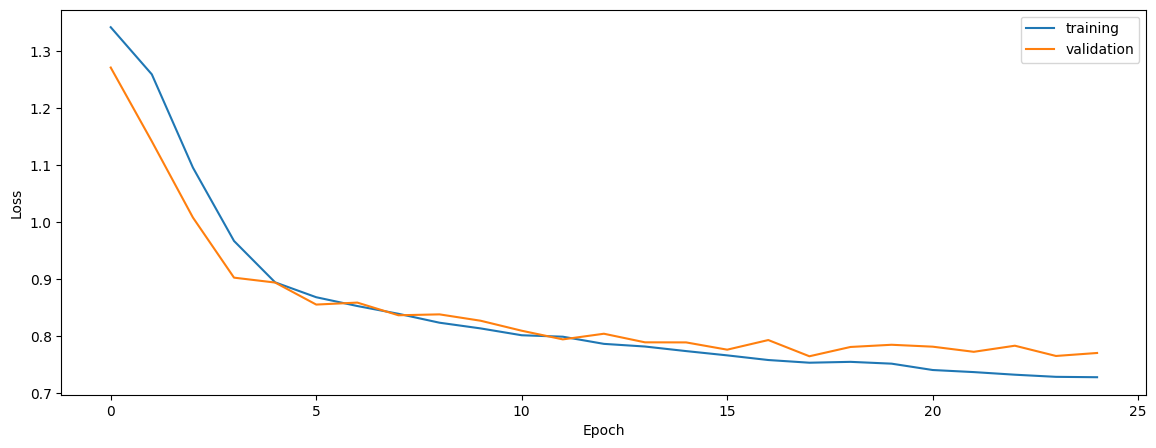

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7028824144752515
0.708053492414665
0.714808672437505


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.7028824144752515
0.708053492414665
0.714808672437505


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7006422473113976
0.717968855788761
0.7138049001915349


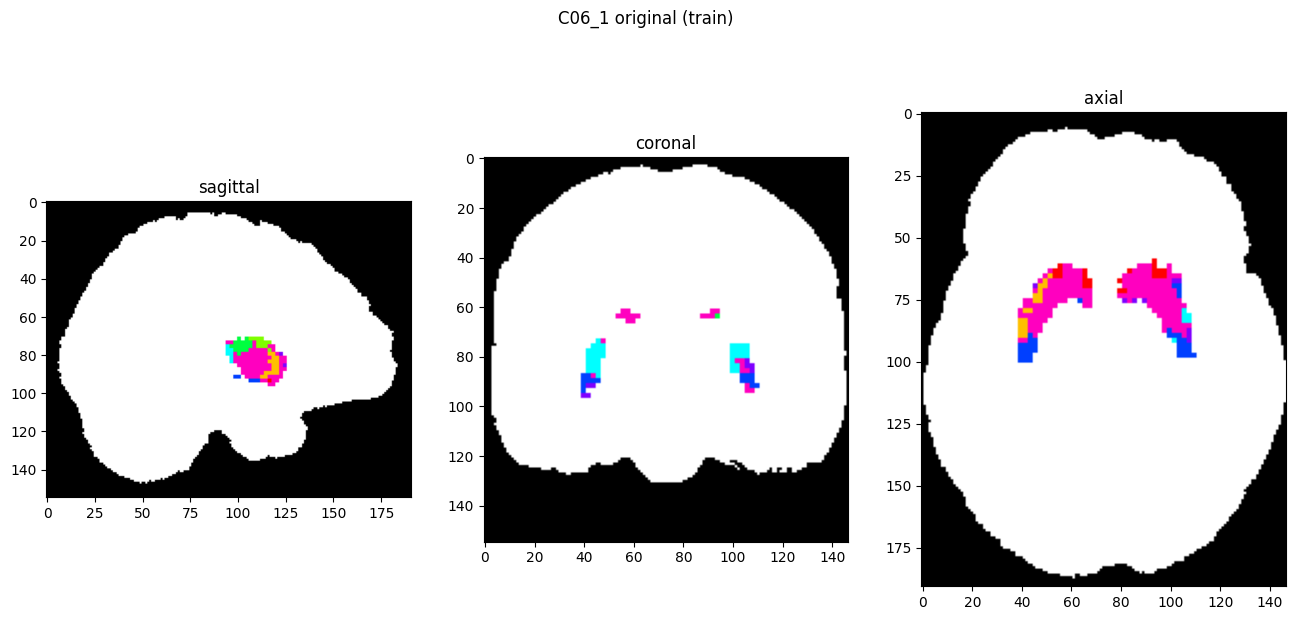

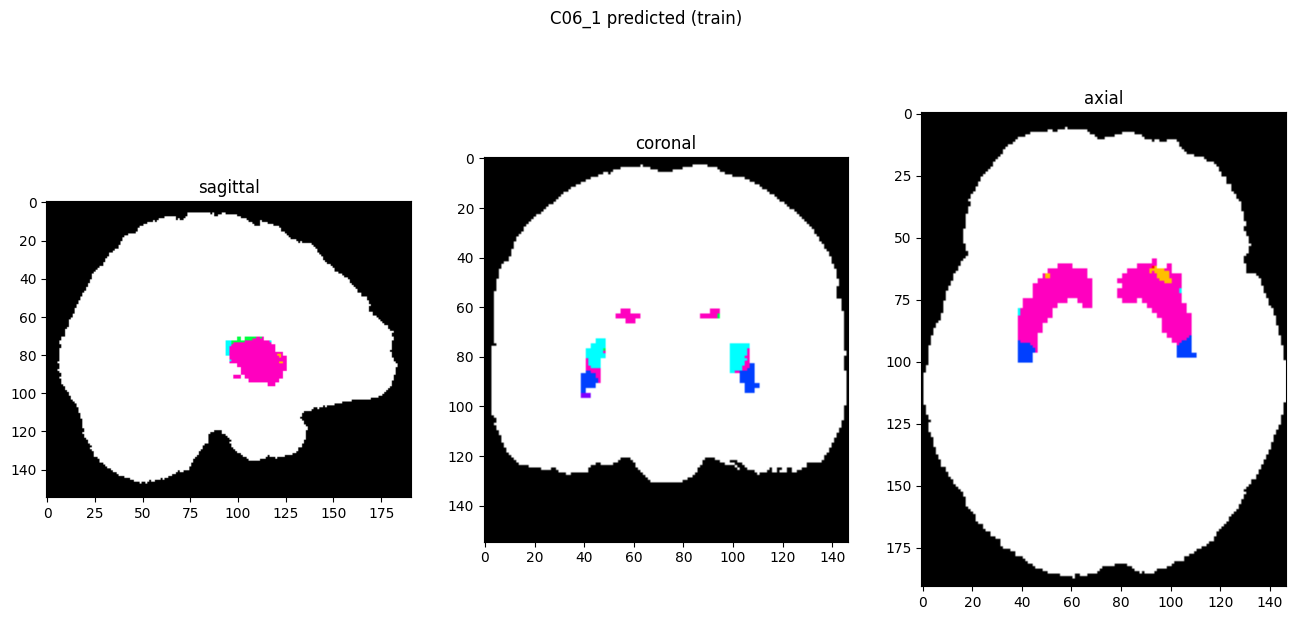

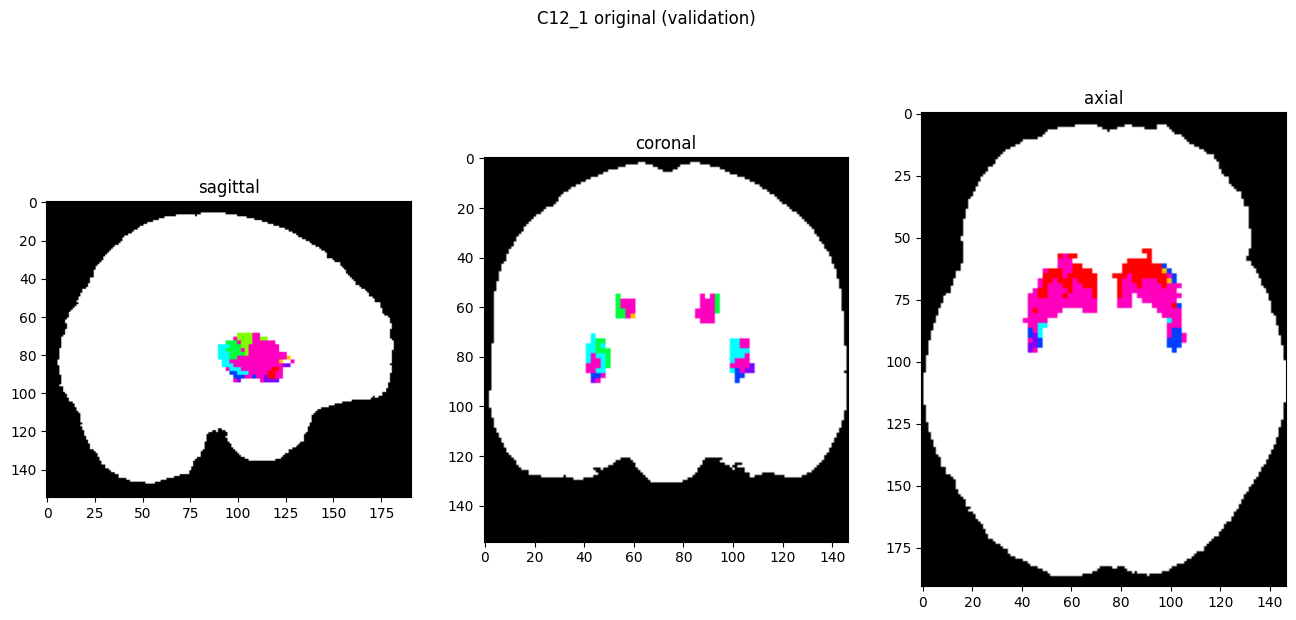

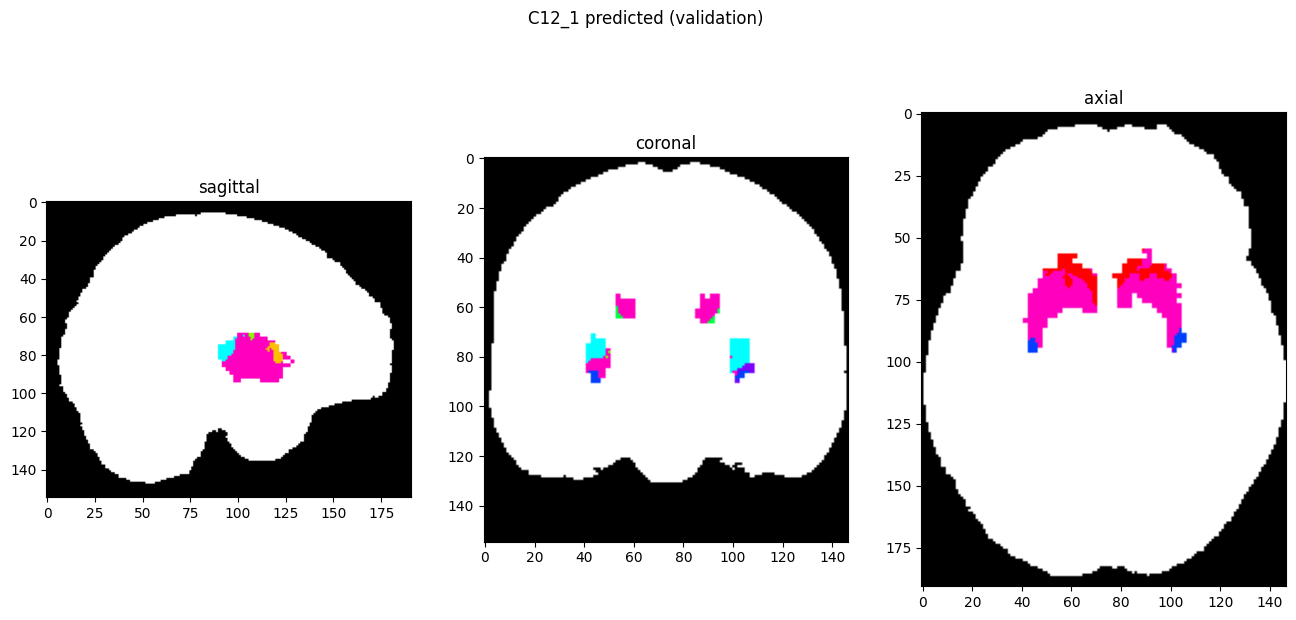

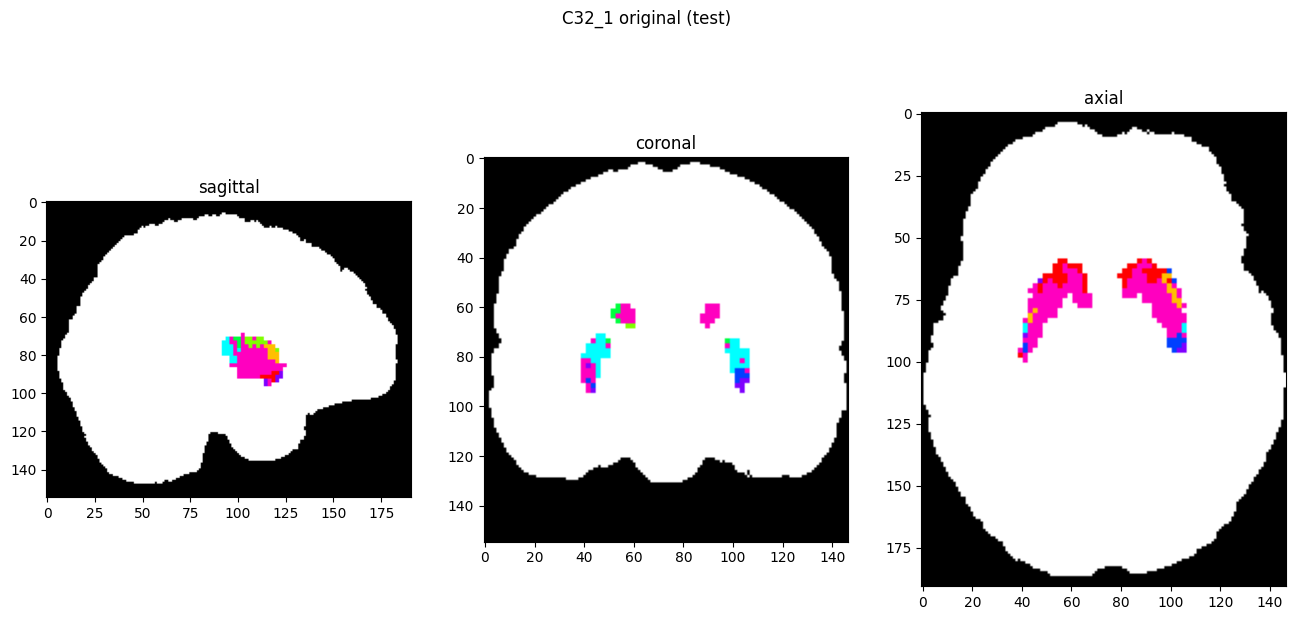

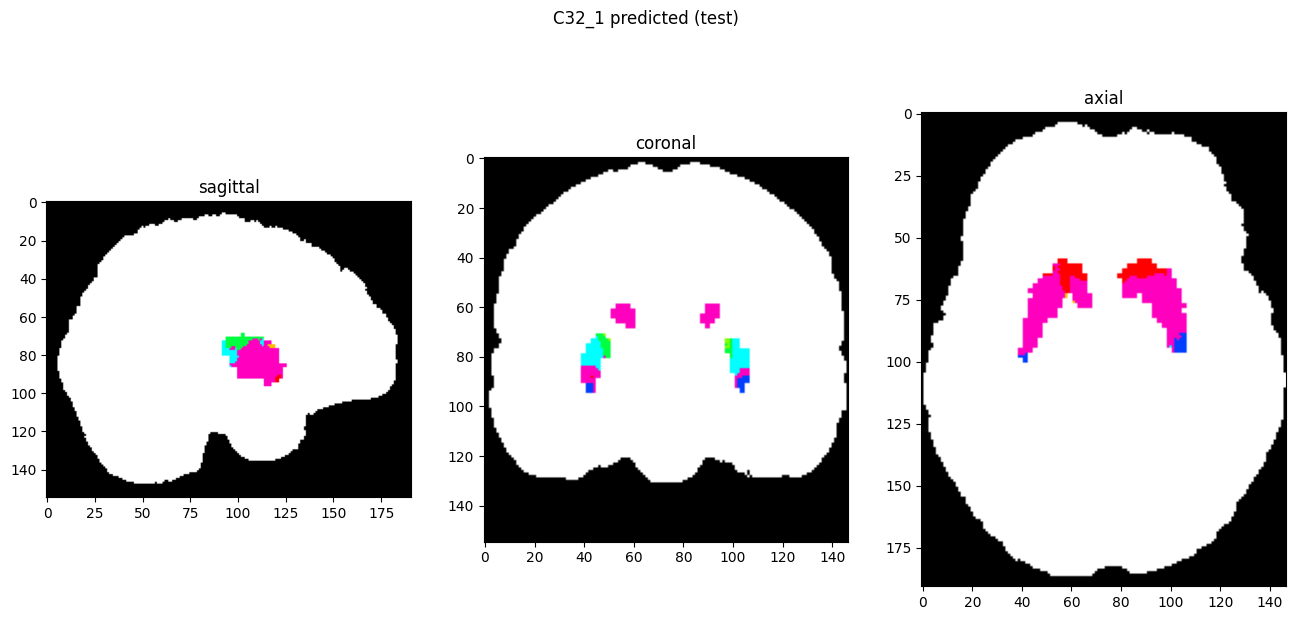

In [10]:
showResults(model, gen, threshold=0)